## Settings

In [1]:
# Name of the config
from config import (
    USE_X_NOISY_DATA,
    USE_Y_NOISY_DATA,
    USE_MIXED_EFFECT,
    INPUT_TO_READOUT,
    READOUT_FEEDBACK_TO_RESERVOIR,
)

print("== Data settings ==")
print(f"\tUSE_X_NOISY_DATA: {USE_X_NOISY_DATA}")
print(f"\tUSE_Y_NOISY_DATA: {USE_Y_NOISY_DATA}")
print(f"\tUSE_MIXED_EFFECT: {USE_MIXED_EFFECT}")

print("== Reservoir settings ==")
print(f"\tINPUT_TO_READOUT: {INPUT_TO_READOUT}")
print(f"\tREADOUT_FEEDBACK_TO_RESERVOIR: {READOUT_FEEDBACK_TO_RESERVOIR}")

#
INIT_SEED = 42
ROOT = "../../../"
TOOL_PATH = ROOT + "tools"
CSV_FILE = ROOT + "data/synthetic_bph_1/simulation.csv"
SERIE_COLUMN_NAME = "individus"
TIMESTEP_COLUMN_NAME = "temps"

== Data settings ==
	USE_X_NOISY_DATA: False
	USE_Y_NOISY_DATA: True
	USE_MIXED_EFFECT: False
== Reservoir settings ==
	INPUT_TO_READOUT: False
	READOUT_FEEDBACK_TO_RESERVOIR: False


## Imports

In [30]:
import sys
import logging
from pathlib import Path

assert Path(TOOL_PATH).exists()
sys.path.append(TOOL_PATH)
sys.path.append("..")  # for model_configurations


from math import ceil
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, QuantileTransformer

# from sklearn.compose import TransformedTargetRegressor
from joblib import dump as jldump
from reservoirpy.nodes import Reservoir, Ridge, Input, ScikitLearnNode

# from reservoirpy.hyper import research, plot_hyperopt_report
from reservoirpy.observables import nrmse, rsquare, mse
import optuna

from model_configurations import (
    ModelConfiguration,
    ScalingData,
)
from time_series_modules import train_test_split_on_series, TimeSerieShapeChanger
from utils import get_quantiles_individuals

In [58]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 300

## Data Loading

In [59]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,0.890634,0.941455,-1.008267,-0.988229,0.264669,0.361084,-0.648976,-0.730239,3.257709e-01,0.322978,2.945083,2.900945,-0.744555,-0.744548,0,-1.678414,-1.782819,-2.072956,-2.057110
1,1,1,0.166724,0.704385,-1.164905,-1.226294,0.264059,0.256220,-0.574728,-0.558283,4.220333e-01,0.421475,3.322322,3.421178,-0.631873,-0.623578,0,-1.919671,-1.873649,-2.530125,-2.419892
2,1,2,-0.557185,-0.697930,-1.256533,-1.332657,0.262231,0.185409,-0.507545,-0.526535,5.028353e-01,0.500725,3.722287,3.718409,-0.524238,-0.519302,0,-1.924473,-1.997926,-2.830060,-2.902343
3,1,3,-1.281095,-0.733795,-1.321543,-1.411484,0.259184,0.347365,-0.446756,-0.479332,5.612743e-01,0.561387,4.144980,4.093975,-0.425830,-0.419581,0,-1.803903,-1.854510,-3.062598,-2.978146
4,1,4,-2.005005,-1.866516,-1.371970,-1.376444,0.254919,0.345040,-0.391751,-0.172551,5.991411e-01,0.595408,4.590399,4.583761,-0.339396,-0.340374,0,-1.635467,-1.675288,-3.277499,-3.235019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-73.726145,-73.652941,0.432651,0.464711,-0.214545,-0.244244,0.266649,0.255834,-1.292289e-17,-0.001200,1.476509,1.440325,-1.328121,-1.326202,1,1.739175,1.718363,0.593690,0.507568
25496,500,47,-75.354554,-75.449685,0.428917,0.612389,-0.258311,-0.249547,0.266401,0.164552,-5.581364e-18,-0.000893,1.578360,1.587577,-1.332378,-1.333835,1,1.771572,1.809840,0.619710,0.606283
25497,500,48,-76.982963,-76.534494,0.425260,0.403345,-0.303018,-0.279160,0.266177,0.312715,-2.410577e-18,0.002469,1.683608,1.674245,-1.336399,-1.329781,1,1.804660,1.964220,0.646286,0.483667
25498,500,49,-78.611371,-79.112450,0.421677,0.315975,-0.348666,-0.344530,0.265974,0.271925,-1.041122e-18,-0.003460,1.792253,1.821948,-1.340198,-1.339676,1,1.838422,1.878651,0.673402,0.698870


In [4]:
x_labels = [
    c for c in data.columns if c.startswith("x") and (("_obs" in c) is USE_X_NOISY_DATA)
]
assert len(x_labels) == 8

y_labels = [
    c
    for c in data.columns
    if c.startswith("y")
    and (("_obs" in c) is USE_Y_NOISY_DATA)
    and (("_mixed" in c) is USE_MIXED_EFFECT)
]
assert len(y_labels) == 1

y_true = ["y_mixed" if USE_MIXED_EFFECT else "y_fixed"]

print(x_labels)
print(y_labels)
print(y_true)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y_fixed_obs']
['y_fixed']


### Spliting on series/individuals

In [5]:
TEST_TRAIN_RATIO = 0.2


data_train, data_test = train_test_split_on_series(
    data,
    SERIE_COLUMN_NAME,
    TIMESTEP_COLUMN_NAME,
    test_size=TEST_TRAIN_RATIO,
    random_state=42,
    shuffle=True,
)

Checking the "series x timesteps" hypothesis…
The dataframe has 500 unique series and 51 unique timesteps, for a total of 25500==500x51


In [60]:
data_train

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs,y_hat
51,2,0,0.917176,1.122408,0.889352,1.014465,1.468332,1.507350,-3.706834,-3.766740,2.812928e-01,0.282201,3.116811,3.179587,-0.732544,-0.727545,1,3.431645,3.588800,1.863642,1.852814,0.150299
52,2,1,0.544067,1.039673,0.049494,0.106958,1.467464,1.354498,-3.496062,-3.446804,4.235476e-01,0.424360,3.319091,3.250093,-0.500632,-0.493772,1,0.821437,0.943247,0.105767,-0.036786,-0.296062
53,2,2,0.170959,0.373402,-0.441792,-0.334913,1.464858,1.425467,-3.305348,-3.271503,5.078582e-01,0.506399,3.527731,3.540055,-0.310972,-0.306229,1,-0.779822,-0.936180,-0.966104,-0.953343,-0.628215
54,2,3,-0.202149,-0.438238,-0.790365,-0.599801,1.460515,1.478672,-3.132783,-3.260878,5.433643e-01,0.547306,3.742729,3.781823,-0.179771,-0.175969,1,-2.002091,-1.935134,-1.779806,-1.861281,-1.099905
55,2,4,-0.575257,-0.193559,-1.060739,-0.874324,1.454435,1.457878,-2.976639,-3.064382,5.561277e-01,0.557364,3.964087,4.004897,-0.099168,-0.105131,1,-3.056588,-2.889120,-2.479740,-2.412412,-1.934584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-73.726145,-73.652941,0.432651,0.464711,-0.214545,-0.244244,0.266649,0.255834,-1.292289e-17,-0.001200,1.476509,1.440325,-1.328121,-1.326202,1,1.739175,1.718363,0.593690,0.507568,1.592164
25496,500,47,-75.354554,-75.449685,0.428917,0.612389,-0.258311,-0.249547,0.266401,0.164552,-5.581364e-18,-0.000893,1.578360,1.587577,-1.332378,-1.333835,1,1.771572,1.809840,0.619710,0.606283,1.531766
25497,500,48,-76.982963,-76.534494,0.425260,0.403345,-0.303018,-0.279160,0.266177,0.312715,-2.410577e-18,0.002469,1.683608,1.674245,-1.336399,-1.329781,1,1.804660,1.964220,0.646286,0.483667,1.488805
25498,500,49,-78.611371,-79.112450,0.421677,0.315975,-0.348666,-0.344530,0.265974,0.271925,-1.041122e-18,-0.003460,1.792253,1.821948,-1.340198,-1.339676,1,1.838422,1.878651,0.673402,0.698870,1.414797


In [61]:
data_test

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,0.890634,0.941455,-1.008267,-0.988229,0.264669,0.361084,-0.648976,-0.730239,3.257709e-01,0.322978,2.945083,2.900945,-7.445547e-01,-0.744548,0,-1.678414,-1.782819,-2.072956,-2.057110
1,1,1,0.166724,0.704385,-1.164905,-1.226294,0.264059,0.256220,-0.574728,-0.558283,4.220333e-01,0.421475,3.322322,3.421178,-6.318732e-01,-0.623578,0,-1.919671,-1.873649,-2.530125,-2.419892
2,1,2,-0.557185,-0.697930,-1.256533,-1.332657,0.262231,0.185409,-0.507545,-0.526535,5.028353e-01,0.500725,3.722287,3.718409,-5.242378e-01,-0.519302,0,-1.924473,-1.997926,-2.830060,-2.902343
3,1,3,-1.281095,-0.733795,-1.321543,-1.411484,0.259184,0.347365,-0.446756,-0.479332,5.612743e-01,0.561387,4.144980,4.093975,-4.258296e-01,-0.419581,0,-1.803903,-1.854510,-3.062598,-2.978146
4,1,4,-2.005005,-1.866516,-1.371970,-1.376444,0.254919,0.345040,-0.391751,-0.172551,5.991411e-01,0.595408,4.590399,4.583761,-3.393963e-01,-0.340374,0,-1.635467,-1.675288,-3.277499,-3.235019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25393,498,46,-9.855542,-9.819291,-2.663384,-2.534075,-0.646690,-0.770152,-0.703329,-0.889543,-1.042387e-41,0.000827,1.293258,1.238766,-6.174199e-20,0.000905,1,-1.834571,-1.837263,-2.189698,-2.112023
25394,498,47,-10.071952,-10.017421,-2.672574,-2.645180,-0.696656,-0.625732,-0.702329,-0.672292,-1.331408e-42,0.002413,1.228305,1.235071,-2.461226e-20,0.003298,1,-1.746793,-1.852710,-2.079470,-2.012377
25395,498,48,-10.288362,-10.622747,-2.681575,-2.550863,-0.747696,-0.792085,-0.701425,-0.729515,-1.700565e-43,-0.001720,1.165025,1.262877,-9.811204e-21,-0.000264,1,-1.660682,-1.532095,-1.971336,-1.930179
25396,498,49,-10.504773,-10.344093,-2.690394,-2.743938,-0.799811,-0.900305,-0.700607,-0.626484,-2.172079e-44,0.002232,1.103419,1.110018,-3.911048e-21,0.004990,1,-1.576289,-1.344503,-1.865358,-1.756237


### Data scalings

In [8]:
x_train = data_train[x_labels]
y_train = data_train[y_labels]
x_test = data_test[x_labels]
y_test = data_test[y_true]


scaling_data = {
    "RobustScaler": ScalingData(
        x_train,
        y_train,
        x_test,
        y_test,
        RobustScaler(),
        RobustScaler(),
    ),
    "QuantileTransformer-uniform": ScalingData(
        x_train,
        y_train,
        x_test,
        y_test,
        QuantileTransformer(output_distribution="uniform"),
        QuantileTransformer(output_distribution="uniform"),
    ),
    "QuantileTransformer-normal": ScalingData(
        x_train,
        y_train,
        x_test,
        y_test,
        QuantileTransformer(output_distribution="normal"),
        QuantileTransformer(output_distribution="normal"),
    ),
}

N_train = len(data_train[SERIE_COLUMN_NAME].unique())
T_train = len(data_train[TIMESTEP_COLUMN_NAME].unique())
P_train = len(x_labels)
Y_train = len(y_labels)


N_test = len(data_test[SERIE_COLUMN_NAME].unique())
T_test = len(data_test[TIMESTEP_COLUMN_NAME].unique())
P_test = len(x_labels)
Y_test = len(y_true)

## Training with hyper-parameters optimization

In [9]:
def objective(trial: optuna.Trial) -> float:
    scaling_data_ = scaling_data[
        trial.suggest_categorical(
            "scaler",
            [
                "RobustScaler",
                "QuantileTransformer-normal",
                "QuantileTransformer-uniform",
            ],
        )
    ]

    # example from:  https://reservoirpy.readthedocs.io/en/latest/user_guide/hyper.html#Step-2:-define-the-research-space
    # hyperopt_config = {
    #     "exp": "hyperopt-multiscroll",  # the experimentation name
    #     "hp_max_evals": 200,  # the number of differents sets of parameters hyperopt has to try
    #     "hp_method": "random",  # the method used by hyperopt to chose those sets (see below)
    #     "seed": 42,  # the random state seed, to ensure reproducibility
    #     "instances_per_trial": 5,  # how many random ESN will be tried with each sets of parameters
    #     "hp_space": {  # what are the ranges of parameters explored
    #         "N": ["choice", 500],  # the number of neurons is fixed to 500
    #         "sr": [
    #             "loguniform",
    #             1e-2,
    #             10,
    #         ],  # the spectral radius is log-uniformly distributed between 1e-2 and 10
    #         "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
    #         "input_scaling": ["choice", 1.0],  # the input scaling is fixed
    #         "ridge": [
    #             "loguniform",
    #             1e-8,
    #             1e1,
    #         ],  # and so is the regularization parameter.
    #         "seed": ["choice", 1234],  # an other random seed for the ESN initialization
    #     },
    # }

    list_rmse = []
    for variable_seed in range(INIT_SEED, INIT_SEED + 3):
        model = ModelConfiguration(
            input_kwargs={},
            reservoir_kwargs={
                "units": trial.suggest_int("N", 100, 1000),
                "sr": trial.suggest_float("sr", 1e-2, 10, log=True),
                "lr": trial.suggest_float("lr", 1e-3, 1, log=True),
                "input_scaling": trial.suggest_float(
                    "input_scaling", 0.5, 2.0, log=False
                ),
                "seed": variable_seed,
            },
            ridge_kwargs={
                "ridge": trial.suggest_float("ridge", 1e-8, 1e1, log=True),
            },
            fit_kwargs={
                "warmup": trial.suggest_int("warmup", 0, 10),
            },
            input_to_readout=INPUT_TO_READOUT,
            readout_feedback_to_reservoir=READOUT_FEEDBACK_TO_RESERVOIR,
        )
        # Train your model and test your model.

        x_train = scaling_data_.x_train.reshape(N_train, T_train, P_train)
        y_train = scaling_data_.y_train.reshape(N_train, T_train, Y_train)
        model.fit(x_train, y_train)

        x_test = scaling_data_.x_test.reshape(N_test, T_test, P_test)
        y_test = scaling_data_.y_test.reshape(N_test, T_test, Y_test)

        y_hat_3D = np.array(model.run(x_test))

        list_rmse.append(nrmse(y_test, y_hat, norm="q1q3"))

    return np.array(list_rmse).mean()

In [12]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "study"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=200)

[I 2024-10-09 20:53:53,984] A new study created in RDB with name: study


A new study created in RDB with name: study
A new study created in RDB with name: study
A new study created in RDB with name: study


[I 2024-10-09 20:54:28,280] Trial 0 finished with value: 85.41293934667813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 751, 'sr': 2.979478382373823, 'lr': 0.0035338875596519354, 'input_scaling': 1.0562786675546512, 'ridge': 0.005106583374425076, 'warmup': 9}. Best is trial 0 with value: 85.41293934667813.


Trial 0 finished with value: 85.41293934667813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 751, 'sr': 2.979478382373823, 'lr': 0.0035338875596519354, 'input_scaling': 1.0562786675546512, 'ridge': 0.005106583374425076, 'warmup': 9}. Best is trial 0 with value: 85.41293934667813.
Trial 0 finished with value: 85.41293934667813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 751, 'sr': 2.979478382373823, 'lr': 0.0035338875596519354, 'input_scaling': 1.0562786675546512, 'ridge': 0.005106583374425076, 'warmup': 9}. Best is trial 0 with value: 85.41293934667813.
Trial 0 finished with value: 85.41293934667813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 751, 'sr': 2.979478382373823, 'lr': 0.0035338875596519354, 'input_scaling': 1.0562786675546512, 'ridge': 0.005106583374425076, 'warmup': 9}. Best is trial 0 with value: 85.41293934667813.


[I 2024-10-09 20:55:08,447] Trial 1 finished with value: 2.3058572892415454 and parameters: {'scaler': 'RobustScaler', 'N': 877, 'sr': 1.1141182832944845, 'lr': 0.42609503801011467, 'input_scaling': 1.230336040071235, 'ridge': 5.832436716097242e-07, 'warmup': 7}. Best is trial 1 with value: 2.3058572892415454.


Trial 1 finished with value: 2.3058572892415454 and parameters: {'scaler': 'RobustScaler', 'N': 877, 'sr': 1.1141182832944845, 'lr': 0.42609503801011467, 'input_scaling': 1.230336040071235, 'ridge': 5.832436716097242e-07, 'warmup': 7}. Best is trial 1 with value: 2.3058572892415454.
Trial 1 finished with value: 2.3058572892415454 and parameters: {'scaler': 'RobustScaler', 'N': 877, 'sr': 1.1141182832944845, 'lr': 0.42609503801011467, 'input_scaling': 1.230336040071235, 'ridge': 5.832436716097242e-07, 'warmup': 7}. Best is trial 1 with value: 2.3058572892415454.
Trial 1 finished with value: 2.3058572892415454 and parameters: {'scaler': 'RobustScaler', 'N': 877, 'sr': 1.1141182832944845, 'lr': 0.42609503801011467, 'input_scaling': 1.230336040071235, 'ridge': 5.832436716097242e-07, 'warmup': 7}. Best is trial 1 with value: 2.3058572892415454.


[I 2024-10-09 20:55:34,201] Trial 2 finished with value: 4.878457765251767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 347, 'sr': 0.7075421111632014, 'lr': 0.004258488546348283, 'input_scaling': 1.405343179553313, 'ridge': 1.817956570757515e-05, 'warmup': 2}. Best is trial 1 with value: 2.3058572892415454.


Trial 2 finished with value: 4.878457765251767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 347, 'sr': 0.7075421111632014, 'lr': 0.004258488546348283, 'input_scaling': 1.405343179553313, 'ridge': 1.817956570757515e-05, 'warmup': 2}. Best is trial 1 with value: 2.3058572892415454.
Trial 2 finished with value: 4.878457765251767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 347, 'sr': 0.7075421111632014, 'lr': 0.004258488546348283, 'input_scaling': 1.405343179553313, 'ridge': 1.817956570757515e-05, 'warmup': 2}. Best is trial 1 with value: 2.3058572892415454.
Trial 2 finished with value: 4.878457765251767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 347, 'sr': 0.7075421111632014, 'lr': 0.004258488546348283, 'input_scaling': 1.405343179553313, 'ridge': 1.817956570757515e-05, 'warmup': 2}. Best is trial 1 with value: 2.3058572892415454.


[I 2024-10-09 20:56:04,502] Trial 3 finished with value: 17.528616530920406 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 574, 'sr': 2.0060910714658142, 'lr': 0.5336439903341578, 'input_scaling': 1.8038406507964015, 'ridge': 9.414543508592714e-07, 'warmup': 10}. Best is trial 1 with value: 2.3058572892415454.


Trial 3 finished with value: 17.528616530920406 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 574, 'sr': 2.0060910714658142, 'lr': 0.5336439903341578, 'input_scaling': 1.8038406507964015, 'ridge': 9.414543508592714e-07, 'warmup': 10}. Best is trial 1 with value: 2.3058572892415454.
Trial 3 finished with value: 17.528616530920406 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 574, 'sr': 2.0060910714658142, 'lr': 0.5336439903341578, 'input_scaling': 1.8038406507964015, 'ridge': 9.414543508592714e-07, 'warmup': 10}. Best is trial 1 with value: 2.3058572892415454.
Trial 3 finished with value: 17.528616530920406 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 574, 'sr': 2.0060910714658142, 'lr': 0.5336439903341578, 'input_scaling': 1.8038406507964015, 'ridge': 9.414543508592714e-07, 'warmup': 10}. Best is trial 1 with value: 2.3058572892415454.


[I 2024-10-09 20:56:36,363] Trial 4 finished with value: 2.154291378856966 and parameters: {'scaler': 'RobustScaler', 'N': 651, 'sr': 2.4949525650339908, 'lr': 0.11144912668479294, 'input_scaling': 1.9030297705601908, 'ridge': 6.170077284763357e-07, 'warmup': 3}. Best is trial 4 with value: 2.154291378856966.


Trial 4 finished with value: 2.154291378856966 and parameters: {'scaler': 'RobustScaler', 'N': 651, 'sr': 2.4949525650339908, 'lr': 0.11144912668479294, 'input_scaling': 1.9030297705601908, 'ridge': 6.170077284763357e-07, 'warmup': 3}. Best is trial 4 with value: 2.154291378856966.
Trial 4 finished with value: 2.154291378856966 and parameters: {'scaler': 'RobustScaler', 'N': 651, 'sr': 2.4949525650339908, 'lr': 0.11144912668479294, 'input_scaling': 1.9030297705601908, 'ridge': 6.170077284763357e-07, 'warmup': 3}. Best is trial 4 with value: 2.154291378856966.
Trial 4 finished with value: 2.154291378856966 and parameters: {'scaler': 'RobustScaler', 'N': 651, 'sr': 2.4949525650339908, 'lr': 0.11144912668479294, 'input_scaling': 1.9030297705601908, 'ridge': 6.170077284763357e-07, 'warmup': 3}. Best is trial 4 with value: 2.154291378856966.


[I 2024-10-09 20:56:58,421] Trial 5 finished with value: 9.04942315124691 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 121, 'sr': 0.05762255354789222, 'lr': 0.2151751413553466, 'input_scaling': 1.47678971276281, 'ridge': 2.749635095662481e-07, 'warmup': 10}. Best is trial 4 with value: 2.154291378856966.


Trial 5 finished with value: 9.04942315124691 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 121, 'sr': 0.05762255354789222, 'lr': 0.2151751413553466, 'input_scaling': 1.47678971276281, 'ridge': 2.749635095662481e-07, 'warmup': 10}. Best is trial 4 with value: 2.154291378856966.
Trial 5 finished with value: 9.04942315124691 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 121, 'sr': 0.05762255354789222, 'lr': 0.2151751413553466, 'input_scaling': 1.47678971276281, 'ridge': 2.749635095662481e-07, 'warmup': 10}. Best is trial 4 with value: 2.154291378856966.
Trial 5 finished with value: 9.04942315124691 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 121, 'sr': 0.05762255354789222, 'lr': 0.2151751413553466, 'input_scaling': 1.47678971276281, 'ridge': 2.749635095662481e-07, 'warmup': 10}. Best is trial 4 with value: 2.154291378856966.


[I 2024-10-09 20:57:34,756] Trial 6 finished with value: 8.368317719389877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 801, 'sr': 0.15349290526960654, 'lr': 0.001153613526373699, 'input_scaling': 1.9611580743060057, 'ridge': 1.3195322009816876e-06, 'warmup': 7}. Best is trial 4 with value: 2.154291378856966.


Trial 6 finished with value: 8.368317719389877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 801, 'sr': 0.15349290526960654, 'lr': 0.001153613526373699, 'input_scaling': 1.9611580743060057, 'ridge': 1.3195322009816876e-06, 'warmup': 7}. Best is trial 4 with value: 2.154291378856966.
Trial 6 finished with value: 8.368317719389877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 801, 'sr': 0.15349290526960654, 'lr': 0.001153613526373699, 'input_scaling': 1.9611580743060057, 'ridge': 1.3195322009816876e-06, 'warmup': 7}. Best is trial 4 with value: 2.154291378856966.
Trial 6 finished with value: 8.368317719389877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 801, 'sr': 0.15349290526960654, 'lr': 0.001153613526373699, 'input_scaling': 1.9611580743060057, 'ridge': 1.3195322009816876e-06, 'warmup': 7}. Best is trial 4 with value: 2.154291378856966.


[I 2024-10-09 20:57:56,749] Trial 7 finished with value: 0.4280264189550052 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 114, 'sr': 0.10930311184290749, 'lr': 0.48086186063476744, 'input_scaling': 1.1109212999204736, 'ridge': 0.01577817525602345, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


Trial 7 finished with value: 0.4280264189550052 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 114, 'sr': 0.10930311184290749, 'lr': 0.48086186063476744, 'input_scaling': 1.1109212999204736, 'ridge': 0.01577817525602345, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 7 finished with value: 0.4280264189550052 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 114, 'sr': 0.10930311184290749, 'lr': 0.48086186063476744, 'input_scaling': 1.1109212999204736, 'ridge': 0.01577817525602345, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 7 finished with value: 0.4280264189550052 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 114, 'sr': 0.10930311184290749, 'lr': 0.48086186063476744, 'input_scaling': 1.1109212999204736, 'ridge': 0.01577817525602345, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 20:58:24,715] Trial 8 finished with value: 0.6306839532279724 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 516, 'sr': 1.231698120109911, 'lr': 0.07572776452283222, 'input_scaling': 1.0166032741456994, 'ridge': 0.21547538672602484, 'warmup': 7}. Best is trial 7 with value: 0.4280264189550052.


Trial 8 finished with value: 0.6306839532279724 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 516, 'sr': 1.231698120109911, 'lr': 0.07572776452283222, 'input_scaling': 1.0166032741456994, 'ridge': 0.21547538672602484, 'warmup': 7}. Best is trial 7 with value: 0.4280264189550052.
Trial 8 finished with value: 0.6306839532279724 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 516, 'sr': 1.231698120109911, 'lr': 0.07572776452283222, 'input_scaling': 1.0166032741456994, 'ridge': 0.21547538672602484, 'warmup': 7}. Best is trial 7 with value: 0.4280264189550052.
Trial 8 finished with value: 0.6306839532279724 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 516, 'sr': 1.231698120109911, 'lr': 0.07572776452283222, 'input_scaling': 1.0166032741456994, 'ridge': 0.21547538672602484, 'warmup': 7}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 20:58:57,423] Trial 9 finished with value: 58.98522828330679 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 718, 'sr': 1.6953929128298943, 'lr': 0.004319527430559214, 'input_scaling': 0.8176644158066231, 'ridge': 0.0014279592577514878, 'warmup': 10}. Best is trial 7 with value: 0.4280264189550052.


Trial 9 finished with value: 58.98522828330679 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 718, 'sr': 1.6953929128298943, 'lr': 0.004319527430559214, 'input_scaling': 0.8176644158066231, 'ridge': 0.0014279592577514878, 'warmup': 10}. Best is trial 7 with value: 0.4280264189550052.
Trial 9 finished with value: 58.98522828330679 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 718, 'sr': 1.6953929128298943, 'lr': 0.004319527430559214, 'input_scaling': 0.8176644158066231, 'ridge': 0.0014279592577514878, 'warmup': 10}. Best is trial 7 with value: 0.4280264189550052.
Trial 9 finished with value: 58.98522828330679 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 718, 'sr': 1.6953929128298943, 'lr': 0.004319527430559214, 'input_scaling': 0.8176644158066231, 'ridge': 0.0014279592577514878, 'warmup': 10}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 20:59:16,520] Trial 10 finished with value: 0.5786439342140829 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 145, 'sr': 0.016560563927848545, 'lr': 0.025777433263064413, 'input_scaling': 0.7867829979717842, 'ridge': 7.734537675314837, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.


Trial 10 finished with value: 0.5786439342140829 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 145, 'sr': 0.016560563927848545, 'lr': 0.025777433263064413, 'input_scaling': 0.7867829979717842, 'ridge': 7.734537675314837, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.
Trial 10 finished with value: 0.5786439342140829 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 145, 'sr': 0.016560563927848545, 'lr': 0.025777433263064413, 'input_scaling': 0.7867829979717842, 'ridge': 7.734537675314837, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.
Trial 10 finished with value: 0.5786439342140829 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 145, 'sr': 0.016560563927848545, 'lr': 0.025777433263064413, 'input_scaling': 0.7867829979717842, 'ridge': 7.734537675314837, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 20:59:33,374] Trial 11 finished with value: 0.6099037660529537 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 125, 'sr': 0.010280798131906993, 'lr': 0.016989540017148405, 'input_scaling': 0.6741983151923412, 'ridge': 5.997388509256455, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.


Trial 11 finished with value: 0.6099037660529537 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 125, 'sr': 0.010280798131906993, 'lr': 0.016989540017148405, 'input_scaling': 0.6741983151923412, 'ridge': 5.997388509256455, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.
Trial 11 finished with value: 0.6099037660529537 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 125, 'sr': 0.010280798131906993, 'lr': 0.016989540017148405, 'input_scaling': 0.6741983151923412, 'ridge': 5.997388509256455, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.
Trial 11 finished with value: 0.6099037660529537 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 125, 'sr': 0.010280798131906993, 'lr': 0.016989540017148405, 'input_scaling': 0.6741983151923412, 'ridge': 5.997388509256455, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 20:59:53,164] Trial 12 finished with value: 0.5725650413160374 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 311, 'sr': 0.020697906137970963, 'lr': 0.02592890334173854, 'input_scaling': 0.6434625430762084, 'ridge': 7.598994255863124, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.


Trial 12 finished with value: 0.5725650413160374 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 311, 'sr': 0.020697906137970963, 'lr': 0.02592890334173854, 'input_scaling': 0.6434625430762084, 'ridge': 7.598994255863124, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.
Trial 12 finished with value: 0.5725650413160374 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 311, 'sr': 0.020697906137970963, 'lr': 0.02592890334173854, 'input_scaling': 0.6434625430762084, 'ridge': 7.598994255863124, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.
Trial 12 finished with value: 0.5725650413160374 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 311, 'sr': 0.020697906137970963, 'lr': 0.02592890334173854, 'input_scaling': 0.6434625430762084, 'ridge': 7.598994255863124, 'warmup': 0}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:00:13,091] Trial 13 finished with value: 0.4311310904406054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 335, 'sr': 0.05088039238488864, 'lr': 0.991462462934397, 'input_scaling': 0.5028346953884713, 'ridge': 0.04033291996465205, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


Trial 13 finished with value: 0.4311310904406054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 335, 'sr': 0.05088039238488864, 'lr': 0.991462462934397, 'input_scaling': 0.5028346953884713, 'ridge': 0.04033291996465205, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 13 finished with value: 0.4311310904406054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 335, 'sr': 0.05088039238488864, 'lr': 0.991462462934397, 'input_scaling': 0.5028346953884713, 'ridge': 0.04033291996465205, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 13 finished with value: 0.4311310904406054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 335, 'sr': 0.05088039238488864, 'lr': 0.991462462934397, 'input_scaling': 0.5028346953884713, 'ridge': 0.04033291996465205, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:00:33,005] Trial 14 finished with value: 0.6673437230374248 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 326, 'sr': 0.16081595851465866, 'lr': 0.8951391526843252, 'input_scaling': 1.6081530305701257, 'ridge': 0.035340592933293745, 'warmup': 3}. Best is trial 7 with value: 0.4280264189550052.


Trial 14 finished with value: 0.6673437230374248 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 326, 'sr': 0.16081595851465866, 'lr': 0.8951391526843252, 'input_scaling': 1.6081530305701257, 'ridge': 0.035340592933293745, 'warmup': 3}. Best is trial 7 with value: 0.4280264189550052.
Trial 14 finished with value: 0.6673437230374248 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 326, 'sr': 0.16081595851465866, 'lr': 0.8951391526843252, 'input_scaling': 1.6081530305701257, 'ridge': 0.035340592933293745, 'warmup': 3}. Best is trial 7 with value: 0.4280264189550052.
Trial 14 finished with value: 0.6673437230374248 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 326, 'sr': 0.16081595851465866, 'lr': 0.8951391526843252, 'input_scaling': 1.6081530305701257, 'ridge': 0.035340592933293745, 'warmup': 3}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:00:51,624] Trial 15 finished with value: 0.9859949930901054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 254, 'sr': 0.052030878478463535, 'lr': 0.2799670394651422, 'input_scaling': 0.9745160582966842, 'ridge': 5.650406285096373e-05, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.


Trial 15 finished with value: 0.9859949930901054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 254, 'sr': 0.052030878478463535, 'lr': 0.2799670394651422, 'input_scaling': 0.9745160582966842, 'ridge': 5.650406285096373e-05, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.
Trial 15 finished with value: 0.9859949930901054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 254, 'sr': 0.052030878478463535, 'lr': 0.2799670394651422, 'input_scaling': 0.9745160582966842, 'ridge': 5.650406285096373e-05, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.
Trial 15 finished with value: 0.9859949930901054 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 254, 'sr': 0.052030878478463535, 'lr': 0.2799670394651422, 'input_scaling': 0.9745160582966842, 'ridge': 5.650406285096373e-05, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:01:16,081] Trial 16 finished with value: 1.9115268178007965 and parameters: {'scaler': 'RobustScaler', 'N': 447, 'sr': 9.183589340539312, 'lr': 0.9369117158861414, 'input_scaling': 0.5173272803275994, 'ridge': 0.09382662319548087, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


Trial 16 finished with value: 1.9115268178007965 and parameters: {'scaler': 'RobustScaler', 'N': 447, 'sr': 9.183589340539312, 'lr': 0.9369117158861414, 'input_scaling': 0.5173272803275994, 'ridge': 0.09382662319548087, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 16 finished with value: 1.9115268178007965 and parameters: {'scaler': 'RobustScaler', 'N': 447, 'sr': 9.183589340539312, 'lr': 0.9369117158861414, 'input_scaling': 0.5173272803275994, 'ridge': 0.09382662319548087, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 16 finished with value: 1.9115268178007965 and parameters: {'scaler': 'RobustScaler', 'N': 447, 'sr': 9.183589340539312, 'lr': 0.9369117158861414, 'input_scaling': 0.5173272803275994, 'ridge': 0.09382662319548087, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:01:40,457] Trial 17 finished with value: 0.6040103607465591 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 220, 'sr': 0.3171216677156181, 'lr': 0.09296532682122506, 'input_scaling': 1.1599850169532604, 'ridge': 0.007061026230375596, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.


Trial 17 finished with value: 0.6040103607465591 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 220, 'sr': 0.3171216677156181, 'lr': 0.09296532682122506, 'input_scaling': 1.1599850169532604, 'ridge': 0.007061026230375596, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.
Trial 17 finished with value: 0.6040103607465591 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 220, 'sr': 0.3171216677156181, 'lr': 0.09296532682122506, 'input_scaling': 1.1599850169532604, 'ridge': 0.007061026230375596, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.
Trial 17 finished with value: 0.6040103607465591 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 220, 'sr': 0.3171216677156181, 'lr': 0.09296532682122506, 'input_scaling': 1.1599850169532604, 'ridge': 0.007061026230375596, 'warmup': 5}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:02:04,829] Trial 18 finished with value: 0.4280327193847189 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 417, 'sr': 0.05372452446407405, 'lr': 0.1615762214927666, 'input_scaling': 0.523828388060628, 'ridge': 0.631634776244677, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


Trial 18 finished with value: 0.4280327193847189 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 417, 'sr': 0.05372452446407405, 'lr': 0.1615762214927666, 'input_scaling': 0.523828388060628, 'ridge': 0.631634776244677, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 18 finished with value: 0.4280327193847189 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 417, 'sr': 0.05372452446407405, 'lr': 0.1615762214927666, 'input_scaling': 0.523828388060628, 'ridge': 0.631634776244677, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.
Trial 18 finished with value: 0.4280327193847189 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 417, 'sr': 0.05372452446407405, 'lr': 0.1615762214927666, 'input_scaling': 0.523828388060628, 'ridge': 0.631634776244677, 'warmup': 2}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:02:45,808] Trial 19 finished with value: 1.9529742877030822 and parameters: {'scaler': 'RobustScaler', 'N': 978, 'sr': 0.10868318878250008, 'lr': 0.18727657247001722, 'input_scaling': 0.8836314766926088, 'ridge': 1.472362632311732e-08, 'warmup': 4}. Best is trial 7 with value: 0.4280264189550052.


Trial 19 finished with value: 1.9529742877030822 and parameters: {'scaler': 'RobustScaler', 'N': 978, 'sr': 0.10868318878250008, 'lr': 0.18727657247001722, 'input_scaling': 0.8836314766926088, 'ridge': 1.472362632311732e-08, 'warmup': 4}. Best is trial 7 with value: 0.4280264189550052.
Trial 19 finished with value: 1.9529742877030822 and parameters: {'scaler': 'RobustScaler', 'N': 978, 'sr': 0.10868318878250008, 'lr': 0.18727657247001722, 'input_scaling': 0.8836314766926088, 'ridge': 1.472362632311732e-08, 'warmup': 4}. Best is trial 7 with value: 0.4280264189550052.
Trial 19 finished with value: 1.9529742877030822 and parameters: {'scaler': 'RobustScaler', 'N': 978, 'sr': 0.10868318878250008, 'lr': 0.18727657247001722, 'input_scaling': 0.8836314766926088, 'ridge': 1.472362632311732e-08, 'warmup': 4}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:03:10,869] Trial 20 finished with value: 0.4870809685333281 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 458, 'sr': 0.3512941914166823, 'lr': 0.07091774837160507, 'input_scaling': 1.3764194923293158, 'ridge': 0.816114595896029, 'warmup': 1}. Best is trial 7 with value: 0.4280264189550052.


Trial 20 finished with value: 0.4870809685333281 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 458, 'sr': 0.3512941914166823, 'lr': 0.07091774837160507, 'input_scaling': 1.3764194923293158, 'ridge': 0.816114595896029, 'warmup': 1}. Best is trial 7 with value: 0.4280264189550052.
Trial 20 finished with value: 0.4870809685333281 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 458, 'sr': 0.3512941914166823, 'lr': 0.07091774837160507, 'input_scaling': 1.3764194923293158, 'ridge': 0.816114595896029, 'warmup': 1}. Best is trial 7 with value: 0.4280264189550052.
Trial 20 finished with value: 0.4870809685333281 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 458, 'sr': 0.3512941914166823, 'lr': 0.07091774837160507, 'input_scaling': 1.3764194923293158, 'ridge': 0.816114595896029, 'warmup': 1}. Best is trial 7 with value: 0.4280264189550052.


[I 2024-10-09 21:03:36,722] Trial 21 finished with value: 0.35954638094748853 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.04278509602477086, 'lr': 0.42071044412032227, 'input_scaling': 0.5045127609297181, 'ridge': 0.017839058689969982, 'warmup': 2}. Best is trial 21 with value: 0.35954638094748853.


Trial 21 finished with value: 0.35954638094748853 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.04278509602477086, 'lr': 0.42071044412032227, 'input_scaling': 0.5045127609297181, 'ridge': 0.017839058689969982, 'warmup': 2}. Best is trial 21 with value: 0.35954638094748853.
Trial 21 finished with value: 0.35954638094748853 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.04278509602477086, 'lr': 0.42071044412032227, 'input_scaling': 0.5045127609297181, 'ridge': 0.017839058689969982, 'warmup': 2}. Best is trial 21 with value: 0.35954638094748853.
Trial 21 finished with value: 0.35954638094748853 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.04278509602477086, 'lr': 0.42071044412032227, 'input_scaling': 0.5045127609297181, 'ridge': 0.017839058689969982, 'warmup': 2}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:04:06,301] Trial 22 finished with value: 0.5145671191627516 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 576, 'sr': 0.09534132319888156, 'lr': 0.4159840884456974, 'input_scaling': 0.660249786081144, 'ridge': 0.00014877367781834363, 'warmup': 3}. Best is trial 21 with value: 0.35954638094748853.


Trial 22 finished with value: 0.5145671191627516 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 576, 'sr': 0.09534132319888156, 'lr': 0.4159840884456974, 'input_scaling': 0.660249786081144, 'ridge': 0.00014877367781834363, 'warmup': 3}. Best is trial 21 with value: 0.35954638094748853.
Trial 22 finished with value: 0.5145671191627516 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 576, 'sr': 0.09534132319888156, 'lr': 0.4159840884456974, 'input_scaling': 0.660249786081144, 'ridge': 0.00014877367781834363, 'warmup': 3}. Best is trial 21 with value: 0.35954638094748853.
Trial 22 finished with value: 0.5145671191627516 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 576, 'sr': 0.09534132319888156, 'lr': 0.4159840884456974, 'input_scaling': 0.660249786081144, 'ridge': 0.00014877367781834363, 'warmup': 3}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:04:30,372] Trial 23 finished with value: 0.38764517700326473 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 422, 'sr': 0.029273503369369673, 'lr': 0.1504103336882048, 'input_scaling': 0.7306166537899782, 'ridge': 0.6821326057227605, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


Trial 23 finished with value: 0.38764517700326473 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 422, 'sr': 0.029273503369369673, 'lr': 0.1504103336882048, 'input_scaling': 0.7306166537899782, 'ridge': 0.6821326057227605, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 23 finished with value: 0.38764517700326473 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 422, 'sr': 0.029273503369369673, 'lr': 0.1504103336882048, 'input_scaling': 0.7306166537899782, 'ridge': 0.6821326057227605, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 23 finished with value: 0.38764517700326473 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 422, 'sr': 0.029273503369369673, 'lr': 0.1504103336882048, 'input_scaling': 0.7306166537899782, 'ridge': 0.6821326057227605, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:04:54,066] Trial 24 finished with value: 0.5099501178515718 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.02725332229578812, 'lr': 0.042582397442156396, 'input_scaling': 0.7420532378977114, 'ridge': 0.001235925641711536, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


Trial 24 finished with value: 0.5099501178515718 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.02725332229578812, 'lr': 0.042582397442156396, 'input_scaling': 0.7420532378977114, 'ridge': 0.001235925641711536, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 24 finished with value: 0.5099501178515718 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.02725332229578812, 'lr': 0.042582397442156396, 'input_scaling': 0.7420532378977114, 'ridge': 0.001235925641711536, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 24 finished with value: 0.5099501178515718 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 403, 'sr': 0.02725332229578812, 'lr': 0.042582397442156396, 'input_scaling': 0.7420532378977114, 'ridge': 0.001235925641711536, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:05:16,700] Trial 25 finished with value: 0.3998840378194129 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 212, 'sr': 0.028443498412547646, 'lr': 0.3230422763345572, 'input_scaling': 0.8895270320375182, 'ridge': 0.010850911576497148, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


Trial 25 finished with value: 0.3998840378194129 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 212, 'sr': 0.028443498412547646, 'lr': 0.3230422763345572, 'input_scaling': 0.8895270320375182, 'ridge': 0.010850911576497148, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 25 finished with value: 0.3998840378194129 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 212, 'sr': 0.028443498412547646, 'lr': 0.3230422763345572, 'input_scaling': 0.8895270320375182, 'ridge': 0.010850911576497148, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 25 finished with value: 0.3998840378194129 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 212, 'sr': 0.028443498412547646, 'lr': 0.3230422763345572, 'input_scaling': 0.8895270320375182, 'ridge': 0.010850911576497148, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:05:38,168] Trial 26 finished with value: 0.4176963729063143 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 208, 'sr': 0.031390151243318655, 'lr': 0.3085986846494987, 'input_scaling': 0.9186552628686039, 'ridge': 0.43935183087450114, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


Trial 26 finished with value: 0.4176963729063143 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 208, 'sr': 0.031390151243318655, 'lr': 0.3085986846494987, 'input_scaling': 0.9186552628686039, 'ridge': 0.43935183087450114, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 26 finished with value: 0.4176963729063143 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 208, 'sr': 0.031390151243318655, 'lr': 0.3085986846494987, 'input_scaling': 0.9186552628686039, 'ridge': 0.43935183087450114, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 26 finished with value: 0.4176963729063143 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 208, 'sr': 0.031390151243318655, 'lr': 0.3085986846494987, 'input_scaling': 0.9186552628686039, 'ridge': 0.43935183087450114, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:06:00,504] Trial 27 finished with value: 0.4761164891599809 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 248, 'sr': 0.010440744040605915, 'lr': 0.1373372805705699, 'input_scaling': 0.6985221580626745, 'ridge': 0.0010806253409609626, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.


Trial 27 finished with value: 0.4761164891599809 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 248, 'sr': 0.010440744040605915, 'lr': 0.1373372805705699, 'input_scaling': 0.6985221580626745, 'ridge': 0.0010806253409609626, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.
Trial 27 finished with value: 0.4761164891599809 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 248, 'sr': 0.010440744040605915, 'lr': 0.1373372805705699, 'input_scaling': 0.6985221580626745, 'ridge': 0.0010806253409609626, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.
Trial 27 finished with value: 0.4761164891599809 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 248, 'sr': 0.010440744040605915, 'lr': 0.1373372805705699, 'input_scaling': 0.6985221580626745, 'ridge': 0.0010806253409609626, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:06:27,931] Trial 28 finished with value: 1.3417173863304368 and parameters: {'scaler': 'RobustScaler', 'N': 512, 'sr': 0.029039945106062913, 'lr': 0.048580995169162186, 'input_scaling': 0.6043452061344416, 'ridge': 0.9609301313172046, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


Trial 28 finished with value: 1.3417173863304368 and parameters: {'scaler': 'RobustScaler', 'N': 512, 'sr': 0.029039945106062913, 'lr': 0.048580995169162186, 'input_scaling': 0.6043452061344416, 'ridge': 0.9609301313172046, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 28 finished with value: 1.3417173863304368 and parameters: {'scaler': 'RobustScaler', 'N': 512, 'sr': 0.029039945106062913, 'lr': 0.048580995169162186, 'input_scaling': 0.6043452061344416, 'ridge': 0.9609301313172046, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.
Trial 28 finished with value: 1.3417173863304368 and parameters: {'scaler': 'RobustScaler', 'N': 512, 'sr': 0.029039945106062913, 'lr': 0.048580995169162186, 'input_scaling': 0.6043452061344416, 'ridge': 0.9609301313172046, 'warmup': 1}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:06:51,832] Trial 29 finished with value: 0.49927524478196667 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 385, 'sr': 0.01697688315350165, 'lr': 0.014195680629602673, 'input_scaling': 0.8539556619241524, 'ridge': 0.00553974098689413, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.


Trial 29 finished with value: 0.49927524478196667 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 385, 'sr': 0.01697688315350165, 'lr': 0.014195680629602673, 'input_scaling': 0.8539556619241524, 'ridge': 0.00553974098689413, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.
Trial 29 finished with value: 0.49927524478196667 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 385, 'sr': 0.01697688315350165, 'lr': 0.014195680629602673, 'input_scaling': 0.8539556619241524, 'ridge': 0.00553974098689413, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.
Trial 29 finished with value: 0.49927524478196667 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 385, 'sr': 0.01697688315350165, 'lr': 0.014195680629602673, 'input_scaling': 0.8539556619241524, 'ridge': 0.00553974098689413, 'warmup': 4}. Best is trial 21 with value: 0.35954638094748853.


[I 2024-10-09 21:07:21,432] Trial 30 finished with value: 0.1961529815798909 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 658, 'sr': 0.19379224304348466, 'lr': 0.27691606363003446, 'input_scaling': 1.0218741317465847, 'ridge': 0.09909831751139932, 'warmup': 0}. Best is trial 30 with value: 0.1961529815798909.


Trial 30 finished with value: 0.1961529815798909 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 658, 'sr': 0.19379224304348466, 'lr': 0.27691606363003446, 'input_scaling': 1.0218741317465847, 'ridge': 0.09909831751139932, 'warmup': 0}. Best is trial 30 with value: 0.1961529815798909.
Trial 30 finished with value: 0.1961529815798909 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 658, 'sr': 0.19379224304348466, 'lr': 0.27691606363003446, 'input_scaling': 1.0218741317465847, 'ridge': 0.09909831751139932, 'warmup': 0}. Best is trial 30 with value: 0.1961529815798909.
Trial 30 finished with value: 0.1961529815798909 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 658, 'sr': 0.19379224304348466, 'lr': 0.27691606363003446, 'input_scaling': 1.0218741317465847, 'ridge': 0.09909831751139932, 'warmup': 0}. Best is trial 30 with value: 0.1961529815798909.


[I 2024-10-09 21:07:51,548] Trial 31 finished with value: 0.19555596882761275 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 657, 'sr': 0.5288619048603451, 'lr': 0.29093081460994125, 'input_scaling': 1.0627245435729864, 'ridge': 0.11285644597122708, 'warmup': 0}. Best is trial 31 with value: 0.19555596882761275.


Trial 31 finished with value: 0.19555596882761275 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 657, 'sr': 0.5288619048603451, 'lr': 0.29093081460994125, 'input_scaling': 1.0627245435729864, 'ridge': 0.11285644597122708, 'warmup': 0}. Best is trial 31 with value: 0.19555596882761275.
Trial 31 finished with value: 0.19555596882761275 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 657, 'sr': 0.5288619048603451, 'lr': 0.29093081460994125, 'input_scaling': 1.0627245435729864, 'ridge': 0.11285644597122708, 'warmup': 0}. Best is trial 31 with value: 0.19555596882761275.
Trial 31 finished with value: 0.19555596882761275 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 657, 'sr': 0.5288619048603451, 'lr': 0.29093081460994125, 'input_scaling': 1.0627245435729864, 'ridge': 0.11285644597122708, 'warmup': 0}. Best is trial 31 with value: 0.19555596882761275.


[I 2024-10-09 21:08:21,423] Trial 32 finished with value: 0.176058892778021 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 654, 'sr': 0.4901992583777237, 'lr': 0.6539006063621265, 'input_scaling': 1.2808620973250606, 'ridge': 2.930861194147414, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


Trial 32 finished with value: 0.176058892778021 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 654, 'sr': 0.4901992583777237, 'lr': 0.6539006063621265, 'input_scaling': 1.2808620973250606, 'ridge': 2.930861194147414, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 32 finished with value: 0.176058892778021 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 654, 'sr': 0.4901992583777237, 'lr': 0.6539006063621265, 'input_scaling': 1.2808620973250606, 'ridge': 2.930861194147414, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 32 finished with value: 0.176058892778021 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 654, 'sr': 0.4901992583777237, 'lr': 0.6539006063621265, 'input_scaling': 1.2808620973250606, 'ridge': 2.930861194147414, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


[I 2024-10-09 21:08:51,790] Trial 33 finished with value: 0.18138281625909058 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 656, 'sr': 0.6164949164005956, 'lr': 0.61716356825756, 'input_scaling': 1.273783738945229, 'ridge': 2.0625462348706303, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


Trial 33 finished with value: 0.18138281625909058 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 656, 'sr': 0.6164949164005956, 'lr': 0.61716356825756, 'input_scaling': 1.273783738945229, 'ridge': 2.0625462348706303, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 33 finished with value: 0.18138281625909058 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 656, 'sr': 0.6164949164005956, 'lr': 0.61716356825756, 'input_scaling': 1.273783738945229, 'ridge': 2.0625462348706303, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 33 finished with value: 0.18138281625909058 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 656, 'sr': 0.6164949164005956, 'lr': 0.61716356825756, 'input_scaling': 1.273783738945229, 'ridge': 2.0625462348706303, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


[I 2024-10-09 21:09:23,294] Trial 34 finished with value: 0.17723958873004256 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.5650351778078012, 'lr': 0.6715181159014697, 'input_scaling': 1.267408885938389, 'ridge': 0.11344038108194694, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


Trial 34 finished with value: 0.17723958873004256 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.5650351778078012, 'lr': 0.6715181159014697, 'input_scaling': 1.267408885938389, 'ridge': 0.11344038108194694, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 34 finished with value: 0.17723958873004256 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.5650351778078012, 'lr': 0.6715181159014697, 'input_scaling': 1.267408885938389, 'ridge': 0.11344038108194694, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 34 finished with value: 0.17723958873004256 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.5650351778078012, 'lr': 0.6715181159014697, 'input_scaling': 1.267408885938389, 'ridge': 0.11344038108194694, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


[I 2024-10-09 21:09:58,369] Trial 35 finished with value: 0.18347117254222753 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 779, 'sr': 0.597842046708403, 'lr': 0.59115811735821, 'input_scaling': 1.2795157750219353, 'ridge': 3.3856488343591904, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


Trial 35 finished with value: 0.18347117254222753 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 779, 'sr': 0.597842046708403, 'lr': 0.59115811735821, 'input_scaling': 1.2795157750219353, 'ridge': 3.3856488343591904, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 35 finished with value: 0.18347117254222753 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 779, 'sr': 0.597842046708403, 'lr': 0.59115811735821, 'input_scaling': 1.2795157750219353, 'ridge': 3.3856488343591904, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 35 finished with value: 0.18347117254222753 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 779, 'sr': 0.597842046708403, 'lr': 0.59115811735821, 'input_scaling': 1.2795157750219353, 'ridge': 3.3856488343591904, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


[I 2024-10-09 21:10:34,285] Trial 36 finished with value: 0.18262565024759067 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 808, 'sr': 0.7032269852089158, 'lr': 0.6330350322415798, 'input_scaling': 1.2756610519483467, 'ridge': 2.3549068857227518, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


Trial 36 finished with value: 0.18262565024759067 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 808, 'sr': 0.7032269852089158, 'lr': 0.6330350322415798, 'input_scaling': 1.2756610519483467, 'ridge': 2.3549068857227518, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 36 finished with value: 0.18262565024759067 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 808, 'sr': 0.7032269852089158, 'lr': 0.6330350322415798, 'input_scaling': 1.2756610519483467, 'ridge': 2.3549068857227518, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.
Trial 36 finished with value: 0.18262565024759067 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 808, 'sr': 0.7032269852089158, 'lr': 0.6330350322415798, 'input_scaling': 1.2756610519483467, 'ridge': 2.3549068857227518, 'warmup': 0}. Best is trial 32 with value: 0.176058892778021.


[I 2024-10-09 21:11:09,804] Trial 37 finished with value: 0.2906219692337714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.9327614329315895, 'lr': 0.5960483997816055, 'input_scaling': 1.5768875882576334, 'ridge': 2.6385805345864797, 'warmup': 8}. Best is trial 32 with value: 0.176058892778021.


Trial 37 finished with value: 0.2906219692337714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.9327614329315895, 'lr': 0.5960483997816055, 'input_scaling': 1.5768875882576334, 'ridge': 2.6385805345864797, 'warmup': 8}. Best is trial 32 with value: 0.176058892778021.
Trial 37 finished with value: 0.2906219692337714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.9327614329315895, 'lr': 0.5960483997816055, 'input_scaling': 1.5768875882576334, 'ridge': 2.6385805345864797, 'warmup': 8}. Best is trial 32 with value: 0.176058892778021.
Trial 37 finished with value: 0.2906219692337714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.9327614329315895, 'lr': 0.5960483997816055, 'input_scaling': 1.5768875882576334, 'ridge': 2.6385805345864797, 'warmup': 8}. Best is trial 32 with value: 0.176058892778021.


[I 2024-10-09 21:11:41,883] Trial 38 finished with value: 0.1752628835019866 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 727, 'sr': 0.4572531860388352, 'lr': 0.8408836615968542, 'input_scaling': 1.2745557801926084, 'ridge': 1.712957592014333, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 38 finished with value: 0.1752628835019866 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 727, 'sr': 0.4572531860388352, 'lr': 0.8408836615968542, 'input_scaling': 1.2745557801926084, 'ridge': 1.712957592014333, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 38 finished with value: 0.1752628835019866 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 727, 'sr': 0.4572531860388352, 'lr': 0.8408836615968542, 'input_scaling': 1.2745557801926084, 'ridge': 1.712957592014333, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 38 finished with value: 0.1752628835019866 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 727, 'sr': 0.4572531860388352, 'lr': 0.8408836615968542, 'input_scaling': 1.2745557801926084, 'ridge': 1.712957592014333, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:12:14,456] Trial 39 finished with value: 0.18425366490896708 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 720, 'sr': 0.41626456453179794, 'lr': 0.7380035633492918, 'input_scaling': 1.3679345876565583, 'ridge': 1.944438763617916, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 39 finished with value: 0.18425366490896708 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 720, 'sr': 0.41626456453179794, 'lr': 0.7380035633492918, 'input_scaling': 1.3679345876565583, 'ridge': 1.944438763617916, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 39 finished with value: 0.18425366490896708 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 720, 'sr': 0.41626456453179794, 'lr': 0.7380035633492918, 'input_scaling': 1.3679345876565583, 'ridge': 1.944438763617916, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 39 finished with value: 0.18425366490896708 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 720, 'sr': 0.41626456453179794, 'lr': 0.7380035633492918, 'input_scaling': 1.3679345876565583, 'ridge': 1.944438763617916, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:12:44,019] Trial 40 finished with value: 0.46509692361483124 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 588, 'sr': 4.599127418715733, 'lr': 0.45317903299772755, 'input_scaling': 1.1990589865300654, 'ridge': 0.2126611053554041, 'warmup': 3}. Best is trial 38 with value: 0.1752628835019866.


Trial 40 finished with value: 0.46509692361483124 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 588, 'sr': 4.599127418715733, 'lr': 0.45317903299772755, 'input_scaling': 1.1990589865300654, 'ridge': 0.2126611053554041, 'warmup': 3}. Best is trial 38 with value: 0.1752628835019866.
Trial 40 finished with value: 0.46509692361483124 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 588, 'sr': 4.599127418715733, 'lr': 0.45317903299772755, 'input_scaling': 1.1990589865300654, 'ridge': 0.2126611053554041, 'warmup': 3}. Best is trial 38 with value: 0.1752628835019866.
Trial 40 finished with value: 0.46509692361483124 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 588, 'sr': 4.599127418715733, 'lr': 0.45317903299772755, 'input_scaling': 1.1990589865300654, 'ridge': 0.2126611053554041, 'warmup': 3}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:13:14,640] Trial 41 finished with value: 0.17908173691447518 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.8344263727574882, 'lr': 0.6126783458930626, 'input_scaling': 1.27889748277606, 'ridge': 1.7918640655928106, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 41 finished with value: 0.17908173691447518 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.8344263727574882, 'lr': 0.6126783458930626, 'input_scaling': 1.27889748277606, 'ridge': 1.7918640655928106, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 41 finished with value: 0.17908173691447518 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.8344263727574882, 'lr': 0.6126783458930626, 'input_scaling': 1.27889748277606, 'ridge': 1.7918640655928106, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 41 finished with value: 0.17908173691447518 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.8344263727574882, 'lr': 0.6126783458930626, 'input_scaling': 1.27889748277606, 'ridge': 1.7918640655928106, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:13:43,561] Trial 42 finished with value: 0.18791615561532635 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 698, 'sr': 1.082502557951812, 'lr': 0.7126587985059297, 'input_scaling': 1.5012518082322095, 'ridge': 9.791162155425011, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 42 finished with value: 0.18791615561532635 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 698, 'sr': 1.082502557951812, 'lr': 0.7126587985059297, 'input_scaling': 1.5012518082322095, 'ridge': 9.791162155425011, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 42 finished with value: 0.18791615561532635 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 698, 'sr': 1.082502557951812, 'lr': 0.7126587985059297, 'input_scaling': 1.5012518082322095, 'ridge': 9.791162155425011, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 42 finished with value: 0.18791615561532635 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 698, 'sr': 1.082502557951812, 'lr': 0.7126587985059297, 'input_scaling': 1.5012518082322095, 'ridge': 9.791162155425011, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:14:07,630] Trial 43 finished with value: 0.3018409732355862 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 618, 'sr': 1.562358018108046, 'lr': 0.21654934772894952, 'input_scaling': 1.3360516343825781, 'ridge': 0.2717164723686219, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 43 finished with value: 0.3018409732355862 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 618, 'sr': 1.562358018108046, 'lr': 0.21654934772894952, 'input_scaling': 1.3360516343825781, 'ridge': 0.2717164723686219, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 43 finished with value: 0.3018409732355862 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 618, 'sr': 1.562358018108046, 'lr': 0.21654934772894952, 'input_scaling': 1.3360516343825781, 'ridge': 0.2717164723686219, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 43 finished with value: 0.3018409732355862 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 618, 'sr': 1.562358018108046, 'lr': 0.21654934772894952, 'input_scaling': 1.3360516343825781, 'ridge': 0.2717164723686219, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:14:35,781] Trial 44 finished with value: 0.1955811908461744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 757, 'sr': 0.23246243860297178, 'lr': 0.40603757073004815, 'input_scaling': 1.478398900031247, 'ridge': 5.847856609397455e-06, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 44 finished with value: 0.1955811908461744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 757, 'sr': 0.23246243860297178, 'lr': 0.40603757073004815, 'input_scaling': 1.478398900031247, 'ridge': 5.847856609397455e-06, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 44 finished with value: 0.1955811908461744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 757, 'sr': 0.23246243860297178, 'lr': 0.40603757073004815, 'input_scaling': 1.478398900031247, 'ridge': 5.847856609397455e-06, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 44 finished with value: 0.1955811908461744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 757, 'sr': 0.23246243860297178, 'lr': 0.40603757073004815, 'input_scaling': 1.478398900031247, 'ridge': 5.847856609397455e-06, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:15:07,312] Trial 45 finished with value: 6.752322456585386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 3.004993985551705, 'lr': 0.0073774578942084135, 'input_scaling': 1.1146112799694885, 'ridge': 1.15723732757656, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 45 finished with value: 6.752322456585386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 3.004993985551705, 'lr': 0.0073774578942084135, 'input_scaling': 1.1146112799694885, 'ridge': 1.15723732757656, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 45 finished with value: 6.752322456585386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 3.004993985551705, 'lr': 0.0073774578942084135, 'input_scaling': 1.1146112799694885, 'ridge': 1.15723732757656, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 45 finished with value: 6.752322456585386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 3.004993985551705, 'lr': 0.0073774578942084135, 'input_scaling': 1.1146112799694885, 'ridge': 1.15723732757656, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:15:33,077] Trial 46 finished with value: 0.21420230974642532 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 689, 'sr': 0.48261046338138697, 'lr': 0.7554094280901953, 'input_scaling': 1.69186447742212, 'ridge': 2.7601199510769567, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.


Trial 46 finished with value: 0.21420230974642532 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 689, 'sr': 0.48261046338138697, 'lr': 0.7554094280901953, 'input_scaling': 1.69186447742212, 'ridge': 2.7601199510769567, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.
Trial 46 finished with value: 0.21420230974642532 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 689, 'sr': 0.48261046338138697, 'lr': 0.7554094280901953, 'input_scaling': 1.69186447742212, 'ridge': 2.7601199510769567, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.
Trial 46 finished with value: 0.21420230974642532 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 689, 'sr': 0.48261046338138697, 'lr': 0.7554094280901953, 'input_scaling': 1.69186447742212, 'ridge': 2.7601199510769567, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:15:57,241] Trial 47 finished with value: 0.6595222190688794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 624, 'sr': 0.25867138013503715, 'lr': 0.00204307702393035, 'input_scaling': 1.2055691151714008, 'ridge': 0.26053931849004186, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 47 finished with value: 0.6595222190688794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 624, 'sr': 0.25867138013503715, 'lr': 0.00204307702393035, 'input_scaling': 1.2055691151714008, 'ridge': 0.26053931849004186, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 47 finished with value: 0.6595222190688794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 624, 'sr': 0.25867138013503715, 'lr': 0.00204307702393035, 'input_scaling': 1.2055691151714008, 'ridge': 0.26053931849004186, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 47 finished with value: 0.6595222190688794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 624, 'sr': 0.25867138013503715, 'lr': 0.00204307702393035, 'input_scaling': 1.2055691151714008, 'ridge': 0.26053931849004186, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:16:19,791] Trial 48 finished with value: 0.21963617256521992 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 531, 'sr': 0.8520885464291257, 'lr': 0.22018490746232192, 'input_scaling': 1.4378049867832259, 'ridge': 0.0550002099678219, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


Trial 48 finished with value: 0.21963617256521992 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 531, 'sr': 0.8520885464291257, 'lr': 0.22018490746232192, 'input_scaling': 1.4378049867832259, 'ridge': 0.0550002099678219, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 48 finished with value: 0.21963617256521992 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 531, 'sr': 0.8520885464291257, 'lr': 0.22018490746232192, 'input_scaling': 1.4378049867832259, 'ridge': 0.0550002099678219, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 48 finished with value: 0.21963617256521992 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 531, 'sr': 0.8520885464291257, 'lr': 0.22018490746232192, 'input_scaling': 1.4378049867832259, 'ridge': 0.0550002099678219, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:16:47,008] Trial 49 finished with value: 0.1966393503404494 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 745, 'sr': 1.2636433078772986, 'lr': 0.9789131966681792, 'input_scaling': 1.3014779618705872, 'ridge': 1.637926189600955, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 49 finished with value: 0.1966393503404494 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 745, 'sr': 1.2636433078772986, 'lr': 0.9789131966681792, 'input_scaling': 1.3014779618705872, 'ridge': 1.637926189600955, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 49 finished with value: 0.1966393503404494 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 745, 'sr': 1.2636433078772986, 'lr': 0.9789131966681792, 'input_scaling': 1.3014779618705872, 'ridge': 1.637926189600955, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 49 finished with value: 0.1966393503404494 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 745, 'sr': 1.2636433078772986, 'lr': 0.9789131966681792, 'input_scaling': 1.3014779618705872, 'ridge': 1.637926189600955, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:17:12,086] Trial 50 finished with value: 0.19684796642526656 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 631, 'sr': 0.6928259478930393, 'lr': 0.4543884682448251, 'input_scaling': 1.109221131573878, 'ridge': 4.969457291247855, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


Trial 50 finished with value: 0.19684796642526656 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 631, 'sr': 0.6928259478930393, 'lr': 0.4543884682448251, 'input_scaling': 1.109221131573878, 'ridge': 4.969457291247855, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 50 finished with value: 0.19684796642526656 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 631, 'sr': 0.6928259478930393, 'lr': 0.4543884682448251, 'input_scaling': 1.109221131573878, 'ridge': 4.969457291247855, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 50 finished with value: 0.19684796642526656 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 631, 'sr': 0.6928259478930393, 'lr': 0.4543884682448251, 'input_scaling': 1.109221131573878, 'ridge': 4.969457291247855, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:17:41,275] Trial 51 finished with value: 0.1765763873679614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.7601731383207591, 'lr': 0.5989300851450944, 'input_scaling': 1.2576290875864207, 'ridge': 3.8504568697670516, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 51 finished with value: 0.1765763873679614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.7601731383207591, 'lr': 0.5989300851450944, 'input_scaling': 1.2576290875864207, 'ridge': 3.8504568697670516, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 51 finished with value: 0.1765763873679614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.7601731383207591, 'lr': 0.5989300851450944, 'input_scaling': 1.2576290875864207, 'ridge': 3.8504568697670516, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 51 finished with value: 0.1765763873679614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.7601731383207591, 'lr': 0.5989300851450944, 'input_scaling': 1.2576290875864207, 'ridge': 3.8504568697670516, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:18:13,294] Trial 52 finished with value: 0.3619663284448004 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 2.3101659805497436, 'lr': 0.5499256305149712, 'input_scaling': 1.2187235424735803, 'ridge': 5.829188519050477, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 52 finished with value: 0.3619663284448004 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 2.3101659805497436, 'lr': 0.5499256305149712, 'input_scaling': 1.2187235424735803, 'ridge': 5.829188519050477, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 52 finished with value: 0.3619663284448004 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 2.3101659805497436, 'lr': 0.5499256305149712, 'input_scaling': 1.2187235424735803, 'ridge': 5.829188519050477, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 52 finished with value: 0.3619663284448004 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 2.3101659805497436, 'lr': 0.5499256305149712, 'input_scaling': 1.2187235424735803, 'ridge': 5.829188519050477, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:18:42,771] Trial 53 finished with value: 0.1880908256916246 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.4123020360748302, 'lr': 0.8117834099775493, 'input_scaling': 1.4251445268537977, 'ridge': 9.711129339990675, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 53 finished with value: 0.1880908256916246 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.4123020360748302, 'lr': 0.8117834099775493, 'input_scaling': 1.4251445268537977, 'ridge': 9.711129339990675, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 53 finished with value: 0.1880908256916246 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.4123020360748302, 'lr': 0.8117834099775493, 'input_scaling': 1.4251445268537977, 'ridge': 9.711129339990675, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 53 finished with value: 0.1880908256916246 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 828, 'sr': 0.4123020360748302, 'lr': 0.8117834099775493, 'input_scaling': 1.4251445268537977, 'ridge': 9.711129339990675, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:19:13,188] Trial 54 finished with value: 0.3045420078997714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 856, 'sr': 1.672295645588978, 'lr': 0.35536423713476056, 'input_scaling': 1.1528219279693408, 'ridge': 0.39218600524309993, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 54 finished with value: 0.3045420078997714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 856, 'sr': 1.672295645588978, 'lr': 0.35536423713476056, 'input_scaling': 1.1528219279693408, 'ridge': 0.39218600524309993, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 54 finished with value: 0.3045420078997714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 856, 'sr': 1.672295645588978, 'lr': 0.35536423713476056, 'input_scaling': 1.1528219279693408, 'ridge': 0.39218600524309993, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 54 finished with value: 0.3045420078997714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 856, 'sr': 1.672295645588978, 'lr': 0.35536423713476056, 'input_scaling': 1.1528219279693408, 'ridge': 0.39218600524309993, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:19:40,696] Trial 55 finished with value: 1.3946636616117092 and parameters: {'scaler': 'RobustScaler', 'N': 740, 'sr': 0.828114159115034, 'lr': 0.5847465134449324, 'input_scaling': 1.310212682680643, 'ridge': 1.0986728673845478, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 55 finished with value: 1.3946636616117092 and parameters: {'scaler': 'RobustScaler', 'N': 740, 'sr': 0.828114159115034, 'lr': 0.5847465134449324, 'input_scaling': 1.310212682680643, 'ridge': 1.0986728673845478, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 55 finished with value: 1.3946636616117092 and parameters: {'scaler': 'RobustScaler', 'N': 740, 'sr': 0.828114159115034, 'lr': 0.5847465134449324, 'input_scaling': 1.310212682680643, 'ridge': 1.0986728673845478, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 55 finished with value: 1.3946636616117092 and parameters: {'scaler': 'RobustScaler', 'N': 740, 'sr': 0.828114159115034, 'lr': 0.5847465134449324, 'input_scaling': 1.310212682680643, 'ridge': 1.0986728673845478, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:20:06,546] Trial 56 finished with value: 0.1794169465255838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 696, 'sr': 0.29592616215655027, 'lr': 0.958780692085888, 'input_scaling': 1.540310881380319, 'ridge': 0.11909442951487458, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 56 finished with value: 0.1794169465255838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 696, 'sr': 0.29592616215655027, 'lr': 0.958780692085888, 'input_scaling': 1.540310881380319, 'ridge': 0.11909442951487458, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 56 finished with value: 0.1794169465255838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 696, 'sr': 0.29592616215655027, 'lr': 0.958780692085888, 'input_scaling': 1.540310881380319, 'ridge': 0.11909442951487458, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 56 finished with value: 0.1794169465255838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 696, 'sr': 0.29592616215655027, 'lr': 0.958780692085888, 'input_scaling': 1.540310881380319, 'ridge': 0.11909442951487458, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:20:39,568] Trial 57 finished with value: 0.4317326147387825 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 946, 'sr': 0.2984425867697222, 'lr': 0.9215576538438791, 'input_scaling': 1.8579777629053265, 'ridge': 0.0025940392890979546, 'warmup': 9}. Best is trial 38 with value: 0.1752628835019866.


Trial 57 finished with value: 0.4317326147387825 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 946, 'sr': 0.2984425867697222, 'lr': 0.9215576538438791, 'input_scaling': 1.8579777629053265, 'ridge': 0.0025940392890979546, 'warmup': 9}. Best is trial 38 with value: 0.1752628835019866.
Trial 57 finished with value: 0.4317326147387825 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 946, 'sr': 0.2984425867697222, 'lr': 0.9215576538438791, 'input_scaling': 1.8579777629053265, 'ridge': 0.0025940392890979546, 'warmup': 9}. Best is trial 38 with value: 0.1752628835019866.
Trial 57 finished with value: 0.4317326147387825 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 946, 'sr': 0.2984425867697222, 'lr': 0.9215576538438791, 'input_scaling': 1.8579777629053265, 'ridge': 0.0025940392890979546, 'warmup': 9}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:21:08,299] Trial 58 finished with value: 0.1843170737133668 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 784, 'sr': 0.15703617738264466, 'lr': 0.5144870897294115, 'input_scaling': 1.5415629212084645, 'ridge': 0.028594872042374077, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


Trial 58 finished with value: 0.1843170737133668 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 784, 'sr': 0.15703617738264466, 'lr': 0.5144870897294115, 'input_scaling': 1.5415629212084645, 'ridge': 0.028594872042374077, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 58 finished with value: 0.1843170737133668 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 784, 'sr': 0.15703617738264466, 'lr': 0.5144870897294115, 'input_scaling': 1.5415629212084645, 'ridge': 0.028594872042374077, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 58 finished with value: 0.1843170737133668 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 784, 'sr': 0.15703617738264466, 'lr': 0.5144870897294115, 'input_scaling': 1.5415629212084645, 'ridge': 0.028594872042374077, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:21:34,486] Trial 59 finished with value: 0.19356960181770422 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.08054919017388977, 'lr': 0.9940163000159835, 'input_scaling': 1.7100060151044998, 'ridge': 0.12012818778766912, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 59 finished with value: 0.19356960181770422 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.08054919017388977, 'lr': 0.9940163000159835, 'input_scaling': 1.7100060151044998, 'ridge': 0.12012818778766912, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 59 finished with value: 0.19356960181770422 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.08054919017388977, 'lr': 0.9940163000159835, 'input_scaling': 1.7100060151044998, 'ridge': 0.12012818778766912, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 59 finished with value: 0.19356960181770422 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 702, 'sr': 0.08054919017388977, 'lr': 0.9940163000159835, 'input_scaling': 1.7100060151044998, 'ridge': 0.12012818778766912, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:22:09,162] Trial 60 finished with value: 1.2130316586080983 and parameters: {'scaler': 'RobustScaler', 'N': 602, 'sr': 0.3789870449169003, 'lr': 0.7549615220272934, 'input_scaling': 1.3858994952115764, 'ridge': 0.5387458965043651, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 60 finished with value: 1.2130316586080983 and parameters: {'scaler': 'RobustScaler', 'N': 602, 'sr': 0.3789870449169003, 'lr': 0.7549615220272934, 'input_scaling': 1.3858994952115764, 'ridge': 0.5387458965043651, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 60 finished with value: 1.2130316586080983 and parameters: {'scaler': 'RobustScaler', 'N': 602, 'sr': 0.3789870449169003, 'lr': 0.7549615220272934, 'input_scaling': 1.3858994952115764, 'ridge': 0.5387458965043651, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 60 finished with value: 1.2130316586080983 and parameters: {'scaler': 'RobustScaler', 'N': 602, 'sr': 0.3789870449169003, 'lr': 0.7549615220272934, 'input_scaling': 1.3858994952115764, 'ridge': 0.5387458965043651, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:22:40,742] Trial 61 finished with value: 0.19591638451725293 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 551, 'sr': 0.5257669743731469, 'lr': 0.36751123755930987, 'input_scaling': 1.2374446381246345, 'ridge': 3.8803830966093447, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 61 finished with value: 0.19591638451725293 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 551, 'sr': 0.5257669743731469, 'lr': 0.36751123755930987, 'input_scaling': 1.2374446381246345, 'ridge': 3.8803830966093447, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 61 finished with value: 0.19591638451725293 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 551, 'sr': 0.5257669743731469, 'lr': 0.36751123755930987, 'input_scaling': 1.2374446381246345, 'ridge': 3.8803830966093447, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 61 finished with value: 0.19591638451725293 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 551, 'sr': 0.5257669743731469, 'lr': 0.36751123755930987, 'input_scaling': 1.2374446381246345, 'ridge': 3.8803830966093447, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:23:30,690] Trial 62 finished with value: 0.20030157313322172 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 682, 'sr': 1.2131939034070476, 'lr': 0.5036426676181874, 'input_scaling': 1.3452316998159954, 'ridge': 1.43969966749021, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 62 finished with value: 0.20030157313322172 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 682, 'sr': 1.2131939034070476, 'lr': 0.5036426676181874, 'input_scaling': 1.3452316998159954, 'ridge': 1.43969966749021, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 62 finished with value: 0.20030157313322172 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 682, 'sr': 1.2131939034070476, 'lr': 0.5036426676181874, 'input_scaling': 1.3452316998159954, 'ridge': 1.43969966749021, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 62 finished with value: 0.20030157313322172 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 682, 'sr': 1.2131939034070476, 'lr': 0.5036426676181874, 'input_scaling': 1.3452316998159954, 'ridge': 1.43969966749021, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:24:12,633] Trial 63 finished with value: 0.18304466709756959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.667431175795289, 'lr': 0.7110159473633187, 'input_scaling': 1.647107074300834, 'ridge': 0.17861761311327745, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 63 finished with value: 0.18304466709756959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.667431175795289, 'lr': 0.7110159473633187, 'input_scaling': 1.647107074300834, 'ridge': 0.17861761311327745, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 63 finished with value: 0.18304466709756959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.667431175795289, 'lr': 0.7110159473633187, 'input_scaling': 1.647107074300834, 'ridge': 0.17861761311327745, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 63 finished with value: 0.18304466709756959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 653, 'sr': 0.667431175795289, 'lr': 0.7110159473633187, 'input_scaling': 1.647107074300834, 'ridge': 0.17861761311327745, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:24:43,260] Trial 64 finished with value: 0.21741232654302897 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 722, 'sr': 0.20368597998293983, 'lr': 0.2473635924909908, 'input_scaling': 1.1423039920841869, 'ridge': 8.261547810533002e-08, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 64 finished with value: 0.21741232654302897 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 722, 'sr': 0.20368597998293983, 'lr': 0.2473635924909908, 'input_scaling': 1.1423039920841869, 'ridge': 8.261547810533002e-08, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 64 finished with value: 0.21741232654302897 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 722, 'sr': 0.20368597998293983, 'lr': 0.2473635924909908, 'input_scaling': 1.1423039920841869, 'ridge': 8.261547810533002e-08, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 64 finished with value: 0.21741232654302897 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 722, 'sr': 0.20368597998293983, 'lr': 0.2473635924909908, 'input_scaling': 1.1423039920841869, 'ridge': 8.261547810533002e-08, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:25:17,808] Trial 65 finished with value: 0.26389588264721126 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 770, 'sr': 0.2681589850755249, 'lr': 0.10761336225635669, 'input_scaling': 1.2550401256891823, 'ridge': 0.00042454770779843125, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 65 finished with value: 0.26389588264721126 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 770, 'sr': 0.2681589850755249, 'lr': 0.10761336225635669, 'input_scaling': 1.2550401256891823, 'ridge': 0.00042454770779843125, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 65 finished with value: 0.26389588264721126 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 770, 'sr': 0.2681589850755249, 'lr': 0.10761336225635669, 'input_scaling': 1.2550401256891823, 'ridge': 0.00042454770779843125, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 65 finished with value: 0.26389588264721126 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 770, 'sr': 0.2681589850755249, 'lr': 0.10761336225635669, 'input_scaling': 1.2550401256891823, 'ridge': 0.00042454770779843125, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:25:49,021] Trial 66 finished with value: 0.1883921975813847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 676, 'sr': 0.4905051265327273, 'lr': 0.34200676883463416, 'input_scaling': 1.4262008260970316, 'ridge': 0.5641035773406559, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 66 finished with value: 0.1883921975813847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 676, 'sr': 0.4905051265327273, 'lr': 0.34200676883463416, 'input_scaling': 1.4262008260970316, 'ridge': 0.5641035773406559, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 66 finished with value: 0.1883921975813847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 676, 'sr': 0.4905051265327273, 'lr': 0.34200676883463416, 'input_scaling': 1.4262008260970316, 'ridge': 0.5641035773406559, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 66 finished with value: 0.1883921975813847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 676, 'sr': 0.4905051265327273, 'lr': 0.34200676883463416, 'input_scaling': 1.4262008260970316, 'ridge': 0.5641035773406559, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:26:13,215] Trial 67 finished with value: 0.28351825186822716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 488, 'sr': 0.3403331147141494, 'lr': 0.6534372936313463, 'input_scaling': 1.0761616634823434, 'ridge': 0.059086925335364866, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.


Trial 67 finished with value: 0.28351825186822716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 488, 'sr': 0.3403331147141494, 'lr': 0.6534372936313463, 'input_scaling': 1.0761616634823434, 'ridge': 0.059086925335364866, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.
Trial 67 finished with value: 0.28351825186822716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 488, 'sr': 0.3403331147141494, 'lr': 0.6534372936313463, 'input_scaling': 1.0761616634823434, 'ridge': 0.059086925335364866, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.
Trial 67 finished with value: 0.28351825186822716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 488, 'sr': 0.3403331147141494, 'lr': 0.6534372936313463, 'input_scaling': 1.0761616634823434, 'ridge': 0.059086925335364866, 'warmup': 6}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:26:39,523] Trial 68 finished with value: 0.19248775800774623 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 557, 'sr': 0.9075578950307868, 'lr': 0.5208431754357818, 'input_scaling': 0.9718698926631049, 'ridge': 4.268783806296721, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 68 finished with value: 0.19248775800774623 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 557, 'sr': 0.9075578950307868, 'lr': 0.5208431754357818, 'input_scaling': 0.9718698926631049, 'ridge': 4.268783806296721, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 68 finished with value: 0.19248775800774623 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 557, 'sr': 0.9075578950307868, 'lr': 0.5208431754357818, 'input_scaling': 0.9718698926631049, 'ridge': 4.268783806296721, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 68 finished with value: 0.19248775800774623 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 557, 'sr': 0.9075578950307868, 'lr': 0.5208431754357818, 'input_scaling': 0.9718698926631049, 'ridge': 4.268783806296721, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:27:13,017] Trial 69 finished with value: 1.992149285733838 and parameters: {'scaler': 'RobustScaler', 'N': 800, 'sr': 0.598597433081951, 'lr': 0.8455697123047289, 'input_scaling': 1.1734957831551158, 'ridge': 0.01943827316253423, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 69 finished with value: 1.992149285733838 and parameters: {'scaler': 'RobustScaler', 'N': 800, 'sr': 0.598597433081951, 'lr': 0.8455697123047289, 'input_scaling': 1.1734957831551158, 'ridge': 0.01943827316253423, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 69 finished with value: 1.992149285733838 and parameters: {'scaler': 'RobustScaler', 'N': 800, 'sr': 0.598597433081951, 'lr': 0.8455697123047289, 'input_scaling': 1.1734957831551158, 'ridge': 0.01943827316253423, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 69 finished with value: 1.992149285733838 and parameters: {'scaler': 'RobustScaler', 'N': 800, 'sr': 0.598597433081951, 'lr': 0.8455697123047289, 'input_scaling': 1.1734957831551158, 'ridge': 0.01943827316253423, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:27:42,732] Trial 70 finished with value: 0.22784219678035567 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 639, 'sr': 0.43971103439642173, 'lr': 0.1636681810539692, 'input_scaling': 1.5317562260260535, 'ridge': 0.9454649284987714, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


Trial 70 finished with value: 0.22784219678035567 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 639, 'sr': 0.43971103439642173, 'lr': 0.1636681810539692, 'input_scaling': 1.5317562260260535, 'ridge': 0.9454649284987714, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 70 finished with value: 0.22784219678035567 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 639, 'sr': 0.43971103439642173, 'lr': 0.1636681810539692, 'input_scaling': 1.5317562260260535, 'ridge': 0.9454649284987714, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.
Trial 70 finished with value: 0.22784219678035567 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 639, 'sr': 0.43971103439642173, 'lr': 0.1636681810539692, 'input_scaling': 1.5317562260260535, 'ridge': 0.9454649284987714, 'warmup': 2}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:28:18,624] Trial 71 finished with value: 0.18007444611826554 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 809, 'sr': 0.7909031613177268, 'lr': 0.6369891485412013, 'input_scaling': 1.2666045557860257, 'ridge': 1.9917076316254543, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 71 finished with value: 0.18007444611826554 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 809, 'sr': 0.7909031613177268, 'lr': 0.6369891485412013, 'input_scaling': 1.2666045557860257, 'ridge': 1.9917076316254543, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 71 finished with value: 0.18007444611826554 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 809, 'sr': 0.7909031613177268, 'lr': 0.6369891485412013, 'input_scaling': 1.2666045557860257, 'ridge': 1.9917076316254543, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 71 finished with value: 0.18007444611826554 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 809, 'sr': 0.7909031613177268, 'lr': 0.6369891485412013, 'input_scaling': 1.2666045557860257, 'ridge': 1.9917076316254543, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:28:50,241] Trial 72 finished with value: 0.20171609793501236 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 730, 'sr': 1.0135454394135075, 'lr': 0.4232092927449734, 'input_scaling': 1.335200116859252, 'ridge': 1.5688768135612718, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


Trial 72 finished with value: 0.20171609793501236 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 730, 'sr': 1.0135454394135075, 'lr': 0.4232092927449734, 'input_scaling': 1.335200116859252, 'ridge': 1.5688768135612718, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 72 finished with value: 0.20171609793501236 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 730, 'sr': 1.0135454394135075, 'lr': 0.4232092927449734, 'input_scaling': 1.335200116859252, 'ridge': 1.5688768135612718, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.
Trial 72 finished with value: 0.20171609793501236 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 730, 'sr': 1.0135454394135075, 'lr': 0.4232092927449734, 'input_scaling': 1.335200116859252, 'ridge': 1.5688768135612718, 'warmup': 0}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:29:17,973] Trial 73 finished with value: 0.21702353174299097 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 819, 'sr': 1.3021280067696894, 'lr': 0.6308369609521873, 'input_scaling': 1.9745497478480587, 'ridge': 0.38579263918886747, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


Trial 73 finished with value: 0.21702353174299097 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 819, 'sr': 1.3021280067696894, 'lr': 0.6308369609521873, 'input_scaling': 1.9745497478480587, 'ridge': 0.38579263918886747, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 73 finished with value: 0.21702353174299097 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 819, 'sr': 1.3021280067696894, 'lr': 0.6308369609521873, 'input_scaling': 1.9745497478480587, 'ridge': 0.38579263918886747, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.
Trial 73 finished with value: 0.21702353174299097 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 819, 'sr': 1.3021280067696894, 'lr': 0.6308369609521873, 'input_scaling': 1.9745497478480587, 'ridge': 0.38579263918886747, 'warmup': 1}. Best is trial 38 with value: 0.1752628835019866.


[I 2024-10-09 21:29:46,884] Trial 74 finished with value: 0.17287014524695854 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 869, 'sr': 0.7621208816760953, 'lr': 0.9995381872273914, 'input_scaling': 1.2574523177330705, 'ridge': 5.43352580872054, 'warmup': 0}. Best is trial 74 with value: 0.17287014524695854.


Trial 74 finished with value: 0.17287014524695854 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 869, 'sr': 0.7621208816760953, 'lr': 0.9995381872273914, 'input_scaling': 1.2574523177330705, 'ridge': 5.43352580872054, 'warmup': 0}. Best is trial 74 with value: 0.17287014524695854.
Trial 74 finished with value: 0.17287014524695854 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 869, 'sr': 0.7621208816760953, 'lr': 0.9995381872273914, 'input_scaling': 1.2574523177330705, 'ridge': 5.43352580872054, 'warmup': 0}. Best is trial 74 with value: 0.17287014524695854.
Trial 74 finished with value: 0.17287014524695854 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 869, 'sr': 0.7621208816760953, 'lr': 0.9995381872273914, 'input_scaling': 1.2574523177330705, 'ridge': 5.43352580872054, 'warmup': 0}. Best is trial 74 with value: 0.17287014524695854.


[I 2024-10-09 21:30:17,793] Trial 75 finished with value: 0.17150615141935718 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 0.7895591859887483, 'lr': 0.8211922913968065, 'input_scaling': 1.237995049069325, 'ridge': 5.7598513544462, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 75 finished with value: 0.17150615141935718 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 0.7895591859887483, 'lr': 0.8211922913968065, 'input_scaling': 1.237995049069325, 'ridge': 5.7598513544462, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 75 finished with value: 0.17150615141935718 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 0.7895591859887483, 'lr': 0.8211922913968065, 'input_scaling': 1.237995049069325, 'ridge': 5.7598513544462, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 75 finished with value: 0.17150615141935718 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 0.7895591859887483, 'lr': 0.8211922913968065, 'input_scaling': 1.237995049069325, 'ridge': 5.7598513544462, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:30:50,203] Trial 76 finished with value: 0.1991102224977832 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.12488098216739077, 'lr': 0.8673015842468087, 'input_scaling': 1.1956362188119285, 'ridge': 9.075922255492236, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 76 finished with value: 0.1991102224977832 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.12488098216739077, 'lr': 0.8673015842468087, 'input_scaling': 1.1956362188119285, 'ridge': 9.075922255492236, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 76 finished with value: 0.1991102224977832 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.12488098216739077, 'lr': 0.8673015842468087, 'input_scaling': 1.1956362188119285, 'ridge': 9.075922255492236, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 76 finished with value: 0.1991102224977832 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.12488098216739077, 'lr': 0.8673015842468087, 'input_scaling': 1.1956362188119285, 'ridge': 9.075922255492236, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:31:24,916] Trial 77 finished with value: 0.20606462365569764 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 920, 'sr': 1.442147657217659, 'lr': 0.7966647294144399, 'input_scaling': 1.3922019181769985, 'ridge': 4.596499054484779, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 77 finished with value: 0.20606462365569764 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 920, 'sr': 1.442147657217659, 'lr': 0.7966647294144399, 'input_scaling': 1.3922019181769985, 'ridge': 4.596499054484779, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 77 finished with value: 0.20606462365569764 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 920, 'sr': 1.442147657217659, 'lr': 0.7966647294144399, 'input_scaling': 1.3922019181769985, 'ridge': 4.596499054484779, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 77 finished with value: 0.20606462365569764 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 920, 'sr': 1.442147657217659, 'lr': 0.7966647294144399, 'input_scaling': 1.3922019181769985, 'ridge': 4.596499054484779, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:32:07,076] Trial 78 finished with value: 0.20322909151539378 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.3351136611061981, 'lr': 0.4794513371660146, 'input_scaling': 1.0275647435620971, 'ridge': 2.446071251620623e-05, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 78 finished with value: 0.20322909151539378 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.3351136611061981, 'lr': 0.4794513371660146, 'input_scaling': 1.0275647435620971, 'ridge': 2.446071251620623e-05, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 78 finished with value: 0.20322909151539378 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.3351136611061981, 'lr': 0.4794513371660146, 'input_scaling': 1.0275647435620971, 'ridge': 2.446071251620623e-05, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 78 finished with value: 0.20322909151539378 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.3351136611061981, 'lr': 0.4794513371660146, 'input_scaling': 1.0275647435620971, 'ridge': 2.446071251620623e-05, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:32:41,926] Trial 79 finished with value: 0.8326517525416813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.5871290407954702, 'lr': 0.00106094344094477, 'input_scaling': 1.3132856405991056, 'ridge': 0.7551987914531703, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 79 finished with value: 0.8326517525416813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.5871290407954702, 'lr': 0.00106094344094477, 'input_scaling': 1.3132856405991056, 'ridge': 0.7551987914531703, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 79 finished with value: 0.8326517525416813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.5871290407954702, 'lr': 0.00106094344094477, 'input_scaling': 1.3132856405991056, 'ridge': 0.7551987914531703, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 79 finished with value: 0.8326517525416813 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.5871290407954702, 'lr': 0.00106094344094477, 'input_scaling': 1.3132856405991056, 'ridge': 0.7551987914531703, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:33:16,156] Trial 80 finished with value: 0.3945393883784219 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 3.357309517459959, 'lr': 0.9968952777235062, 'input_scaling': 1.1273006301816444, 'ridge': 5.851153995962941, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 80 finished with value: 0.3945393883784219 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 3.357309517459959, 'lr': 0.9968952777235062, 'input_scaling': 1.1273006301816444, 'ridge': 5.851153995962941, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 80 finished with value: 0.3945393883784219 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 3.357309517459959, 'lr': 0.9968952777235062, 'input_scaling': 1.1273006301816444, 'ridge': 5.851153995962941, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 80 finished with value: 0.3945393883784219 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 3.357309517459959, 'lr': 0.9968952777235062, 'input_scaling': 1.1273006301816444, 'ridge': 5.851153995962941, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:33:47,219] Trial 81 finished with value: 0.17817691809701838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 858, 'sr': 0.7567407065886697, 'lr': 0.6550517432823394, 'input_scaling': 1.2471566333364905, 'ridge': 2.9569154435052445, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 81 finished with value: 0.17817691809701838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 858, 'sr': 0.7567407065886697, 'lr': 0.6550517432823394, 'input_scaling': 1.2471566333364905, 'ridge': 2.9569154435052445, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 81 finished with value: 0.17817691809701838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 858, 'sr': 0.7567407065886697, 'lr': 0.6550517432823394, 'input_scaling': 1.2471566333364905, 'ridge': 2.9569154435052445, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 81 finished with value: 0.17817691809701838 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 858, 'sr': 0.7567407065886697, 'lr': 0.6550517432823394, 'input_scaling': 1.2471566333364905, 'ridge': 2.9569154435052445, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:34:18,412] Trial 82 finished with value: 0.29312853176118475 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 859, 'sr': 1.9770253906363255, 'lr': 0.753435297033491, 'input_scaling': 1.2253527078228632, 'ridge': 3.3870978267890046, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 82 finished with value: 0.29312853176118475 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 859, 'sr': 1.9770253906363255, 'lr': 0.753435297033491, 'input_scaling': 1.2253527078228632, 'ridge': 3.3870978267890046, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 82 finished with value: 0.29312853176118475 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 859, 'sr': 1.9770253906363255, 'lr': 0.753435297033491, 'input_scaling': 1.2253527078228632, 'ridge': 3.3870978267890046, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 82 finished with value: 0.29312853176118475 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 859, 'sr': 1.9770253906363255, 'lr': 0.753435297033491, 'input_scaling': 1.2253527078228632, 'ridge': 3.3870978267890046, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:34:52,685] Trial 83 finished with value: 0.19346420261792371 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 912, 'sr': 1.0852728899668171, 'lr': 0.3875449936975084, 'input_scaling': 1.359166020474459, 'ridge': 2.9848001764924557, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 83 finished with value: 0.19346420261792371 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 912, 'sr': 1.0852728899668171, 'lr': 0.3875449936975084, 'input_scaling': 1.359166020474459, 'ridge': 2.9848001764924557, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 83 finished with value: 0.19346420261792371 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 912, 'sr': 1.0852728899668171, 'lr': 0.3875449936975084, 'input_scaling': 1.359166020474459, 'ridge': 2.9848001764924557, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 83 finished with value: 0.19346420261792371 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 912, 'sr': 1.0852728899668171, 'lr': 0.3875449936975084, 'input_scaling': 1.359166020474459, 'ridge': 2.9848001764924557, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:35:27,619] Trial 84 finished with value: 0.20055034498271537 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.8270050400767264, 'lr': 0.2704228841186684, 'input_scaling': 1.4606868985115913, 'ridge': 6.830962109345338, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 84 finished with value: 0.20055034498271537 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.8270050400767264, 'lr': 0.2704228841186684, 'input_scaling': 1.4606868985115913, 'ridge': 6.830962109345338, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 84 finished with value: 0.20055034498271537 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.8270050400767264, 'lr': 0.2704228841186684, 'input_scaling': 1.4606868985115913, 'ridge': 6.830962109345338, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 84 finished with value: 0.20055034498271537 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 843, 'sr': 0.8270050400767264, 'lr': 0.2704228841186684, 'input_scaling': 1.4606868985115913, 'ridge': 6.830962109345338, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:35:57,938] Trial 85 finished with value: 0.4580489383508877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 876, 'sr': 0.7375119598816597, 'lr': 0.012704232944492683, 'input_scaling': 1.0798202646057222, 'ridge': 1.1099685804255344, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 85 finished with value: 0.4580489383508877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 876, 'sr': 0.7375119598816597, 'lr': 0.012704232944492683, 'input_scaling': 1.0798202646057222, 'ridge': 1.1099685804255344, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 85 finished with value: 0.4580489383508877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 876, 'sr': 0.7375119598816597, 'lr': 0.012704232944492683, 'input_scaling': 1.0798202646057222, 'ridge': 1.1099685804255344, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 85 finished with value: 0.4580489383508877 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 876, 'sr': 0.7375119598816597, 'lr': 0.012704232944492683, 'input_scaling': 1.0798202646057222, 'ridge': 1.1099685804255344, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:36:32,941] Trial 86 finished with value: 0.18195788562142182 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 989, 'sr': 0.4598828116420063, 'lr': 0.5256300083383169, 'input_scaling': 1.175814704608324, 'ridge': 0.3146551682991937, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 86 finished with value: 0.18195788562142182 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 989, 'sr': 0.4598828116420063, 'lr': 0.5256300083383169, 'input_scaling': 1.175814704608324, 'ridge': 0.3146551682991937, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 86 finished with value: 0.18195788562142182 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 989, 'sr': 0.4598828116420063, 'lr': 0.5256300083383169, 'input_scaling': 1.175814704608324, 'ridge': 0.3146551682991937, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 86 finished with value: 0.18195788562142182 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 989, 'sr': 0.4598828116420063, 'lr': 0.5256300083383169, 'input_scaling': 1.175814704608324, 'ridge': 0.3146551682991937, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:37:01,369] Trial 87 finished with value: 1.3684707344480749 and parameters: {'scaler': 'RobustScaler', 'N': 782, 'sr': 0.5512430414322251, 'lr': 0.8184095093856036, 'input_scaling': 1.289723385867684, 'ridge': 0.1658519120049661, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 87 finished with value: 1.3684707344480749 and parameters: {'scaler': 'RobustScaler', 'N': 782, 'sr': 0.5512430414322251, 'lr': 0.8184095093856036, 'input_scaling': 1.289723385867684, 'ridge': 0.1658519120049661, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 87 finished with value: 1.3684707344480749 and parameters: {'scaler': 'RobustScaler', 'N': 782, 'sr': 0.5512430414322251, 'lr': 0.8184095093856036, 'input_scaling': 1.289723385867684, 'ridge': 0.1658519120049661, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 87 finished with value: 1.3684707344480749 and parameters: {'scaler': 'RobustScaler', 'N': 782, 'sr': 0.5512430414322251, 'lr': 0.8184095093856036, 'input_scaling': 1.289723385867684, 'ridge': 0.1658519120049661, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:37:36,459] Trial 88 finished with value: 0.18110327527512723 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.3810683293093031, 'lr': 0.646962217682669, 'input_scaling': 1.2394239602491803, 'ridge': 2.5110161429906497, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 88 finished with value: 0.18110327527512723 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.3810683293093031, 'lr': 0.646962217682669, 'input_scaling': 1.2394239602491803, 'ridge': 2.5110161429906497, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 88 finished with value: 0.18110327527512723 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.3810683293093031, 'lr': 0.646962217682669, 'input_scaling': 1.2394239602491803, 'ridge': 2.5110161429906497, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 88 finished with value: 0.18110327527512723 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.3810683293093031, 'lr': 0.646962217682669, 'input_scaling': 1.2394239602491803, 'ridge': 2.5110161429906497, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:38:01,385] Trial 89 finished with value: 0.2163556488382211 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 595, 'sr': 0.1943077788461828, 'lr': 0.33507988143421064, 'input_scaling': 1.3104844748479474, 'ridge': 1.5667635964899789, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 89 finished with value: 0.2163556488382211 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 595, 'sr': 0.1943077788461828, 'lr': 0.33507988143421064, 'input_scaling': 1.3104844748479474, 'ridge': 1.5667635964899789, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 89 finished with value: 0.2163556488382211 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 595, 'sr': 0.1943077788461828, 'lr': 0.33507988143421064, 'input_scaling': 1.3104844748479474, 'ridge': 1.5667635964899789, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 89 finished with value: 0.2163556488382211 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 595, 'sr': 0.1943077788461828, 'lr': 0.33507988143421064, 'input_scaling': 1.3104844748479474, 'ridge': 1.5667635964899789, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:38:32,587] Trial 90 finished with value: 0.1916094343322452 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 0.29246033523756454, 'lr': 0.8530394730173707, 'input_scaling': 1.2509663378437657, 'ridge': 0.6995773433287005, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 90 finished with value: 0.1916094343322452 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 0.29246033523756454, 'lr': 0.8530394730173707, 'input_scaling': 1.2509663378437657, 'ridge': 0.6995773433287005, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 90 finished with value: 0.1916094343322452 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 0.29246033523756454, 'lr': 0.8530394730173707, 'input_scaling': 1.2509663378437657, 'ridge': 0.6995773433287005, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 90 finished with value: 0.1916094343322452 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 0.29246033523756454, 'lr': 0.8530394730173707, 'input_scaling': 1.2509663378437657, 'ridge': 0.6995773433287005, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:39:01,479] Trial 91 finished with value: 0.1809399624117678 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 806, 'sr': 0.760229110909995, 'lr': 0.6477851288063241, 'input_scaling': 1.26848421877455, 'ridge': 2.002487638119512, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 91 finished with value: 0.1809399624117678 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 806, 'sr': 0.760229110909995, 'lr': 0.6477851288063241, 'input_scaling': 1.26848421877455, 'ridge': 2.002487638119512, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 91 finished with value: 0.1809399624117678 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 806, 'sr': 0.760229110909995, 'lr': 0.6477851288063241, 'input_scaling': 1.26848421877455, 'ridge': 2.002487638119512, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 91 finished with value: 0.1809399624117678 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 806, 'sr': 0.760229110909995, 'lr': 0.6477851288063241, 'input_scaling': 1.26848421877455, 'ridge': 2.002487638119512, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:39:29,778] Trial 92 finished with value: 0.1858244781100226 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 754, 'sr': 1.0038936122696451, 'lr': 0.5606496932803525, 'input_scaling': 1.1849922956538446, 'ridge': 6.442429410437267, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 92 finished with value: 0.1858244781100226 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 754, 'sr': 1.0038936122696451, 'lr': 0.5606496932803525, 'input_scaling': 1.1849922956538446, 'ridge': 6.442429410437267, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 92 finished with value: 0.1858244781100226 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 754, 'sr': 1.0038936122696451, 'lr': 0.5606496932803525, 'input_scaling': 1.1849922956538446, 'ridge': 6.442429410437267, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 92 finished with value: 0.1858244781100226 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 754, 'sr': 1.0038936122696451, 'lr': 0.5606496932803525, 'input_scaling': 1.1849922956538446, 'ridge': 6.442429410437267, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:39:56,397] Trial 93 finished with value: 0.19282320231690464 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 709, 'sr': 0.6956587612969155, 'lr': 0.4521797907398192, 'input_scaling': 1.4018385675797393, 'ridge': 3.630367834985289, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 93 finished with value: 0.19282320231690464 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 709, 'sr': 0.6956587612969155, 'lr': 0.4521797907398192, 'input_scaling': 1.4018385675797393, 'ridge': 3.630367834985289, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 93 finished with value: 0.19282320231690464 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 709, 'sr': 0.6956587612969155, 'lr': 0.4521797907398192, 'input_scaling': 1.4018385675797393, 'ridge': 3.630367834985289, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 93 finished with value: 0.19282320231690464 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 709, 'sr': 0.6956587612969155, 'lr': 0.4521797907398192, 'input_scaling': 1.4018385675797393, 'ridge': 3.630367834985289, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:40:23,355] Trial 94 finished with value: 0.2941883271508568 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 673, 'sr': 1.914296509411581, 'lr': 0.6930634783647276, 'input_scaling': 1.3265727116363246, 'ridge': 1.9375491926890642, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 94 finished with value: 0.2941883271508568 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 673, 'sr': 1.914296509411581, 'lr': 0.6930634783647276, 'input_scaling': 1.3265727116363246, 'ridge': 1.9375491926890642, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 94 finished with value: 0.2941883271508568 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 673, 'sr': 1.914296509411581, 'lr': 0.6930634783647276, 'input_scaling': 1.3265727116363246, 'ridge': 1.9375491926890642, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 94 finished with value: 0.2941883271508568 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 673, 'sr': 1.914296509411581, 'lr': 0.6930634783647276, 'input_scaling': 1.3265727116363246, 'ridge': 1.9375491926890642, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:40:53,653] Trial 95 finished with value: 0.3433419858141847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 846, 'sr': 0.8594246475524896, 'lr': 0.9714268039656071, 'input_scaling': 1.2255348859771165, 'ridge': 0.010347417930744299, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 95 finished with value: 0.3433419858141847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 846, 'sr': 0.8594246475524896, 'lr': 0.9714268039656071, 'input_scaling': 1.2255348859771165, 'ridge': 0.010347417930744299, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 95 finished with value: 0.3433419858141847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 846, 'sr': 0.8594246475524896, 'lr': 0.9714268039656071, 'input_scaling': 1.2255348859771165, 'ridge': 0.010347417930744299, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 95 finished with value: 0.3433419858141847 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 846, 'sr': 0.8594246475524896, 'lr': 0.9714268039656071, 'input_scaling': 1.2255348859771165, 'ridge': 0.010347417930744299, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:41:24,818] Trial 96 finished with value: 0.19031133197613972 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 825, 'sr': 0.5414171067630957, 'lr': 0.5595629505991347, 'input_scaling': 1.3708452039016072, 'ridge': 8.898031011086568, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 96 finished with value: 0.19031133197613972 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 825, 'sr': 0.5414171067630957, 'lr': 0.5595629505991347, 'input_scaling': 1.3708452039016072, 'ridge': 8.898031011086568, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 96 finished with value: 0.19031133197613972 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 825, 'sr': 0.5414171067630957, 'lr': 0.5595629505991347, 'input_scaling': 1.3708452039016072, 'ridge': 8.898031011086568, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 96 finished with value: 0.19031133197613972 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 825, 'sr': 0.5414171067630957, 'lr': 0.5595629505991347, 'input_scaling': 1.3708452039016072, 'ridge': 8.898031011086568, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:41:54,830] Trial 97 finished with value: 0.2163372346657796 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 795, 'sr': 0.44225509971305166, 'lr': 0.7156356991429778, 'input_scaling': 1.2821688709458094, 'ridge': 0.0631519747155218, 'warmup': 3}. Best is trial 75 with value: 0.17150615141935718.


Trial 97 finished with value: 0.2163372346657796 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 795, 'sr': 0.44225509971305166, 'lr': 0.7156356991429778, 'input_scaling': 1.2821688709458094, 'ridge': 0.0631519747155218, 'warmup': 3}. Best is trial 75 with value: 0.17150615141935718.
Trial 97 finished with value: 0.2163372346657796 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 795, 'sr': 0.44225509971305166, 'lr': 0.7156356991429778, 'input_scaling': 1.2821688709458094, 'ridge': 0.0631519747155218, 'warmup': 3}. Best is trial 75 with value: 0.17150615141935718.
Trial 97 finished with value: 0.2163372346657796 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 795, 'sr': 0.44225509971305166, 'lr': 0.7156356991429778, 'input_scaling': 1.2821688709458094, 'ridge': 0.0631519747155218, 'warmup': 3}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:42:22,914] Trial 98 finished with value: 0.19943634890832876 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 763, 'sr': 0.6516392904995089, 'lr': 0.4093147841345466, 'input_scaling': 1.0998197706053847, 'ridge': 0.0030509830918344916, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 98 finished with value: 0.19943634890832876 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 763, 'sr': 0.6516392904995089, 'lr': 0.4093147841345466, 'input_scaling': 1.0998197706053847, 'ridge': 0.0030509830918344916, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 98 finished with value: 0.19943634890832876 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 763, 'sr': 0.6516392904995089, 'lr': 0.4093147841345466, 'input_scaling': 1.0998197706053847, 'ridge': 0.0030509830918344916, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 98 finished with value: 0.19943634890832876 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 763, 'sr': 0.6516392904995089, 'lr': 0.4093147841345466, 'input_scaling': 1.0998197706053847, 'ridge': 0.0030509830918344916, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:42:50,556] Trial 99 finished with value: 1.0125693749624587 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 744, 'sr': 1.4320993922768352, 'lr': 0.0014444119206737849, 'input_scaling': 1.1509532754124556, 'ridge': 0.5513807756176515, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 99 finished with value: 1.0125693749624587 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 744, 'sr': 1.4320993922768352, 'lr': 0.0014444119206737849, 'input_scaling': 1.1509532754124556, 'ridge': 0.5513807756176515, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 99 finished with value: 1.0125693749624587 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 744, 'sr': 1.4320993922768352, 'lr': 0.0014444119206737849, 'input_scaling': 1.1509532754124556, 'ridge': 0.5513807756176515, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 99 finished with value: 1.0125693749624587 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 744, 'sr': 1.4320993922768352, 'lr': 0.0014444119206737849, 'input_scaling': 1.1509532754124556, 'ridge': 0.5513807756176515, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:43:19,047] Trial 100 finished with value: 2.2600877626873164 and parameters: {'scaler': 'RobustScaler', 'N': 712, 'sr': 1.1934763953642757, 'lr': 0.058601875723502686, 'input_scaling': 1.2043118328302174, 'ridge': 1.0693778833158898, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 100 finished with value: 2.2600877626873164 and parameters: {'scaler': 'RobustScaler', 'N': 712, 'sr': 1.1934763953642757, 'lr': 0.058601875723502686, 'input_scaling': 1.2043118328302174, 'ridge': 1.0693778833158898, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 100 finished with value: 2.2600877626873164 and parameters: {'scaler': 'RobustScaler', 'N': 712, 'sr': 1.1934763953642757, 'lr': 0.058601875723502686, 'input_scaling': 1.2043118328302174, 'ridge': 1.0693778833158898, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 100 finished with value: 2.2600877626873164 and parameters: {'scaler': 'RobustScaler', 'N': 712, 'sr': 1.1934763953642757, 'lr': 0.058601875723502686, 'input_scaling': 1.2043118328302174, 'ridge': 1.0693778833158898, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:43:52,292] Trial 101 finished with value: 0.1802674244505865 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 902, 'sr': 0.8013942328687953, 'lr': 0.6441201655210229, 'input_scaling': 1.2720436135763642, 'ridge': 2.15841187541494, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 101 finished with value: 0.1802674244505865 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 902, 'sr': 0.8013942328687953, 'lr': 0.6441201655210229, 'input_scaling': 1.2720436135763642, 'ridge': 2.15841187541494, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 101 finished with value: 0.1802674244505865 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 902, 'sr': 0.8013942328687953, 'lr': 0.6441201655210229, 'input_scaling': 1.2720436135763642, 'ridge': 2.15841187541494, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 101 finished with value: 0.1802674244505865 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 902, 'sr': 0.8013942328687953, 'lr': 0.6441201655210229, 'input_scaling': 1.2720436135763642, 'ridge': 2.15841187541494, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:44:22,736] Trial 102 finished with value: 0.17769209428509103 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 895, 'sr': 0.7767175102826435, 'lr': 0.8281747087201481, 'input_scaling': 1.2675886166624426, 'ridge': 2.6573462679701394, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 102 finished with value: 0.17769209428509103 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 895, 'sr': 0.7767175102826435, 'lr': 0.8281747087201481, 'input_scaling': 1.2675886166624426, 'ridge': 2.6573462679701394, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 102 finished with value: 0.17769209428509103 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 895, 'sr': 0.7767175102826435, 'lr': 0.8281747087201481, 'input_scaling': 1.2675886166624426, 'ridge': 2.6573462679701394, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 102 finished with value: 0.17769209428509103 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 895, 'sr': 0.7767175102826435, 'lr': 0.8281747087201481, 'input_scaling': 1.2675886166624426, 'ridge': 2.6573462679701394, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:44:51,119] Trial 103 finished with value: 0.18448099130807427 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 827, 'sr': 0.9679148125517825, 'lr': 0.7965719637232826, 'input_scaling': 1.7444152385454545, 'ridge': 4.79763456971122, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 103 finished with value: 0.18448099130807427 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 827, 'sr': 0.9679148125517825, 'lr': 0.7965719637232826, 'input_scaling': 1.7444152385454545, 'ridge': 4.79763456971122, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 103 finished with value: 0.18448099130807427 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 827, 'sr': 0.9679148125517825, 'lr': 0.7965719637232826, 'input_scaling': 1.7444152385454545, 'ridge': 4.79763456971122, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 103 finished with value: 0.18448099130807427 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 827, 'sr': 0.9679148125517825, 'lr': 0.7965719637232826, 'input_scaling': 1.7444152385454545, 'ridge': 4.79763456971122, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:45:25,846] Trial 104 finished with value: 0.19410860470810928 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 939, 'sr': 0.23601920021276718, 'lr': 0.8724325257995648, 'input_scaling': 1.3392024128361113, 'ridge': 3.049133576336452, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 104 finished with value: 0.19410860470810928 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 939, 'sr': 0.23601920021276718, 'lr': 0.8724325257995648, 'input_scaling': 1.3392024128361113, 'ridge': 3.049133576336452, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 104 finished with value: 0.19410860470810928 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 939, 'sr': 0.23601920021276718, 'lr': 0.8724325257995648, 'input_scaling': 1.3392024128361113, 'ridge': 3.049133576336452, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 104 finished with value: 0.19410860470810928 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 939, 'sr': 0.23601920021276718, 'lr': 0.8724325257995648, 'input_scaling': 1.3392024128361113, 'ridge': 3.049133576336452, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:45:57,245] Trial 105 finished with value: 0.17929754033252218 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 860, 'sr': 0.38071909428650613, 'lr': 0.48852762279003104, 'input_scaling': 1.2495578900465434, 'ridge': 1.3364356598592033, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 105 finished with value: 0.17929754033252218 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 860, 'sr': 0.38071909428650613, 'lr': 0.48852762279003104, 'input_scaling': 1.2495578900465434, 'ridge': 1.3364356598592033, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 105 finished with value: 0.17929754033252218 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 860, 'sr': 0.38071909428650613, 'lr': 0.48852762279003104, 'input_scaling': 1.2495578900465434, 'ridge': 1.3364356598592033, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 105 finished with value: 0.17929754033252218 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 860, 'sr': 0.38071909428650613, 'lr': 0.48852762279003104, 'input_scaling': 1.2495578900465434, 'ridge': 1.3364356598592033, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:46:29,170] Trial 106 finished with value: 0.18390327582171376 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 863, 'sr': 0.35507493160031, 'lr': 0.5071631631225219, 'input_scaling': 1.4636463782186295, 'ridge': 1.348165114726132, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 106 finished with value: 0.18390327582171376 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 863, 'sr': 0.35507493160031, 'lr': 0.5071631631225219, 'input_scaling': 1.4636463782186295, 'ridge': 1.348165114726132, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 106 finished with value: 0.18390327582171376 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 863, 'sr': 0.35507493160031, 'lr': 0.5071631631225219, 'input_scaling': 1.4636463782186295, 'ridge': 1.348165114726132, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 106 finished with value: 0.18390327582171376 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 863, 'sr': 0.35507493160031, 'lr': 0.5071631631225219, 'input_scaling': 1.4636463782186295, 'ridge': 1.348165114726132, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:47:02,599] Trial 107 finished with value: 0.18754555273053997 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 884, 'sr': 0.4895496730469938, 'lr': 0.4665237249095295, 'input_scaling': 1.9280366576001025, 'ridge': 0.8055298471852685, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 107 finished with value: 0.18754555273053997 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 884, 'sr': 0.4895496730469938, 'lr': 0.4665237249095295, 'input_scaling': 1.9280366576001025, 'ridge': 0.8055298471852685, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 107 finished with value: 0.18754555273053997 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 884, 'sr': 0.4895496730469938, 'lr': 0.4665237249095295, 'input_scaling': 1.9280366576001025, 'ridge': 0.8055298471852685, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 107 finished with value: 0.18754555273053997 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 884, 'sr': 0.4895496730469938, 'lr': 0.4665237249095295, 'input_scaling': 1.9280366576001025, 'ridge': 0.8055298471852685, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:47:28,811] Trial 108 finished with value: 1.0210429114319302 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 613, 'sr': 0.6202030338992627, 'lr': 0.0037360937386811633, 'input_scaling': 1.164946891173551, 'ridge': 0.37904664823486506, 'warmup': 9}. Best is trial 75 with value: 0.17150615141935718.


Trial 108 finished with value: 1.0210429114319302 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 613, 'sr': 0.6202030338992627, 'lr': 0.0037360937386811633, 'input_scaling': 1.164946891173551, 'ridge': 0.37904664823486506, 'warmup': 9}. Best is trial 75 with value: 0.17150615141935718.
Trial 108 finished with value: 1.0210429114319302 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 613, 'sr': 0.6202030338992627, 'lr': 0.0037360937386811633, 'input_scaling': 1.164946891173551, 'ridge': 0.37904664823486506, 'warmup': 9}. Best is trial 75 with value: 0.17150615141935718.
Trial 108 finished with value: 1.0210429114319302 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 613, 'sr': 0.6202030338992627, 'lr': 0.0037360937386811633, 'input_scaling': 1.164946891173551, 'ridge': 0.37904664823486506, 'warmup': 9}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:47:52,727] Trial 109 finished with value: 0.2028971282470485 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 574, 'sr': 0.4360841634274477, 'lr': 0.9901078981706524, 'input_scaling': 1.2344599118937387, 'ridge': 6.300818974809657, 'warmup': 10}. Best is trial 75 with value: 0.17150615141935718.


Trial 109 finished with value: 0.2028971282470485 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 574, 'sr': 0.4360841634274477, 'lr': 0.9901078981706524, 'input_scaling': 1.2344599118937387, 'ridge': 6.300818974809657, 'warmup': 10}. Best is trial 75 with value: 0.17150615141935718.
Trial 109 finished with value: 0.2028971282470485 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 574, 'sr': 0.4360841634274477, 'lr': 0.9901078981706524, 'input_scaling': 1.2344599118937387, 'ridge': 6.300818974809657, 'warmup': 10}. Best is trial 75 with value: 0.17150615141935718.
Trial 109 finished with value: 0.2028971282470485 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 574, 'sr': 0.4360841634274477, 'lr': 0.9901078981706524, 'input_scaling': 1.2344599118937387, 'ridge': 6.300818974809657, 'warmup': 10}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:48:26,334] Trial 110 finished with value: 1.0309055038555757 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.40392993271056177, 'lr': 0.03489127898703829, 'input_scaling': 1.3100197682535035, 'ridge': 2.75855908170307e-06, 'warmup': 6}. Best is trial 75 with value: 0.17150615141935718.


Trial 110 finished with value: 1.0309055038555757 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.40392993271056177, 'lr': 0.03489127898703829, 'input_scaling': 1.3100197682535035, 'ridge': 2.75855908170307e-06, 'warmup': 6}. Best is trial 75 with value: 0.17150615141935718.
Trial 110 finished with value: 1.0309055038555757 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.40392993271056177, 'lr': 0.03489127898703829, 'input_scaling': 1.3100197682535035, 'ridge': 2.75855908170307e-06, 'warmup': 6}. Best is trial 75 with value: 0.17150615141935718.
Trial 110 finished with value: 1.0309055038555757 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.40392993271056177, 'lr': 0.03489127898703829, 'input_scaling': 1.3100197682535035, 'ridge': 2.75855908170307e-06, 'warmup': 6}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:48:57,765] Trial 111 finished with value: 0.18005283347094922 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 844, 'sr': 0.6682554743493515, 'lr': 0.5867921833679702, 'input_scaling': 1.207874162163835, 'ridge': 2.9512823046488506, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 111 finished with value: 0.18005283347094922 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 844, 'sr': 0.6682554743493515, 'lr': 0.5867921833679702, 'input_scaling': 1.207874162163835, 'ridge': 2.9512823046488506, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 111 finished with value: 0.18005283347094922 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 844, 'sr': 0.6682554743493515, 'lr': 0.5867921833679702, 'input_scaling': 1.207874162163835, 'ridge': 2.9512823046488506, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 111 finished with value: 0.18005283347094922 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 844, 'sr': 0.6682554743493515, 'lr': 0.5867921833679702, 'input_scaling': 1.207874162163835, 'ridge': 2.9512823046488506, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:49:34,224] Trial 112 finished with value: 0.17877674781285724 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 970, 'sr': 0.5314313342729828, 'lr': 0.7332602656334706, 'input_scaling': 1.1929568234199461, 'ridge': 3.849507772035217, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 112 finished with value: 0.17877674781285724 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 970, 'sr': 0.5314313342729828, 'lr': 0.7332602656334706, 'input_scaling': 1.1929568234199461, 'ridge': 3.849507772035217, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 112 finished with value: 0.17877674781285724 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 970, 'sr': 0.5314313342729828, 'lr': 0.7332602656334706, 'input_scaling': 1.1929568234199461, 'ridge': 3.849507772035217, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 112 finished with value: 0.17877674781285724 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 970, 'sr': 0.5314313342729828, 'lr': 0.7332602656334706, 'input_scaling': 1.1929568234199461, 'ridge': 3.849507772035217, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:50:09,839] Trial 113 finished with value: 0.1783763755576603 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 963, 'sr': 0.5051243447546513, 'lr': 0.7698902566252572, 'input_scaling': 1.139662952342228, 'ridge': 5.648481433931934, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 113 finished with value: 0.1783763755576603 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 963, 'sr': 0.5051243447546513, 'lr': 0.7698902566252572, 'input_scaling': 1.139662952342228, 'ridge': 5.648481433931934, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 113 finished with value: 0.1783763755576603 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 963, 'sr': 0.5051243447546513, 'lr': 0.7698902566252572, 'input_scaling': 1.139662952342228, 'ridge': 5.648481433931934, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 113 finished with value: 0.1783763755576603 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 963, 'sr': 0.5051243447546513, 'lr': 0.7698902566252572, 'input_scaling': 1.139662952342228, 'ridge': 5.648481433931934, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:50:45,276] Trial 114 finished with value: 0.2180233966271221 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.5373458910830002, 'lr': 0.8111294405869177, 'input_scaling': 1.140512613459937, 'ridge': 4.509972897783399, 'warmup': 8}. Best is trial 75 with value: 0.17150615141935718.


Trial 114 finished with value: 0.2180233966271221 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.5373458910830002, 'lr': 0.8111294405869177, 'input_scaling': 1.140512613459937, 'ridge': 4.509972897783399, 'warmup': 8}. Best is trial 75 with value: 0.17150615141935718.
Trial 114 finished with value: 0.2180233966271221 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.5373458910830002, 'lr': 0.8111294405869177, 'input_scaling': 1.140512613459937, 'ridge': 4.509972897783399, 'warmup': 8}. Best is trial 75 with value: 0.17150615141935718.
Trial 114 finished with value: 0.2180233966271221 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.5373458910830002, 'lr': 0.8111294405869177, 'input_scaling': 1.140512613459937, 'ridge': 4.509972897783399, 'warmup': 8}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:51:19,502] Trial 115 finished with value: 0.17465532380093776 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 0.9276260988242204, 'lr': 0.6962071683027692, 'input_scaling': 1.2503071331218172, 'ridge': 6.143300750868341, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 115 finished with value: 0.17465532380093776 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 0.9276260988242204, 'lr': 0.6962071683027692, 'input_scaling': 1.2503071331218172, 'ridge': 6.143300750868341, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 115 finished with value: 0.17465532380093776 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 0.9276260988242204, 'lr': 0.6962071683027692, 'input_scaling': 1.2503071331218172, 'ridge': 6.143300750868341, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 115 finished with value: 0.17465532380093776 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 0.9276260988242204, 'lr': 0.6962071683027692, 'input_scaling': 1.2503071331218172, 'ridge': 6.143300750868341, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:51:56,591] Trial 116 finished with value: 0.21070241992909125 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 998, 'sr': 1.1358743609716373, 'lr': 0.7153842621225898, 'input_scaling': 1.2983697265914678, 'ridge': 8.9309503401654, 'warmup': 4}. Best is trial 75 with value: 0.17150615141935718.


Trial 116 finished with value: 0.21070241992909125 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 998, 'sr': 1.1358743609716373, 'lr': 0.7153842621225898, 'input_scaling': 1.2983697265914678, 'ridge': 8.9309503401654, 'warmup': 4}. Best is trial 75 with value: 0.17150615141935718.
Trial 116 finished with value: 0.21070241992909125 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 998, 'sr': 1.1358743609716373, 'lr': 0.7153842621225898, 'input_scaling': 1.2983697265914678, 'ridge': 8.9309503401654, 'warmup': 4}. Best is trial 75 with value: 0.17150615141935718.
Trial 116 finished with value: 0.21070241992909125 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 998, 'sr': 1.1358743609716373, 'lr': 0.7153842621225898, 'input_scaling': 1.2983697265914678, 'ridge': 8.9309503401654, 'warmup': 4}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:52:35,115] Trial 117 finished with value: 0.1853904558934425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 934, 'sr': 0.8903832368066953, 'lr': 0.7136064833150698, 'input_scaling': 1.1830236135837755, 'ridge': 5.90033712184379, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 117 finished with value: 0.1853904558934425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 934, 'sr': 0.8903832368066953, 'lr': 0.7136064833150698, 'input_scaling': 1.1830236135837755, 'ridge': 5.90033712184379, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 117 finished with value: 0.1853904558934425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 934, 'sr': 0.8903832368066953, 'lr': 0.7136064833150698, 'input_scaling': 1.1830236135837755, 'ridge': 5.90033712184379, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 117 finished with value: 0.1853904558934425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 934, 'sr': 0.8903832368066953, 'lr': 0.7136064833150698, 'input_scaling': 1.1830236135837755, 'ridge': 5.90033712184379, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:53:07,658] Trial 118 finished with value: 0.18624240096492983 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6166180509193475, 'lr': 0.5707553569610344, 'input_scaling': 1.0453032292843139, 'ridge': 3.9152867393792348, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 118 finished with value: 0.18624240096492983 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6166180509193475, 'lr': 0.5707553569610344, 'input_scaling': 1.0453032292843139, 'ridge': 3.9152867393792348, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 118 finished with value: 0.18624240096492983 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6166180509193475, 'lr': 0.5707553569610344, 'input_scaling': 1.0453032292843139, 'ridge': 3.9152867393792348, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 118 finished with value: 0.18624240096492983 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6166180509193475, 'lr': 0.5707553569610344, 'input_scaling': 1.0453032292843139, 'ridge': 3.9152867393792348, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:53:43,274] Trial 119 finished with value: 0.18650077567101483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.7400909653087474, 'lr': 0.36859961890021437, 'input_scaling': 1.1182369439945368, 'ridge': 2.778469257585048, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 119 finished with value: 0.18650077567101483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.7400909653087474, 'lr': 0.36859961890021437, 'input_scaling': 1.1182369439945368, 'ridge': 2.778469257585048, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 119 finished with value: 0.18650077567101483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.7400909653087474, 'lr': 0.36859961890021437, 'input_scaling': 1.1182369439945368, 'ridge': 2.778469257585048, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 119 finished with value: 0.18650077567101483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.7400909653087474, 'lr': 0.36859961890021437, 'input_scaling': 1.1182369439945368, 'ridge': 2.778469257585048, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:54:19,385] Trial 120 finished with value: 0.20051155295745224 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 969, 'sr': 1.0131924096245315, 'lr': 0.3088985612745958, 'input_scaling': 1.3554378071597923, 'ridge': 9.407211257247516, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


Trial 120 finished with value: 0.20051155295745224 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 969, 'sr': 1.0131924096245315, 'lr': 0.3088985612745958, 'input_scaling': 1.3554378071597923, 'ridge': 9.407211257247516, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 120 finished with value: 0.20051155295745224 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 969, 'sr': 1.0131924096245315, 'lr': 0.3088985612745958, 'input_scaling': 1.3554378071597923, 'ridge': 9.407211257247516, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.
Trial 120 finished with value: 0.20051155295745224 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 969, 'sr': 1.0131924096245315, 'lr': 0.3088985612745958, 'input_scaling': 1.3554378071597923, 'ridge': 9.407211257247516, 'warmup': 1}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:54:50,681] Trial 121 finished with value: 0.17945342267044784 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 866, 'sr': 0.5027284222187312, 'lr': 0.8752446148146891, 'input_scaling': 1.2360254197455336, 'ridge': 1.330445586690159, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 121 finished with value: 0.17945342267044784 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 866, 'sr': 0.5027284222187312, 'lr': 0.8752446148146891, 'input_scaling': 1.2360254197455336, 'ridge': 1.330445586690159, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 121 finished with value: 0.17945342267044784 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 866, 'sr': 0.5027284222187312, 'lr': 0.8752446148146891, 'input_scaling': 1.2360254197455336, 'ridge': 1.330445586690159, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 121 finished with value: 0.17945342267044784 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 866, 'sr': 0.5027284222187312, 'lr': 0.8752446148146891, 'input_scaling': 1.2360254197455336, 'ridge': 1.330445586690159, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:55:25,247] Trial 122 finished with value: 0.18203614179723634 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 940, 'sr': 0.5741873342827335, 'lr': 0.49818545970031786, 'input_scaling': 1.263935166513917, 'ridge': 4.954447945793367, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 122 finished with value: 0.18203614179723634 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 940, 'sr': 0.5741873342827335, 'lr': 0.49818545970031786, 'input_scaling': 1.263935166513917, 'ridge': 4.954447945793367, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 122 finished with value: 0.18203614179723634 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 940, 'sr': 0.5741873342827335, 'lr': 0.49818545970031786, 'input_scaling': 1.263935166513917, 'ridge': 4.954447945793367, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 122 finished with value: 0.18203614179723634 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 940, 'sr': 0.5741873342827335, 'lr': 0.49818545970031786, 'input_scaling': 1.263935166513917, 'ridge': 4.954447945793367, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:55:57,741] Trial 123 finished with value: 0.17910770363522824 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.3732986432519066, 'lr': 0.7611302814005222, 'input_scaling': 1.2053808350435817, 'ridge': 1.90241799382945, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


Trial 123 finished with value: 0.17910770363522824 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.3732986432519066, 'lr': 0.7611302814005222, 'input_scaling': 1.2053808350435817, 'ridge': 1.90241799382945, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 123 finished with value: 0.17910770363522824 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.3732986432519066, 'lr': 0.7611302814005222, 'input_scaling': 1.2053808350435817, 'ridge': 1.90241799382945, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.
Trial 123 finished with value: 0.17910770363522824 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.3732986432519066, 'lr': 0.7611302814005222, 'input_scaling': 1.2053808350435817, 'ridge': 1.90241799382945, 'warmup': 0}. Best is trial 75 with value: 0.17150615141935718.


[I 2024-10-09 21:56:32,907] Trial 124 finished with value: 0.17000419524664792 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 909, 'sr': 0.7638170118244688, 'lr': 0.7755272633764314, 'input_scaling': 1.200435827996447, 'ridge': 2.1097956033942933, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 124 finished with value: 0.17000419524664792 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 909, 'sr': 0.7638170118244688, 'lr': 0.7755272633764314, 'input_scaling': 1.200435827996447, 'ridge': 2.1097956033942933, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 124 finished with value: 0.17000419524664792 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 909, 'sr': 0.7638170118244688, 'lr': 0.7755272633764314, 'input_scaling': 1.200435827996447, 'ridge': 2.1097956033942933, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 124 finished with value: 0.17000419524664792 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 909, 'sr': 0.7638170118244688, 'lr': 0.7755272633764314, 'input_scaling': 1.200435827996447, 'ridge': 2.1097956033942933, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 21:57:05,990] Trial 125 finished with value: 0.1836568838449445 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.7363889971423416, 'lr': 0.611491738976014, 'input_scaling': 0.9680454933911664, 'ridge': 9.98146516614313, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 125 finished with value: 0.1836568838449445 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.7363889971423416, 'lr': 0.611491738976014, 'input_scaling': 0.9680454933911664, 'ridge': 9.98146516614313, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 125 finished with value: 0.1836568838449445 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.7363889971423416, 'lr': 0.611491738976014, 'input_scaling': 0.9680454933911664, 'ridge': 9.98146516614313, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 125 finished with value: 0.1836568838449445 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.7363889971423416, 'lr': 0.611491738976014, 'input_scaling': 0.9680454933911664, 'ridge': 9.98146516614313, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 21:57:41,410] Trial 126 finished with value: 1.2810802710799147 and parameters: {'scaler': 'RobustScaler', 'N': 957, 'sr': 0.937466260977698, 'lr': 0.8942276362840573, 'input_scaling': 1.0882869185334951, 'ridge': 0.8275629684961786, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 126 finished with value: 1.2810802710799147 and parameters: {'scaler': 'RobustScaler', 'N': 957, 'sr': 0.937466260977698, 'lr': 0.8942276362840573, 'input_scaling': 1.0882869185334951, 'ridge': 0.8275629684961786, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 126 finished with value: 1.2810802710799147 and parameters: {'scaler': 'RobustScaler', 'N': 957, 'sr': 0.937466260977698, 'lr': 0.8942276362840573, 'input_scaling': 1.0882869185334951, 'ridge': 0.8275629684961786, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 126 finished with value: 1.2810802710799147 and parameters: {'scaler': 'RobustScaler', 'N': 957, 'sr': 0.937466260977698, 'lr': 0.8942276362840573, 'input_scaling': 1.0882869185334951, 'ridge': 0.8275629684961786, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 21:58:16,958] Trial 127 finished with value: 0.21741100984100584 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 991, 'sr': 1.4191241404444501, 'lr': 0.6851745343385987, 'input_scaling': 1.159964349273291, 'ridge': 3.4570266169425374, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 127 finished with value: 0.21741100984100584 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 991, 'sr': 1.4191241404444501, 'lr': 0.6851745343385987, 'input_scaling': 1.159964349273291, 'ridge': 3.4570266169425374, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 127 finished with value: 0.21741100984100584 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 991, 'sr': 1.4191241404444501, 'lr': 0.6851745343385987, 'input_scaling': 1.159964349273291, 'ridge': 3.4570266169425374, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 127 finished with value: 0.21741100984100584 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 991, 'sr': 1.4191241404444501, 'lr': 0.6851745343385987, 'input_scaling': 1.159964349273291, 'ridge': 3.4570266169425374, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 21:58:51,334] Trial 128 finished with value: 0.5297754212305675 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 1.102063555314849, 'lr': 0.007062171488028879, 'input_scaling': 1.2899102301907321, 'ridge': 6.544204001743205, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 128 finished with value: 0.5297754212305675 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 1.102063555314849, 'lr': 0.007062171488028879, 'input_scaling': 1.2899102301907321, 'ridge': 6.544204001743205, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 128 finished with value: 0.5297754212305675 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 1.102063555314849, 'lr': 0.007062171488028879, 'input_scaling': 1.2899102301907321, 'ridge': 6.544204001743205, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 128 finished with value: 0.5297754212305675 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 929, 'sr': 1.102063555314849, 'lr': 0.007062171488028879, 'input_scaling': 1.2899102301907321, 'ridge': 6.544204001743205, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 21:59:25,278] Trial 129 finished with value: 0.32267342131622145 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 888, 'sr': 0.842459249033058, 'lr': 0.8057224116372769, 'input_scaling': 1.21542841668013, 'ridge': 2.2439864967711705, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 129 finished with value: 0.32267342131622145 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 888, 'sr': 0.842459249033058, 'lr': 0.8057224116372769, 'input_scaling': 1.21542841668013, 'ridge': 2.2439864967711705, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 129 finished with value: 0.32267342131622145 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 888, 'sr': 0.842459249033058, 'lr': 0.8057224116372769, 'input_scaling': 1.21542841668013, 'ridge': 2.2439864967711705, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 129 finished with value: 0.32267342131622145 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 888, 'sr': 0.842459249033058, 'lr': 0.8057224116372769, 'input_scaling': 1.21542841668013, 'ridge': 2.2439864967711705, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 21:59:51,032] Trial 130 finished with value: 0.19731885354416048 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 638, 'sr': 0.6578635300163215, 'lr': 0.5530994099124245, 'input_scaling': 1.330197511392586, 'ridge': 0.0001173091959050855, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 130 finished with value: 0.19731885354416048 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 638, 'sr': 0.6578635300163215, 'lr': 0.5530994099124245, 'input_scaling': 1.330197511392586, 'ridge': 0.0001173091959050855, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 130 finished with value: 0.19731885354416048 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 638, 'sr': 0.6578635300163215, 'lr': 0.5530994099124245, 'input_scaling': 1.330197511392586, 'ridge': 0.0001173091959050855, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 130 finished with value: 0.19731885354416048 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 638, 'sr': 0.6578635300163215, 'lr': 0.5530994099124245, 'input_scaling': 1.330197511392586, 'ridge': 0.0001173091959050855, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:00:25,032] Trial 131 finished with value: 0.17943323014546605 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.47262292444398746, 'lr': 0.7490815240262456, 'input_scaling': 1.1914927380310756, 'ridge': 2.2818443008912754, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 131 finished with value: 0.17943323014546605 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.47262292444398746, 'lr': 0.7490815240262456, 'input_scaling': 1.1914927380310756, 'ridge': 2.2818443008912754, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 131 finished with value: 0.17943323014546605 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.47262292444398746, 'lr': 0.7490815240262456, 'input_scaling': 1.1914927380310756, 'ridge': 2.2818443008912754, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 131 finished with value: 0.17943323014546605 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 917, 'sr': 0.47262292444398746, 'lr': 0.7490815240262456, 'input_scaling': 1.1914927380310756, 'ridge': 2.2818443008912754, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:00:58,651] Trial 132 finished with value: 0.18732375556590106 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 910, 'sr': 0.32401087139863544, 'lr': 0.7655625089341029, 'input_scaling': 1.2523990821925153, 'ridge': 1.8526098423352033, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 132 finished with value: 0.18732375556590106 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 910, 'sr': 0.32401087139863544, 'lr': 0.7655625089341029, 'input_scaling': 1.2523990821925153, 'ridge': 1.8526098423352033, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 132 finished with value: 0.18732375556590106 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 910, 'sr': 0.32401087139863544, 'lr': 0.7655625089341029, 'input_scaling': 1.2523990821925153, 'ridge': 1.8526098423352033, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 132 finished with value: 0.18732375556590106 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 910, 'sr': 0.32401087139863544, 'lr': 0.7655625089341029, 'input_scaling': 1.2523990821925153, 'ridge': 1.8526098423352033, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:01:34,154] Trial 133 finished with value: 0.18504246434874175 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 942, 'sr': 0.5533213645319536, 'lr': 0.9796082420277785, 'input_scaling': 1.2085296036097093, 'ridge': 4.1568042057109125, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 133 finished with value: 0.18504246434874175 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 942, 'sr': 0.5533213645319536, 'lr': 0.9796082420277785, 'input_scaling': 1.2085296036097093, 'ridge': 4.1568042057109125, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 133 finished with value: 0.18504246434874175 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 942, 'sr': 0.5533213645319536, 'lr': 0.9796082420277785, 'input_scaling': 1.2085296036097093, 'ridge': 4.1568042057109125, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 133 finished with value: 0.18504246434874175 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 942, 'sr': 0.5533213645319536, 'lr': 0.9796082420277785, 'input_scaling': 1.2085296036097093, 'ridge': 4.1568042057109125, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:02:15,323] Trial 134 finished with value: 0.4948065542196996 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 979, 'sr': 7.724722238279381, 'lr': 0.6381645478322118, 'input_scaling': 1.2909780969667095, 'ridge': 0.4974040722130498, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 134 finished with value: 0.4948065542196996 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 979, 'sr': 7.724722238279381, 'lr': 0.6381645478322118, 'input_scaling': 1.2909780969667095, 'ridge': 0.4974040722130498, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 134 finished with value: 0.4948065542196996 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 979, 'sr': 7.724722238279381, 'lr': 0.6381645478322118, 'input_scaling': 1.2909780969667095, 'ridge': 0.4974040722130498, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 134 finished with value: 0.4948065542196996 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 979, 'sr': 7.724722238279381, 'lr': 0.6381645478322118, 'input_scaling': 1.2909780969667095, 'ridge': 0.4974040722130498, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:02:53,416] Trial 135 finished with value: 0.18095883757386566 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.7486859815730136, 'lr': 0.411096038807968, 'input_scaling': 1.1306724378940485, 'ridge': 1.036652078201432, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 135 finished with value: 0.18095883757386566 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.7486859815730136, 'lr': 0.411096038807968, 'input_scaling': 1.1306724378940485, 'ridge': 1.036652078201432, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 135 finished with value: 0.18095883757386566 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.7486859815730136, 'lr': 0.411096038807968, 'input_scaling': 1.1306724378940485, 'ridge': 1.036652078201432, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 135 finished with value: 0.18095883757386566 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.7486859815730136, 'lr': 0.411096038807968, 'input_scaling': 1.1306724378940485, 'ridge': 1.036652078201432, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:03:22,645] Trial 136 finished with value: 0.1851637514418225 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 665, 'sr': 0.6162020862003562, 'lr': 0.8729113307733829, 'input_scaling': 1.170046485238463, 'ridge': 5.179355746607055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 136 finished with value: 0.1851637514418225 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 665, 'sr': 0.6162020862003562, 'lr': 0.8729113307733829, 'input_scaling': 1.170046485238463, 'ridge': 5.179355746607055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 136 finished with value: 0.1851637514418225 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 665, 'sr': 0.6162020862003562, 'lr': 0.8729113307733829, 'input_scaling': 1.170046485238463, 'ridge': 5.179355746607055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 136 finished with value: 0.1851637514418225 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 665, 'sr': 0.6162020862003562, 'lr': 0.8729113307733829, 'input_scaling': 1.170046485238463, 'ridge': 5.179355746607055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:04:00,524] Trial 137 finished with value: 0.1847867426674442 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.42726864782753726, 'lr': 0.6834357061553836, 'input_scaling': 1.3735399420203178, 'ridge': 1.4236289561254794, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 137 finished with value: 0.1847867426674442 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.42726864782753726, 'lr': 0.6834357061553836, 'input_scaling': 1.3735399420203178, 'ridge': 1.4236289561254794, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 137 finished with value: 0.1847867426674442 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.42726864782753726, 'lr': 0.6834357061553836, 'input_scaling': 1.3735399420203178, 'ridge': 1.4236289561254794, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 137 finished with value: 0.1847867426674442 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.42726864782753726, 'lr': 0.6834357061553836, 'input_scaling': 1.3735399420203178, 'ridge': 1.4236289561254794, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:04:40,501] Trial 138 finished with value: 0.18159878562532483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.8793649690308086, 'lr': 0.5861466132728149, 'input_scaling': 1.2268925581307175, 'ridge': 3.399426930835902, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 138 finished with value: 0.18159878562532483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.8793649690308086, 'lr': 0.5861466132728149, 'input_scaling': 1.2268925581307175, 'ridge': 3.399426930835902, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 138 finished with value: 0.18159878562532483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.8793649690308086, 'lr': 0.5861466132728149, 'input_scaling': 1.2268925581307175, 'ridge': 3.399426930835902, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 138 finished with value: 0.18159878562532483 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 877, 'sr': 0.8793649690308086, 'lr': 0.5861466132728149, 'input_scaling': 1.2268925581307175, 'ridge': 3.399426930835902, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:05:37,066] Trial 139 finished with value: 0.2119302699805794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 907, 'sr': 1.3273616489044058, 'lr': 0.4519585606661469, 'input_scaling': 1.2646784596674903, 'ridge': 2.5475092792382648, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 139 finished with value: 0.2119302699805794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 907, 'sr': 1.3273616489044058, 'lr': 0.4519585606661469, 'input_scaling': 1.2646784596674903, 'ridge': 2.5475092792382648, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 139 finished with value: 0.2119302699805794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 907, 'sr': 1.3273616489044058, 'lr': 0.4519585606661469, 'input_scaling': 1.2646784596674903, 'ridge': 2.5475092792382648, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 139 finished with value: 0.2119302699805794 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 907, 'sr': 1.3273616489044058, 'lr': 0.4519585606661469, 'input_scaling': 1.2646784596674903, 'ridge': 2.5475092792382648, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:06:17,429] Trial 140 finished with value: 0.1867486287268033 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 889, 'sr': 0.4883769206496501, 'lr': 0.8008824650056672, 'input_scaling': 1.3324858350511013, 'ridge': 6.0140235016782055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 140 finished with value: 0.1867486287268033 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 889, 'sr': 0.4883769206496501, 'lr': 0.8008824650056672, 'input_scaling': 1.3324858350511013, 'ridge': 6.0140235016782055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 140 finished with value: 0.1867486287268033 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 889, 'sr': 0.4883769206496501, 'lr': 0.8008824650056672, 'input_scaling': 1.3324858350511013, 'ridge': 6.0140235016782055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 140 finished with value: 0.1867486287268033 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 889, 'sr': 0.4883769206496501, 'lr': 0.8008824650056672, 'input_scaling': 1.3324858350511013, 'ridge': 6.0140235016782055, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:06:58,830] Trial 141 finished with value: 0.1837907444322615 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 862, 'sr': 0.3904645530960281, 'lr': 0.5062681597747001, 'input_scaling': 1.244843847959541, 'ridge': 1.4270223718079795, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 141 finished with value: 0.1837907444322615 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 862, 'sr': 0.3904645530960281, 'lr': 0.5062681597747001, 'input_scaling': 1.244843847959541, 'ridge': 1.4270223718079795, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 141 finished with value: 0.1837907444322615 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 862, 'sr': 0.3904645530960281, 'lr': 0.5062681597747001, 'input_scaling': 1.244843847959541, 'ridge': 1.4270223718079795, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 141 finished with value: 0.1837907444322615 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 862, 'sr': 0.3904645530960281, 'lr': 0.5062681597747001, 'input_scaling': 1.244843847959541, 'ridge': 1.4270223718079795, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:07:44,960] Trial 142 finished with value: 0.24266290918552524 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 851, 'sr': 0.3586523592662192, 'lr': 0.9987341956629006, 'input_scaling': 1.193836262914786, 'ridge': 0.7891255486930343, 'warmup': 5}. Best is trial 124 with value: 0.17000419524664792.


Trial 142 finished with value: 0.24266290918552524 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 851, 'sr': 0.3586523592662192, 'lr': 0.9987341956629006, 'input_scaling': 1.193836262914786, 'ridge': 0.7891255486930343, 'warmup': 5}. Best is trial 124 with value: 0.17000419524664792.
Trial 142 finished with value: 0.24266290918552524 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 851, 'sr': 0.3586523592662192, 'lr': 0.9987341956629006, 'input_scaling': 1.193836262914786, 'ridge': 0.7891255486930343, 'warmup': 5}. Best is trial 124 with value: 0.17000419524664792.
Trial 142 finished with value: 0.24266290918552524 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 851, 'sr': 0.3586523592662192, 'lr': 0.9987341956629006, 'input_scaling': 1.193836262914786, 'ridge': 0.7891255486930343, 'warmup': 5}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:08:27,656] Trial 143 finished with value: 0.18585509056042815 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 0.26977295347843855, 'lr': 0.6208765791635512, 'input_scaling': 1.2514757234968559, 'ridge': 1.9348895403527395, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 143 finished with value: 0.18585509056042815 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 0.26977295347843855, 'lr': 0.6208765791635512, 'input_scaling': 1.2514757234968559, 'ridge': 1.9348895403527395, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 143 finished with value: 0.18585509056042815 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 0.26977295347843855, 'lr': 0.6208765791635512, 'input_scaling': 1.2514757234968559, 'ridge': 1.9348895403527395, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 143 finished with value: 0.18585509056042815 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 927, 'sr': 0.26977295347843855, 'lr': 0.6208765791635512, 'input_scaling': 1.2514757234968559, 'ridge': 1.9348895403527395, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:08:57,026] Trial 144 finished with value: 0.40088685379863614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 830, 'sr': 0.6936088508304978, 'lr': 0.020671517324299792, 'input_scaling': 1.309704871351929, 'ridge': 3.517148437824148, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 144 finished with value: 0.40088685379863614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 830, 'sr': 0.6936088508304978, 'lr': 0.020671517324299792, 'input_scaling': 1.309704871351929, 'ridge': 3.517148437824148, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 144 finished with value: 0.40088685379863614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 830, 'sr': 0.6936088508304978, 'lr': 0.020671517324299792, 'input_scaling': 1.309704871351929, 'ridge': 3.517148437824148, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 144 finished with value: 0.40088685379863614 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 830, 'sr': 0.6936088508304978, 'lr': 0.020671517324299792, 'input_scaling': 1.309704871351929, 'ridge': 3.517148437824148, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:09:22,443] Trial 145 finished with value: 0.1794897673662479 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 688, 'sr': 0.5514144965401346, 'lr': 0.7362771477530329, 'input_scaling': 1.1484121038339563, 'ridge': 1.1581961684209143, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 145 finished with value: 0.1794897673662479 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 688, 'sr': 0.5514144965401346, 'lr': 0.7362771477530329, 'input_scaling': 1.1484121038339563, 'ridge': 1.1581961684209143, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 145 finished with value: 0.1794897673662479 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 688, 'sr': 0.5514144965401346, 'lr': 0.7362771477530329, 'input_scaling': 1.1484121038339563, 'ridge': 1.1581961684209143, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 145 finished with value: 0.1794897673662479 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 688, 'sr': 0.5514144965401346, 'lr': 0.7362771477530329, 'input_scaling': 1.1484121038339563, 'ridge': 1.1581961684209143, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:09:54,662] Trial 146 finished with value: 0.17852825086202828 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.7944044625008378, 'lr': 0.5369946723238058, 'input_scaling': 1.2817802574037165, 'ridge': 6.902396967616867, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 146 finished with value: 0.17852825086202828 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.7944044625008378, 'lr': 0.5369946723238058, 'input_scaling': 1.2817802574037165, 'ridge': 6.902396967616867, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 146 finished with value: 0.17852825086202828 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.7944044625008378, 'lr': 0.5369946723238058, 'input_scaling': 1.2817802574037165, 'ridge': 6.902396967616867, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 146 finished with value: 0.17852825086202828 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.7944044625008378, 'lr': 0.5369946723238058, 'input_scaling': 1.2817802574037165, 'ridge': 6.902396967616867, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:10:27,435] Trial 147 finished with value: 0.17479354553648607 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 1.0400728222396647, 'lr': 0.8694934208639715, 'input_scaling': 1.2807769590669054, 'ridge': 6.505473687611499, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 147 finished with value: 0.17479354553648607 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 1.0400728222396647, 'lr': 0.8694934208639715, 'input_scaling': 1.2807769590669054, 'ridge': 6.505473687611499, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 147 finished with value: 0.17479354553648607 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 1.0400728222396647, 'lr': 0.8694934208639715, 'input_scaling': 1.2807769590669054, 'ridge': 6.505473687611499, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 147 finished with value: 0.17479354553648607 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 1.0400728222396647, 'lr': 0.8694934208639715, 'input_scaling': 1.2807769590669054, 'ridge': 6.505473687611499, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:10:59,902] Trial 148 finished with value: 0.19056214839317331 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 984, 'sr': 1.0517158139143536, 'lr': 0.8474873006836866, 'input_scaling': 1.4066788027271544, 'ridge': 6.947267114345753, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 148 finished with value: 0.19056214839317331 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 984, 'sr': 1.0517158139143536, 'lr': 0.8474873006836866, 'input_scaling': 1.4066788027271544, 'ridge': 6.947267114345753, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 148 finished with value: 0.19056214839317331 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 984, 'sr': 1.0517158139143536, 'lr': 0.8474873006836866, 'input_scaling': 1.4066788027271544, 'ridge': 6.947267114345753, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 148 finished with value: 0.19056214839317331 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 984, 'sr': 1.0517158139143536, 'lr': 0.8474873006836866, 'input_scaling': 1.4066788027271544, 'ridge': 6.947267114345753, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:11:33,354] Trial 149 finished with value: 1.2865623074078083 and parameters: {'scaler': 'RobustScaler', 'N': 996, 'sr': 1.6046438763108364, 'lr': 0.5594171960155244, 'input_scaling': 1.276714617263867, 'ridge': 9.900220359282542, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 149 finished with value: 1.2865623074078083 and parameters: {'scaler': 'RobustScaler', 'N': 996, 'sr': 1.6046438763108364, 'lr': 0.5594171960155244, 'input_scaling': 1.276714617263867, 'ridge': 9.900220359282542, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 149 finished with value: 1.2865623074078083 and parameters: {'scaler': 'RobustScaler', 'N': 996, 'sr': 1.6046438763108364, 'lr': 0.5594171960155244, 'input_scaling': 1.276714617263867, 'ridge': 9.900220359282542, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 149 finished with value: 1.2865623074078083 and parameters: {'scaler': 'RobustScaler', 'N': 996, 'sr': 1.6046438763108364, 'lr': 0.5594171960155244, 'input_scaling': 1.276714617263867, 'ridge': 9.900220359282542, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:12:10,759] Trial 150 finished with value: 0.1816501646486778 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 973, 'sr': 0.7985484039025622, 'lr': 0.6573157246482423, 'input_scaling': 1.3034279407512155, 'ridge': 6.100403925593922, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 150 finished with value: 0.1816501646486778 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 973, 'sr': 0.7985484039025622, 'lr': 0.6573157246482423, 'input_scaling': 1.3034279407512155, 'ridge': 6.100403925593922, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 150 finished with value: 0.1816501646486778 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 973, 'sr': 0.7985484039025622, 'lr': 0.6573157246482423, 'input_scaling': 1.3034279407512155, 'ridge': 6.100403925593922, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 150 finished with value: 0.1816501646486778 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 973, 'sr': 0.7985484039025622, 'lr': 0.6573157246482423, 'input_scaling': 1.3034279407512155, 'ridge': 6.100403925593922, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:12:50,334] Trial 151 finished with value: 0.1796700778239618 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.9628650762564865, 'lr': 0.754016315095622, 'input_scaling': 1.2113297363096067, 'ridge': 3.553894132194437, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 151 finished with value: 0.1796700778239618 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.9628650762564865, 'lr': 0.754016315095622, 'input_scaling': 1.2113297363096067, 'ridge': 3.553894132194437, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 151 finished with value: 0.1796700778239618 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.9628650762564865, 'lr': 0.754016315095622, 'input_scaling': 1.2113297363096067, 'ridge': 3.553894132194437, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 151 finished with value: 0.1796700778239618 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 957, 'sr': 0.9628650762564865, 'lr': 0.754016315095622, 'input_scaling': 1.2113297363096067, 'ridge': 3.553894132194437, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:13:28,128] Trial 152 finished with value: 0.18209806068400178 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 943, 'sr': 1.2370319967498489, 'lr': 0.8656548770667394, 'input_scaling': 1.2297811404585215, 'ridge': 2.5910143488727746, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 152 finished with value: 0.18209806068400178 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 943, 'sr': 1.2370319967498489, 'lr': 0.8656548770667394, 'input_scaling': 1.2297811404585215, 'ridge': 2.5910143488727746, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 152 finished with value: 0.18209806068400178 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 943, 'sr': 1.2370319967498489, 'lr': 0.8656548770667394, 'input_scaling': 1.2297811404585215, 'ridge': 2.5910143488727746, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 152 finished with value: 0.18209806068400178 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 943, 'sr': 1.2370319967498489, 'lr': 0.8656548770667394, 'input_scaling': 1.2297811404585215, 'ridge': 2.5910143488727746, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:14:09,885] Trial 153 finished with value: 0.18234165152826243 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 971, 'sr': 0.6561151609185574, 'lr': 0.6933336262658304, 'input_scaling': 1.3483170710758998, 'ridge': 4.437033859045118, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 153 finished with value: 0.18234165152826243 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 971, 'sr': 0.6561151609185574, 'lr': 0.6933336262658304, 'input_scaling': 1.3483170710758998, 'ridge': 4.437033859045118, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 153 finished with value: 0.18234165152826243 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 971, 'sr': 0.6561151609185574, 'lr': 0.6933336262658304, 'input_scaling': 1.3483170710758998, 'ridge': 4.437033859045118, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 153 finished with value: 0.18234165152826243 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 971, 'sr': 0.6561151609185574, 'lr': 0.6933336262658304, 'input_scaling': 1.3483170710758998, 'ridge': 4.437033859045118, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:14:47,075] Trial 154 finished with value: 0.17861698820837887 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8108143965267507, 'lr': 0.9924986896074721, 'input_scaling': 1.2811241745629383, 'ridge': 7.180555001564348, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 154 finished with value: 0.17861698820837887 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8108143965267507, 'lr': 0.9924986896074721, 'input_scaling': 1.2811241745629383, 'ridge': 7.180555001564348, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 154 finished with value: 0.17861698820837887 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8108143965267507, 'lr': 0.9924986896074721, 'input_scaling': 1.2811241745629383, 'ridge': 7.180555001564348, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 154 finished with value: 0.17861698820837887 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8108143965267507, 'lr': 0.9924986896074721, 'input_scaling': 1.2811241745629383, 'ridge': 7.180555001564348, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:15:21,240] Trial 155 finished with value: 0.17863439554639612 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8186147956426874, 'lr': 0.903894039652245, 'input_scaling': 1.2883581883734008, 'ridge': 6.959005894029793, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 155 finished with value: 0.17863439554639612 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8186147956426874, 'lr': 0.903894039652245, 'input_scaling': 1.2883581883734008, 'ridge': 6.959005894029793, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 155 finished with value: 0.17863439554639612 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8186147956426874, 'lr': 0.903894039652245, 'input_scaling': 1.2883581883734008, 'ridge': 6.959005894029793, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 155 finished with value: 0.17863439554639612 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.8186147956426874, 'lr': 0.903894039652245, 'input_scaling': 1.2883581883734008, 'ridge': 6.959005894029793, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:15:58,818] Trial 156 finished with value: 0.1771763160925959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 997, 'sr': 0.7834057797887575, 'lr': 0.9982801733660046, 'input_scaling': 1.2795671683755396, 'ridge': 6.511909304286905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 156 finished with value: 0.1771763160925959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 997, 'sr': 0.7834057797887575, 'lr': 0.9982801733660046, 'input_scaling': 1.2795671683755396, 'ridge': 6.511909304286905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 156 finished with value: 0.1771763160925959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 997, 'sr': 0.7834057797887575, 'lr': 0.9982801733660046, 'input_scaling': 1.2795671683755396, 'ridge': 6.511909304286905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 156 finished with value: 0.1771763160925959 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 997, 'sr': 0.7834057797887575, 'lr': 0.9982801733660046, 'input_scaling': 1.2795671683755396, 'ridge': 6.511909304286905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:16:33,447] Trial 157 finished with value: 0.1716611615814012 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 0.9030011140517487, 'lr': 0.8961740199104165, 'input_scaling': 1.3204085161246635, 'ridge': 7.584338342945079, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 157 finished with value: 0.1716611615814012 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 0.9030011140517487, 'lr': 0.8961740199104165, 'input_scaling': 1.3204085161246635, 'ridge': 7.584338342945079, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 157 finished with value: 0.1716611615814012 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 0.9030011140517487, 'lr': 0.8961740199104165, 'input_scaling': 1.3204085161246635, 'ridge': 7.584338342945079, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 157 finished with value: 0.1716611615814012 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 996, 'sr': 0.9030011140517487, 'lr': 0.8961740199104165, 'input_scaling': 1.3204085161246635, 'ridge': 7.584338342945079, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:17:06,712] Trial 158 finished with value: 0.2966238511652864 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 1000, 'sr': 1.1141225570360773, 'lr': 0.9769023268857518, 'input_scaling': 1.373829939552438, 'ridge': 9.737080618805905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 158 finished with value: 0.2966238511652864 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 1000, 'sr': 1.1141225570360773, 'lr': 0.9769023268857518, 'input_scaling': 1.373829939552438, 'ridge': 9.737080618805905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 158 finished with value: 0.2966238511652864 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 1000, 'sr': 1.1141225570360773, 'lr': 0.9769023268857518, 'input_scaling': 1.373829939552438, 'ridge': 9.737080618805905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 158 finished with value: 0.2966238511652864 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 1000, 'sr': 1.1141225570360773, 'lr': 0.9769023268857518, 'input_scaling': 1.373829939552438, 'ridge': 9.737080618805905, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:17:43,992] Trial 159 finished with value: 0.18116786222950312 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 978, 'sr': 0.9314830073830407, 'lr': 0.9936369148206133, 'input_scaling': 1.3303421242740074, 'ridge': 5.448985395916271, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 159 finished with value: 0.18116786222950312 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 978, 'sr': 0.9314830073830407, 'lr': 0.9936369148206133, 'input_scaling': 1.3303421242740074, 'ridge': 5.448985395916271, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 159 finished with value: 0.18116786222950312 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 978, 'sr': 0.9314830073830407, 'lr': 0.9936369148206133, 'input_scaling': 1.3303421242740074, 'ridge': 5.448985395916271, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 159 finished with value: 0.18116786222950312 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 978, 'sr': 0.9314830073830407, 'lr': 0.9936369148206133, 'input_scaling': 1.3303421242740074, 'ridge': 5.448985395916271, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:18:20,162] Trial 160 finished with value: 0.1853572539498188 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 948, 'sr': 0.745245972814571, 'lr': 0.8427060885537051, 'input_scaling': 1.3176000792729068, 'ridge': 9.937249604845698, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 160 finished with value: 0.1853572539498188 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 948, 'sr': 0.745245972814571, 'lr': 0.8427060885537051, 'input_scaling': 1.3176000792729068, 'ridge': 9.937249604845698, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 160 finished with value: 0.1853572539498188 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 948, 'sr': 0.745245972814571, 'lr': 0.8427060885537051, 'input_scaling': 1.3176000792729068, 'ridge': 9.937249604845698, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 160 finished with value: 0.1853572539498188 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 948, 'sr': 0.745245972814571, 'lr': 0.8427060885537051, 'input_scaling': 1.3176000792729068, 'ridge': 9.937249604845698, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:19:00,078] Trial 161 finished with value: 0.1751251939995846 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 992, 'sr': 0.7867769929324562, 'lr': 0.8879861190910602, 'input_scaling': 1.2864135507701715, 'ridge': 6.516232546027818, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 161 finished with value: 0.1751251939995846 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 992, 'sr': 0.7867769929324562, 'lr': 0.8879861190910602, 'input_scaling': 1.2864135507701715, 'ridge': 6.516232546027818, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 161 finished with value: 0.1751251939995846 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 992, 'sr': 0.7867769929324562, 'lr': 0.8879861190910602, 'input_scaling': 1.2864135507701715, 'ridge': 6.516232546027818, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 161 finished with value: 0.1751251939995846 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 992, 'sr': 0.7867769929324562, 'lr': 0.8879861190910602, 'input_scaling': 1.2864135507701715, 'ridge': 6.516232546027818, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:19:40,231] Trial 162 finished with value: 0.17871510971949914 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.9280223893176662, 'lr': 0.8496934909657994, 'input_scaling': 1.2662364223258251, 'ridge': 6.417453781258658, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 162 finished with value: 0.17871510971949914 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.9280223893176662, 'lr': 0.8496934909657994, 'input_scaling': 1.2662364223258251, 'ridge': 6.417453781258658, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 162 finished with value: 0.17871510971949914 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.9280223893176662, 'lr': 0.8496934909657994, 'input_scaling': 1.2662364223258251, 'ridge': 6.417453781258658, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 162 finished with value: 0.17871510971949914 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.9280223893176662, 'lr': 0.8496934909657994, 'input_scaling': 1.2662364223258251, 'ridge': 6.417453781258658, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:20:15,033] Trial 163 finished with value: 0.17947576051210842 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.6979304506738433, 'lr': 0.9976604286683277, 'input_scaling': 1.358267196439244, 'ridge': 4.791728291630561, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 163 finished with value: 0.17947576051210842 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.6979304506738433, 'lr': 0.9976604286683277, 'input_scaling': 1.358267196439244, 'ridge': 4.791728291630561, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 163 finished with value: 0.17947576051210842 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.6979304506738433, 'lr': 0.9976604286683277, 'input_scaling': 1.358267196439244, 'ridge': 4.791728291630561, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 163 finished with value: 0.17947576051210842 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 1000, 'sr': 0.6979304506738433, 'lr': 0.9976604286683277, 'input_scaling': 1.358267196439244, 'ridge': 4.791728291630561, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:20:53,237] Trial 164 finished with value: 0.25959309601443425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 986, 'sr': 0.6149603413625716, 'lr': 0.08409294051986939, 'input_scaling': 1.275991057456015, 'ridge': 3.0939855714069364, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 164 finished with value: 0.25959309601443425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 986, 'sr': 0.6149603413625716, 'lr': 0.08409294051986939, 'input_scaling': 1.275991057456015, 'ridge': 3.0939855714069364, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 164 finished with value: 0.25959309601443425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 986, 'sr': 0.6149603413625716, 'lr': 0.08409294051986939, 'input_scaling': 1.275991057456015, 'ridge': 3.0939855714069364, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 164 finished with value: 0.25959309601443425 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 986, 'sr': 0.6149603413625716, 'lr': 0.08409294051986939, 'input_scaling': 1.275991057456015, 'ridge': 3.0939855714069364, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:21:28,026] Trial 165 finished with value: 0.18519864239276118 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 936, 'sr': 1.1900961131719747, 'lr': 0.6620681022989472, 'input_scaling': 1.245274876022895, 'ridge': 6.999011484642032, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 165 finished with value: 0.18519864239276118 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 936, 'sr': 1.1900961131719747, 'lr': 0.6620681022989472, 'input_scaling': 1.245274876022895, 'ridge': 6.999011484642032, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 165 finished with value: 0.18519864239276118 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 936, 'sr': 1.1900961131719747, 'lr': 0.6620681022989472, 'input_scaling': 1.245274876022895, 'ridge': 6.999011484642032, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 165 finished with value: 0.18519864239276118 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 936, 'sr': 1.1900961131719747, 'lr': 0.6620681022989472, 'input_scaling': 1.245274876022895, 'ridge': 6.999011484642032, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:22:01,907] Trial 166 finished with value: 0.17834986937053388 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.8013543509602208, 'lr': 0.8150292426910458, 'input_scaling': 1.3069799122461754, 'ridge': 4.3348693054926155, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 166 finished with value: 0.17834986937053388 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.8013543509602208, 'lr': 0.8150292426910458, 'input_scaling': 1.3069799122461754, 'ridge': 4.3348693054926155, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 166 finished with value: 0.17834986937053388 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.8013543509602208, 'lr': 0.8150292426910458, 'input_scaling': 1.3069799122461754, 'ridge': 4.3348693054926155, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 166 finished with value: 0.17834986937053388 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 961, 'sr': 0.8013543509602208, 'lr': 0.8150292426910458, 'input_scaling': 1.3069799122461754, 'ridge': 4.3348693054926155, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:22:35,239] Trial 167 finished with value: 0.17729058840267686 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 960, 'sr': 0.9346249783883536, 'lr': 0.569244953811645, 'input_scaling': 1.4196588655314777, 'ridge': 2.624495223528273, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 167 finished with value: 0.17729058840267686 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 960, 'sr': 0.9346249783883536, 'lr': 0.569244953811645, 'input_scaling': 1.4196588655314777, 'ridge': 2.624495223528273, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 167 finished with value: 0.17729058840267686 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 960, 'sr': 0.9346249783883536, 'lr': 0.569244953811645, 'input_scaling': 1.4196588655314777, 'ridge': 2.624495223528273, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 167 finished with value: 0.17729058840267686 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 960, 'sr': 0.9346249783883536, 'lr': 0.569244953811645, 'input_scaling': 1.4196588655314777, 'ridge': 2.624495223528273, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:23:06,186] Trial 168 finished with value: 0.18003902025779386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.952753038127176, 'lr': 0.7605381474883651, 'input_scaling': 1.4354424192346797, 'ridge': 2.6314434230536903, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 168 finished with value: 0.18003902025779386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.952753038127176, 'lr': 0.7605381474883651, 'input_scaling': 1.4354424192346797, 'ridge': 2.6314434230536903, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 168 finished with value: 0.18003902025779386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.952753038127176, 'lr': 0.7605381474883651, 'input_scaling': 1.4354424192346797, 'ridge': 2.6314434230536903, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 168 finished with value: 0.18003902025779386 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 952, 'sr': 0.952753038127176, 'lr': 0.7605381474883651, 'input_scaling': 1.4354424192346797, 'ridge': 2.6314434230536903, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:23:35,868] Trial 169 finished with value: 0.18673480288538014 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 905, 'sr': 0.600300325435022, 'lr': 0.6102825911566707, 'input_scaling': 1.4988964417382662, 'ridge': 4.367160446932324, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 169 finished with value: 0.18673480288538014 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 905, 'sr': 0.600300325435022, 'lr': 0.6102825911566707, 'input_scaling': 1.4988964417382662, 'ridge': 4.367160446932324, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 169 finished with value: 0.18673480288538014 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 905, 'sr': 0.600300325435022, 'lr': 0.6102825911566707, 'input_scaling': 1.4988964417382662, 'ridge': 4.367160446932324, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 169 finished with value: 0.18673480288538014 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 905, 'sr': 0.600300325435022, 'lr': 0.6102825911566707, 'input_scaling': 1.4988964417382662, 'ridge': 4.367160446932324, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:24:06,312] Trial 170 finished with value: 0.17663051365293025 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 1.0040391646749058, 'lr': 0.8306017483999598, 'input_scaling': 1.3893178536837096, 'ridge': 1.8934954413719136, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 170 finished with value: 0.17663051365293025 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 1.0040391646749058, 'lr': 0.8306017483999598, 'input_scaling': 1.3893178536837096, 'ridge': 1.8934954413719136, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 170 finished with value: 0.17663051365293025 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 1.0040391646749058, 'lr': 0.8306017483999598, 'input_scaling': 1.3893178536837096, 'ridge': 1.8934954413719136, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 170 finished with value: 0.17663051365293025 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 931, 'sr': 1.0040391646749058, 'lr': 0.8306017483999598, 'input_scaling': 1.3893178536837096, 'ridge': 1.8934954413719136, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:24:36,632] Trial 171 finished with value: 0.1806557557874714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 932, 'sr': 1.0653813358877189, 'lr': 0.8576647357961752, 'input_scaling': 1.397770885707703, 'ridge': 2.3607365284495048, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 171 finished with value: 0.1806557557874714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 932, 'sr': 1.0653813358877189, 'lr': 0.8576647357961752, 'input_scaling': 1.397770885707703, 'ridge': 2.3607365284495048, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 171 finished with value: 0.1806557557874714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 932, 'sr': 1.0653813358877189, 'lr': 0.8576647357961752, 'input_scaling': 1.397770885707703, 'ridge': 2.3607365284495048, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 171 finished with value: 0.1806557557874714 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 932, 'sr': 1.0653813358877189, 'lr': 0.8576647357961752, 'input_scaling': 1.397770885707703, 'ridge': 2.3607365284495048, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:24:52,511] Trial 172 finished with value: 0.2099103462553696 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 172, 'sr': 1.040235302164926, 'lr': 0.7093289964148207, 'input_scaling': 1.4145973401150316, 'ridge': 1.7458640283097149, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 172 finished with value: 0.2099103462553696 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 172, 'sr': 1.040235302164926, 'lr': 0.7093289964148207, 'input_scaling': 1.4145973401150316, 'ridge': 1.7458640283097149, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 172 finished with value: 0.2099103462553696 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 172, 'sr': 1.040235302164926, 'lr': 0.7093289964148207, 'input_scaling': 1.4145973401150316, 'ridge': 1.7458640283097149, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 172 finished with value: 0.2099103462553696 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 172, 'sr': 1.040235302164926, 'lr': 0.7093289964148207, 'input_scaling': 1.4145973401150316, 'ridge': 1.7458640283097149, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:25:30,250] Trial 173 finished with value: 0.20028317457112602 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 956, 'sr': 1.3320894682458646, 'lr': 0.8170843830425436, 'input_scaling': 1.314770176301774, 'ridge': 0.0005586395544207744, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 173 finished with value: 0.20028317457112602 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 956, 'sr': 1.3320894682458646, 'lr': 0.8170843830425436, 'input_scaling': 1.314770176301774, 'ridge': 0.0005586395544207744, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 173 finished with value: 0.20028317457112602 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 956, 'sr': 1.3320894682458646, 'lr': 0.8170843830425436, 'input_scaling': 1.314770176301774, 'ridge': 0.0005586395544207744, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 173 finished with value: 0.20028317457112602 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 956, 'sr': 1.3320894682458646, 'lr': 0.8170843830425436, 'input_scaling': 1.314770176301774, 'ridge': 0.0005586395544207744, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:26:09,460] Trial 174 finished with value: 0.17873826767358744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 882, 'sr': 0.717071686640256, 'lr': 0.6751850450796604, 'input_scaling': 1.3520409986954842, 'ridge': 3.9175216939769357, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 174 finished with value: 0.17873826767358744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 882, 'sr': 0.717071686640256, 'lr': 0.6751850450796604, 'input_scaling': 1.3520409986954842, 'ridge': 3.9175216939769357, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 174 finished with value: 0.17873826767358744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 882, 'sr': 0.717071686640256, 'lr': 0.6751850450796604, 'input_scaling': 1.3520409986954842, 'ridge': 3.9175216939769357, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 174 finished with value: 0.17873826767358744 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 882, 'sr': 0.717071686640256, 'lr': 0.6751850450796604, 'input_scaling': 1.3520409986954842, 'ridge': 3.9175216939769357, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:26:49,384] Trial 175 finished with value: 0.17427527703114443 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 922, 'sr': 0.8831443979616489, 'lr': 0.8648983364807569, 'input_scaling': 1.3215116589289726, 'ridge': 2.880636247335742, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 175 finished with value: 0.17427527703114443 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 922, 'sr': 0.8831443979616489, 'lr': 0.8648983364807569, 'input_scaling': 1.3215116589289726, 'ridge': 2.880636247335742, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 175 finished with value: 0.17427527703114443 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 922, 'sr': 0.8831443979616489, 'lr': 0.8648983364807569, 'input_scaling': 1.3215116589289726, 'ridge': 2.880636247335742, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 175 finished with value: 0.17427527703114443 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 922, 'sr': 0.8831443979616489, 'lr': 0.8648983364807569, 'input_scaling': 1.3215116589289726, 'ridge': 2.880636247335742, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:27:26,755] Trial 176 finished with value: 0.17805207183903662 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.8778882843025051, 'lr': 0.875832184532645, 'input_scaling': 1.3764086752947677, 'ridge': 3.0557482573046206, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 176 finished with value: 0.17805207183903662 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.8778882843025051, 'lr': 0.875832184532645, 'input_scaling': 1.3764086752947677, 'ridge': 3.0557482573046206, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 176 finished with value: 0.17805207183903662 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.8778882843025051, 'lr': 0.875832184532645, 'input_scaling': 1.3764086752947677, 'ridge': 3.0557482573046206, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 176 finished with value: 0.17805207183903662 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 898, 'sr': 0.8778882843025051, 'lr': 0.875832184532645, 'input_scaling': 1.3764086752947677, 'ridge': 3.0557482573046206, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:28:05,003] Trial 177 finished with value: 0.17524090653041538 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 0.9014820323144471, 'lr': 0.8802185167748459, 'input_scaling': 1.4354412671299142, 'ridge': 1.626826584673912, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 177 finished with value: 0.17524090653041538 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 0.9014820323144471, 'lr': 0.8802185167748459, 'input_scaling': 1.4354412671299142, 'ridge': 1.626826584673912, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 177 finished with value: 0.17524090653041538 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 0.9014820323144471, 'lr': 0.8802185167748459, 'input_scaling': 1.4354412671299142, 'ridge': 1.626826584673912, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 177 finished with value: 0.17524090653041538 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 896, 'sr': 0.9014820323144471, 'lr': 0.8802185167748459, 'input_scaling': 1.4354412671299142, 'ridge': 1.626826584673912, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:28:41,143] Trial 178 finished with value: 0.2280331040641321 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 900, 'sr': 1.5769255111481724, 'lr': 0.8840445720548761, 'input_scaling': 1.4381226317543565, 'ridge': 0.9881113272164017, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 178 finished with value: 0.2280331040641321 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 900, 'sr': 1.5769255111481724, 'lr': 0.8840445720548761, 'input_scaling': 1.4381226317543565, 'ridge': 0.9881113272164017, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 178 finished with value: 0.2280331040641321 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 900, 'sr': 1.5769255111481724, 'lr': 0.8840445720548761, 'input_scaling': 1.4381226317543565, 'ridge': 0.9881113272164017, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 178 finished with value: 0.2280331040641321 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 900, 'sr': 1.5769255111481724, 'lr': 0.8840445720548761, 'input_scaling': 1.4381226317543565, 'ridge': 0.9881113272164017, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:29:13,339] Trial 179 finished with value: 0.20812991919186105 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 914, 'sr': 1.1982967221438228, 'lr': 0.5728446818250241, 'input_scaling': 1.3918316803806394, 'ridge': 1.383936999282781e-07, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 179 finished with value: 0.20812991919186105 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 914, 'sr': 1.1982967221438228, 'lr': 0.5728446818250241, 'input_scaling': 1.3918316803806394, 'ridge': 1.383936999282781e-07, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 179 finished with value: 0.20812991919186105 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 914, 'sr': 1.1982967221438228, 'lr': 0.5728446818250241, 'input_scaling': 1.3918316803806394, 'ridge': 1.383936999282781e-07, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 179 finished with value: 0.20812991919186105 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 914, 'sr': 1.1982967221438228, 'lr': 0.5728446818250241, 'input_scaling': 1.3918316803806394, 'ridge': 1.383936999282781e-07, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:29:47,067] Trial 180 finished with value: 0.17715719829060728 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.8899969607204699, 'lr': 0.8847382661777345, 'input_scaling': 1.474686665176564, 'ridge': 1.556144126104625, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 180 finished with value: 0.17715719829060728 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.8899969607204699, 'lr': 0.8847382661777345, 'input_scaling': 1.474686665176564, 'ridge': 1.556144126104625, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 180 finished with value: 0.17715719829060728 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.8899969607204699, 'lr': 0.8847382661777345, 'input_scaling': 1.474686665176564, 'ridge': 1.556144126104625, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 180 finished with value: 0.17715719829060728 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 924, 'sr': 0.8899969607204699, 'lr': 0.8847382661777345, 'input_scaling': 1.474686665176564, 'ridge': 1.556144126104625, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:30:19,874] Trial 181 finished with value: 0.17499383695139234 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 926, 'sr': 0.9444816449398037, 'lr': 0.9059245249351453, 'input_scaling': 1.5319497833916793, 'ridge': 1.6399963326351825, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 181 finished with value: 0.17499383695139234 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 926, 'sr': 0.9444816449398037, 'lr': 0.9059245249351453, 'input_scaling': 1.5319497833916793, 'ridge': 1.6399963326351825, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 181 finished with value: 0.17499383695139234 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 926, 'sr': 0.9444816449398037, 'lr': 0.9059245249351453, 'input_scaling': 1.5319497833916793, 'ridge': 1.6399963326351825, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 181 finished with value: 0.17499383695139234 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 926, 'sr': 0.9444816449398037, 'lr': 0.9059245249351453, 'input_scaling': 1.5319497833916793, 'ridge': 1.6399963326351825, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:30:52,324] Trial 182 finished with value: 0.17850835135083298 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 928, 'sr': 1.0107577738709708, 'lr': 0.7503168849506023, 'input_scaling': 1.4938013768384055, 'ridge': 1.7536368718786604, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 182 finished with value: 0.17850835135083298 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 928, 'sr': 1.0107577738709708, 'lr': 0.7503168849506023, 'input_scaling': 1.4938013768384055, 'ridge': 1.7536368718786604, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 182 finished with value: 0.17850835135083298 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 928, 'sr': 1.0107577738709708, 'lr': 0.7503168849506023, 'input_scaling': 1.4938013768384055, 'ridge': 1.7536368718786604, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 182 finished with value: 0.17850835135083298 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 928, 'sr': 1.0107577738709708, 'lr': 0.7503168849506023, 'input_scaling': 1.4938013768384055, 'ridge': 1.7536368718786604, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:31:26,162] Trial 183 finished with value: 0.180796500553831 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 933, 'sr': 0.9055616595186686, 'lr': 0.9085897809803453, 'input_scaling': 1.5719022530770776, 'ridge': 0.7819735917035097, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 183 finished with value: 0.180796500553831 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 933, 'sr': 0.9055616595186686, 'lr': 0.9085897809803453, 'input_scaling': 1.5719022530770776, 'ridge': 0.7819735917035097, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 183 finished with value: 0.180796500553831 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 933, 'sr': 0.9055616595186686, 'lr': 0.9085897809803453, 'input_scaling': 1.5719022530770776, 'ridge': 0.7819735917035097, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 183 finished with value: 0.180796500553831 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 933, 'sr': 0.9055616595186686, 'lr': 0.9085897809803453, 'input_scaling': 1.5719022530770776, 'ridge': 0.7819735917035097, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:31:58,465] Trial 184 finished with value: 0.1882829886462787 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 1.2047878001500343, 'lr': 0.9953733502450346, 'input_scaling': 1.5170843987466596, 'ridge': 1.496990966063312, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 184 finished with value: 0.1882829886462787 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 1.2047878001500343, 'lr': 0.9953733502450346, 'input_scaling': 1.5170843987466596, 'ridge': 1.496990966063312, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 184 finished with value: 0.1882829886462787 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 1.2047878001500343, 'lr': 0.9953733502450346, 'input_scaling': 1.5170843987466596, 'ridge': 1.496990966063312, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 184 finished with value: 0.1882829886462787 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 880, 'sr': 1.2047878001500343, 'lr': 0.9953733502450346, 'input_scaling': 1.5170843987466596, 'ridge': 1.496990966063312, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:32:30,704] Trial 185 finished with value: 0.17312833511426348 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.6602331849842965, 'lr': 0.7570852115799364, 'input_scaling': 1.5606567763850285, 'ridge': 2.416188505886707, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 185 finished with value: 0.17312833511426348 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.6602331849842965, 'lr': 0.7570852115799364, 'input_scaling': 1.5606567763850285, 'ridge': 2.416188505886707, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 185 finished with value: 0.17312833511426348 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.6602331849842965, 'lr': 0.7570852115799364, 'input_scaling': 1.5606567763850285, 'ridge': 2.416188505886707, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 185 finished with value: 0.17312833511426348 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.6602331849842965, 'lr': 0.7570852115799364, 'input_scaling': 1.5606567763850285, 'ridge': 2.416188505886707, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:33:05,382] Trial 186 finished with value: 1.59378628719149 and parameters: {'scaler': 'RobustScaler', 'N': 942, 'sr': 0.9167492933162938, 'lr': 0.6952957899899478, 'input_scaling': 1.4762965133883696, 'ridge': 0.5754446679590787, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 186 finished with value: 1.59378628719149 and parameters: {'scaler': 'RobustScaler', 'N': 942, 'sr': 0.9167492933162938, 'lr': 0.6952957899899478, 'input_scaling': 1.4762965133883696, 'ridge': 0.5754446679590787, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 186 finished with value: 1.59378628719149 and parameters: {'scaler': 'RobustScaler', 'N': 942, 'sr': 0.9167492933162938, 'lr': 0.6952957899899478, 'input_scaling': 1.4762965133883696, 'ridge': 0.5754446679590787, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 186 finished with value: 1.59378628719149 and parameters: {'scaler': 'RobustScaler', 'N': 942, 'sr': 0.9167492933162938, 'lr': 0.6952957899899478, 'input_scaling': 1.4762965133883696, 'ridge': 0.5754446679590787, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:33:37,662] Trial 187 finished with value: 0.17745291211785263 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6866710958258562, 'lr': 0.6232751747759744, 'input_scaling': 1.6095175145700213, 'ridge': 1.0911021780977412, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 187 finished with value: 0.17745291211785263 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6866710958258562, 'lr': 0.6232751747759744, 'input_scaling': 1.6095175145700213, 'ridge': 1.0911021780977412, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 187 finished with value: 0.17745291211785263 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6866710958258562, 'lr': 0.6232751747759744, 'input_scaling': 1.6095175145700213, 'ridge': 1.0911021780977412, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 187 finished with value: 0.17745291211785263 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 916, 'sr': 0.6866710958258562, 'lr': 0.6232751747759744, 'input_scaling': 1.6095175145700213, 'ridge': 1.0911021780977412, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:33:59,132] Trial 188 finished with value: 0.19863506695563973 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 487, 'sr': 1.0954705654859436, 'lr': 0.7753963625903981, 'input_scaling': 1.5970646066795762, 'ridge': 2.1442404327493114, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 188 finished with value: 0.19863506695563973 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 487, 'sr': 1.0954705654859436, 'lr': 0.7753963625903981, 'input_scaling': 1.5970646066795762, 'ridge': 2.1442404327493114, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 188 finished with value: 0.19863506695563973 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 487, 'sr': 1.0954705654859436, 'lr': 0.7753963625903981, 'input_scaling': 1.5970646066795762, 'ridge': 2.1442404327493114, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 188 finished with value: 0.19863506695563973 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 487, 'sr': 1.0954705654859436, 'lr': 0.7753963625903981, 'input_scaling': 1.5970646066795762, 'ridge': 2.1442404327493114, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:34:17,741] Trial 189 finished with value: 0.1901990095186279 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 361, 'sr': 0.6420829558499471, 'lr': 0.8814024664022713, 'input_scaling': 1.4511261611926227, 'ridge': 1.3374245499753417, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 189 finished with value: 0.1901990095186279 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 361, 'sr': 0.6420829558499471, 'lr': 0.8814024664022713, 'input_scaling': 1.4511261611926227, 'ridge': 1.3374245499753417, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 189 finished with value: 0.1901990095186279 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 361, 'sr': 0.6420829558499471, 'lr': 0.8814024664022713, 'input_scaling': 1.4511261611926227, 'ridge': 1.3374245499753417, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 189 finished with value: 0.1901990095186279 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 361, 'sr': 0.6420829558499471, 'lr': 0.8814024664022713, 'input_scaling': 1.4511261611926227, 'ridge': 1.3374245499753417, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:34:48,903] Trial 190 finished with value: 0.326772230694689 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 919, 'sr': 0.8578660332708612, 'lr': 0.7009847759348233, 'input_scaling': 1.557457970632086, 'ridge': 0.26288814721864606, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 190 finished with value: 0.326772230694689 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 919, 'sr': 0.8578660332708612, 'lr': 0.7009847759348233, 'input_scaling': 1.557457970632086, 'ridge': 0.26288814721864606, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 190 finished with value: 0.326772230694689 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 919, 'sr': 0.8578660332708612, 'lr': 0.7009847759348233, 'input_scaling': 1.557457970632086, 'ridge': 0.26288814721864606, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 190 finished with value: 0.326772230694689 and parameters: {'scaler': 'QuantileTransformer-normal', 'N': 919, 'sr': 0.8578660332708612, 'lr': 0.7009847759348233, 'input_scaling': 1.557457970632086, 'ridge': 0.26288814721864606, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:35:23,599] Trial 191 finished with value: 0.17719112953204716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.7053405939500428, 'lr': 0.541490460571061, 'input_scaling': 1.5300038379254515, 'ridge': 1.9050383081418216, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 191 finished with value: 0.17719112953204716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.7053405939500428, 'lr': 0.541490460571061, 'input_scaling': 1.5300038379254515, 'ridge': 1.9050383081418216, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 191 finished with value: 0.17719112953204716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.7053405939500428, 'lr': 0.541490460571061, 'input_scaling': 1.5300038379254515, 'ridge': 1.9050383081418216, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 191 finished with value: 0.17719112953204716 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 0.7053405939500428, 'lr': 0.541490460571061, 'input_scaling': 1.5300038379254515, 'ridge': 1.9050383081418216, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:36:06,527] Trial 192 finished with value: 0.18039113905408907 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 980, 'sr': 0.7003550362767152, 'lr': 0.5384532295220339, 'input_scaling': 1.4561636294894518, 'ridge': 2.170766158696656, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 192 finished with value: 0.18039113905408907 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 980, 'sr': 0.7003550362767152, 'lr': 0.5384532295220339, 'input_scaling': 1.4561636294894518, 'ridge': 2.170766158696656, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 192 finished with value: 0.18039113905408907 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 980, 'sr': 0.7003550362767152, 'lr': 0.5384532295220339, 'input_scaling': 1.4561636294894518, 'ridge': 2.170766158696656, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 192 finished with value: 0.18039113905408907 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 980, 'sr': 0.7003550362767152, 'lr': 0.5384532295220339, 'input_scaling': 1.4561636294894518, 'ridge': 2.170766158696656, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:36:46,334] Trial 193 finished with value: 0.18739941788881795 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 941, 'sr': 1.0069633705170278, 'lr': 0.6141503722716314, 'input_scaling': 1.5312538957966828, 'ridge': 3.6268660370683823, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 193 finished with value: 0.18739941788881795 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 941, 'sr': 1.0069633705170278, 'lr': 0.6141503722716314, 'input_scaling': 1.5312538957966828, 'ridge': 3.6268660370683823, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 193 finished with value: 0.18739941788881795 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 941, 'sr': 1.0069633705170278, 'lr': 0.6141503722716314, 'input_scaling': 1.5312538957966828, 'ridge': 3.6268660370683823, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 193 finished with value: 0.18739941788881795 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 941, 'sr': 1.0069633705170278, 'lr': 0.6141503722716314, 'input_scaling': 1.5312538957966828, 'ridge': 3.6268660370683823, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:37:21,149] Trial 194 finished with value: 0.17900365087175094 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 891, 'sr': 0.5732114215819484, 'lr': 0.7596292290271321, 'input_scaling': 1.5862802715326243, 'ridge': 2.7013815644480292, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 194 finished with value: 0.17900365087175094 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 891, 'sr': 0.5732114215819484, 'lr': 0.7596292290271321, 'input_scaling': 1.5862802715326243, 'ridge': 2.7013815644480292, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 194 finished with value: 0.17900365087175094 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 891, 'sr': 0.5732114215819484, 'lr': 0.7596292290271321, 'input_scaling': 1.5862802715326243, 'ridge': 2.7013815644480292, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 194 finished with value: 0.17900365087175094 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 891, 'sr': 0.5732114215819484, 'lr': 0.7596292290271321, 'input_scaling': 1.5862802715326243, 'ridge': 2.7013815644480292, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:37:52,310] Trial 195 finished with value: 0.2267791910807727 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 1.3470103392036181, 'lr': 0.9839992511461103, 'input_scaling': 1.6292592709279052, 'ridge': 1.7183908428170416, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 195 finished with value: 0.2267791910807727 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 1.3470103392036181, 'lr': 0.9839992511461103, 'input_scaling': 1.6292592709279052, 'ridge': 1.7183908428170416, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 195 finished with value: 0.2267791910807727 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 1.3470103392036181, 'lr': 0.9839992511461103, 'input_scaling': 1.6292592709279052, 'ridge': 1.7183908428170416, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 195 finished with value: 0.2267791910807727 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 915, 'sr': 1.3470103392036181, 'lr': 0.9839992511461103, 'input_scaling': 1.6292592709279052, 'ridge': 1.7183908428170416, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:38:22,320] Trial 196 finished with value: 0.1855862337959082 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 875, 'sr': 0.7724686854626307, 'lr': 0.467441656899087, 'input_scaling': 1.5086057481562922, 'ridge': 4.658356720568597, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 196 finished with value: 0.1855862337959082 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 875, 'sr': 0.7724686854626307, 'lr': 0.467441656899087, 'input_scaling': 1.5086057481562922, 'ridge': 4.658356720568597, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 196 finished with value: 0.1855862337959082 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 875, 'sr': 0.7724686854626307, 'lr': 0.467441656899087, 'input_scaling': 1.5086057481562922, 'ridge': 4.658356720568597, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 196 finished with value: 0.1855862337959082 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 875, 'sr': 0.7724686854626307, 'lr': 0.467441656899087, 'input_scaling': 1.5086057481562922, 'ridge': 4.658356720568597, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:38:56,450] Trial 197 finished with value: 0.17299293641414767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.8650149052330495, 'lr': 0.8540116984650499, 'input_scaling': 1.563100476462857, 'ridge': 0.6992292142883741, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 197 finished with value: 0.17299293641414767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.8650149052330495, 'lr': 0.8540116984650499, 'input_scaling': 1.563100476462857, 'ridge': 0.6992292142883741, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 197 finished with value: 0.17299293641414767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.8650149052330495, 'lr': 0.8540116984650499, 'input_scaling': 1.563100476462857, 'ridge': 0.6992292142883741, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 197 finished with value: 0.17299293641414767 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 972, 'sr': 0.8650149052330495, 'lr': 0.8540116984650499, 'input_scaling': 1.563100476462857, 'ridge': 0.6992292142883741, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:39:36,975] Trial 198 finished with value: 0.17851294606065374 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.6374961159358699, 'lr': 0.8633609965877145, 'input_scaling': 1.5574153288292993, 'ridge': 0.6704238085654517, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


Trial 198 finished with value: 0.17851294606065374 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.6374961159358699, 'lr': 0.8633609965877145, 'input_scaling': 1.5574153288292993, 'ridge': 0.6704238085654517, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 198 finished with value: 0.17851294606065374 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.6374961159358699, 'lr': 0.8633609965877145, 'input_scaling': 1.5574153288292993, 'ridge': 0.6704238085654517, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.
Trial 198 finished with value: 0.17851294606065374 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 977, 'sr': 0.6374961159358699, 'lr': 0.8633609965877145, 'input_scaling': 1.5574153288292993, 'ridge': 0.6704238085654517, 'warmup': 0}. Best is trial 124 with value: 0.17000419524664792.


[I 2024-10-09 22:40:18,016] Trial 199 finished with value: 0.19142311128098774 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 944, 'sr': 0.8407317639000448, 'lr': 0.7802296675274822, 'input_scaling': 1.5316100555576186, 'ridge': 1.28308831636646, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


Trial 199 finished with value: 0.19142311128098774 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 944, 'sr': 0.8407317639000448, 'lr': 0.7802296675274822, 'input_scaling': 1.5316100555576186, 'ridge': 1.28308831636646, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 199 finished with value: 0.19142311128098774 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 944, 'sr': 0.8407317639000448, 'lr': 0.7802296675274822, 'input_scaling': 1.5316100555576186, 'ridge': 1.28308831636646, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.
Trial 199 finished with value: 0.19142311128098774 and parameters: {'scaler': 'QuantileTransformer-uniform', 'N': 944, 'sr': 0.8407317639000448, 'lr': 0.7802296675274822, 'input_scaling': 1.5316100555576186, 'ridge': 1.28308831636646, 'warmup': 1}. Best is trial 124 with value: 0.17000419524664792.


## Prediction with best params on train dataset (checking the ability to train)

In [19]:
study.best_trial.params

{'scaler': 'QuantileTransformer-uniform',
 'N': 909,
 'sr': 0.7638170118244688,
 'lr': 0.7755272633764314,
 'input_scaling': 1.200435827996447,
 'ridge': 2.1097956033942933,
 'warmup': 0}

In [27]:
scaling_data_ = scaling_data[study.best_trial.params["scaler"]]


best_model = ModelConfiguration(
    input_kwargs={},
    reservoir_kwargs={
        "units": study.best_trial.params["N"],
        "sr": study.best_trial.params["sr"],
        "lr": study.best_trial.params["lr"],
        "input_scaling": study.best_trial.params["input_scaling"],
        "seed": INIT_SEED,
    },
    ridge_kwargs={
        "ridge": study.best_trial.params["ridge"],
    },
    fit_kwargs={
        "warmup": study.best_trial.params["warmup"],
    },
    input_to_readout=INPUT_TO_READOUT,
    readout_feedback_to_reservoir=READOUT_FEEDBACK_TO_RESERVOIR,
)

In [29]:
x_train_3D = scaling_data_.x_train.reshape([N_train, T_train, P_train])
y_train_3D = scaling_data_.y_train.reshape([N_train, T_train, Y_train])


best_model.fit(x_train_3D, y_train_3D)

### Prediction on train samples

In [41]:
y_hat_train_3D = best_model.run(x_train_3D)

In [49]:
y_hat_train_2D = np.array(y_hat_train_3D).reshape([N_train * T_train, Y_train])
y_hat_train = scaling_data_.y_scaler.inverse_transform(y_hat_train_2D)

data_train.loc[:, "y_hat"] = y_hat_train

In [39]:
list_ind_quantile = [
    get_quantiles_individuals(
        df=data_train,
        indiv_label=SERIE_COLUMN_NAME,
        y_label=y_labels[0],
        q_ratio=q,
        N=3,
    )
    # df: pd.DataFrame, indiv_label: str, y_label: str, q_ratio: float, N: int
    for q in [0, 0.25, 0.5, 0.75, 1.0]
]
list_ind_quantile

-1017.30947579324
-984.47966897599
-890.97392150911
-25.9396046845279
-25.8386447419382
-25.7840511853319
-4.61772084144444
-4.59248971104362
-4.55379070180912
0.0879140254007593
0.0826204130180862
0.0847835317266962
406.162478926045
404.267983863392
265.003163198455


[[13, 240, 25],
 [229, 217, 129],
 [138, 88, 493],
 [164, 264, 323],
 [103, 101, 145]]

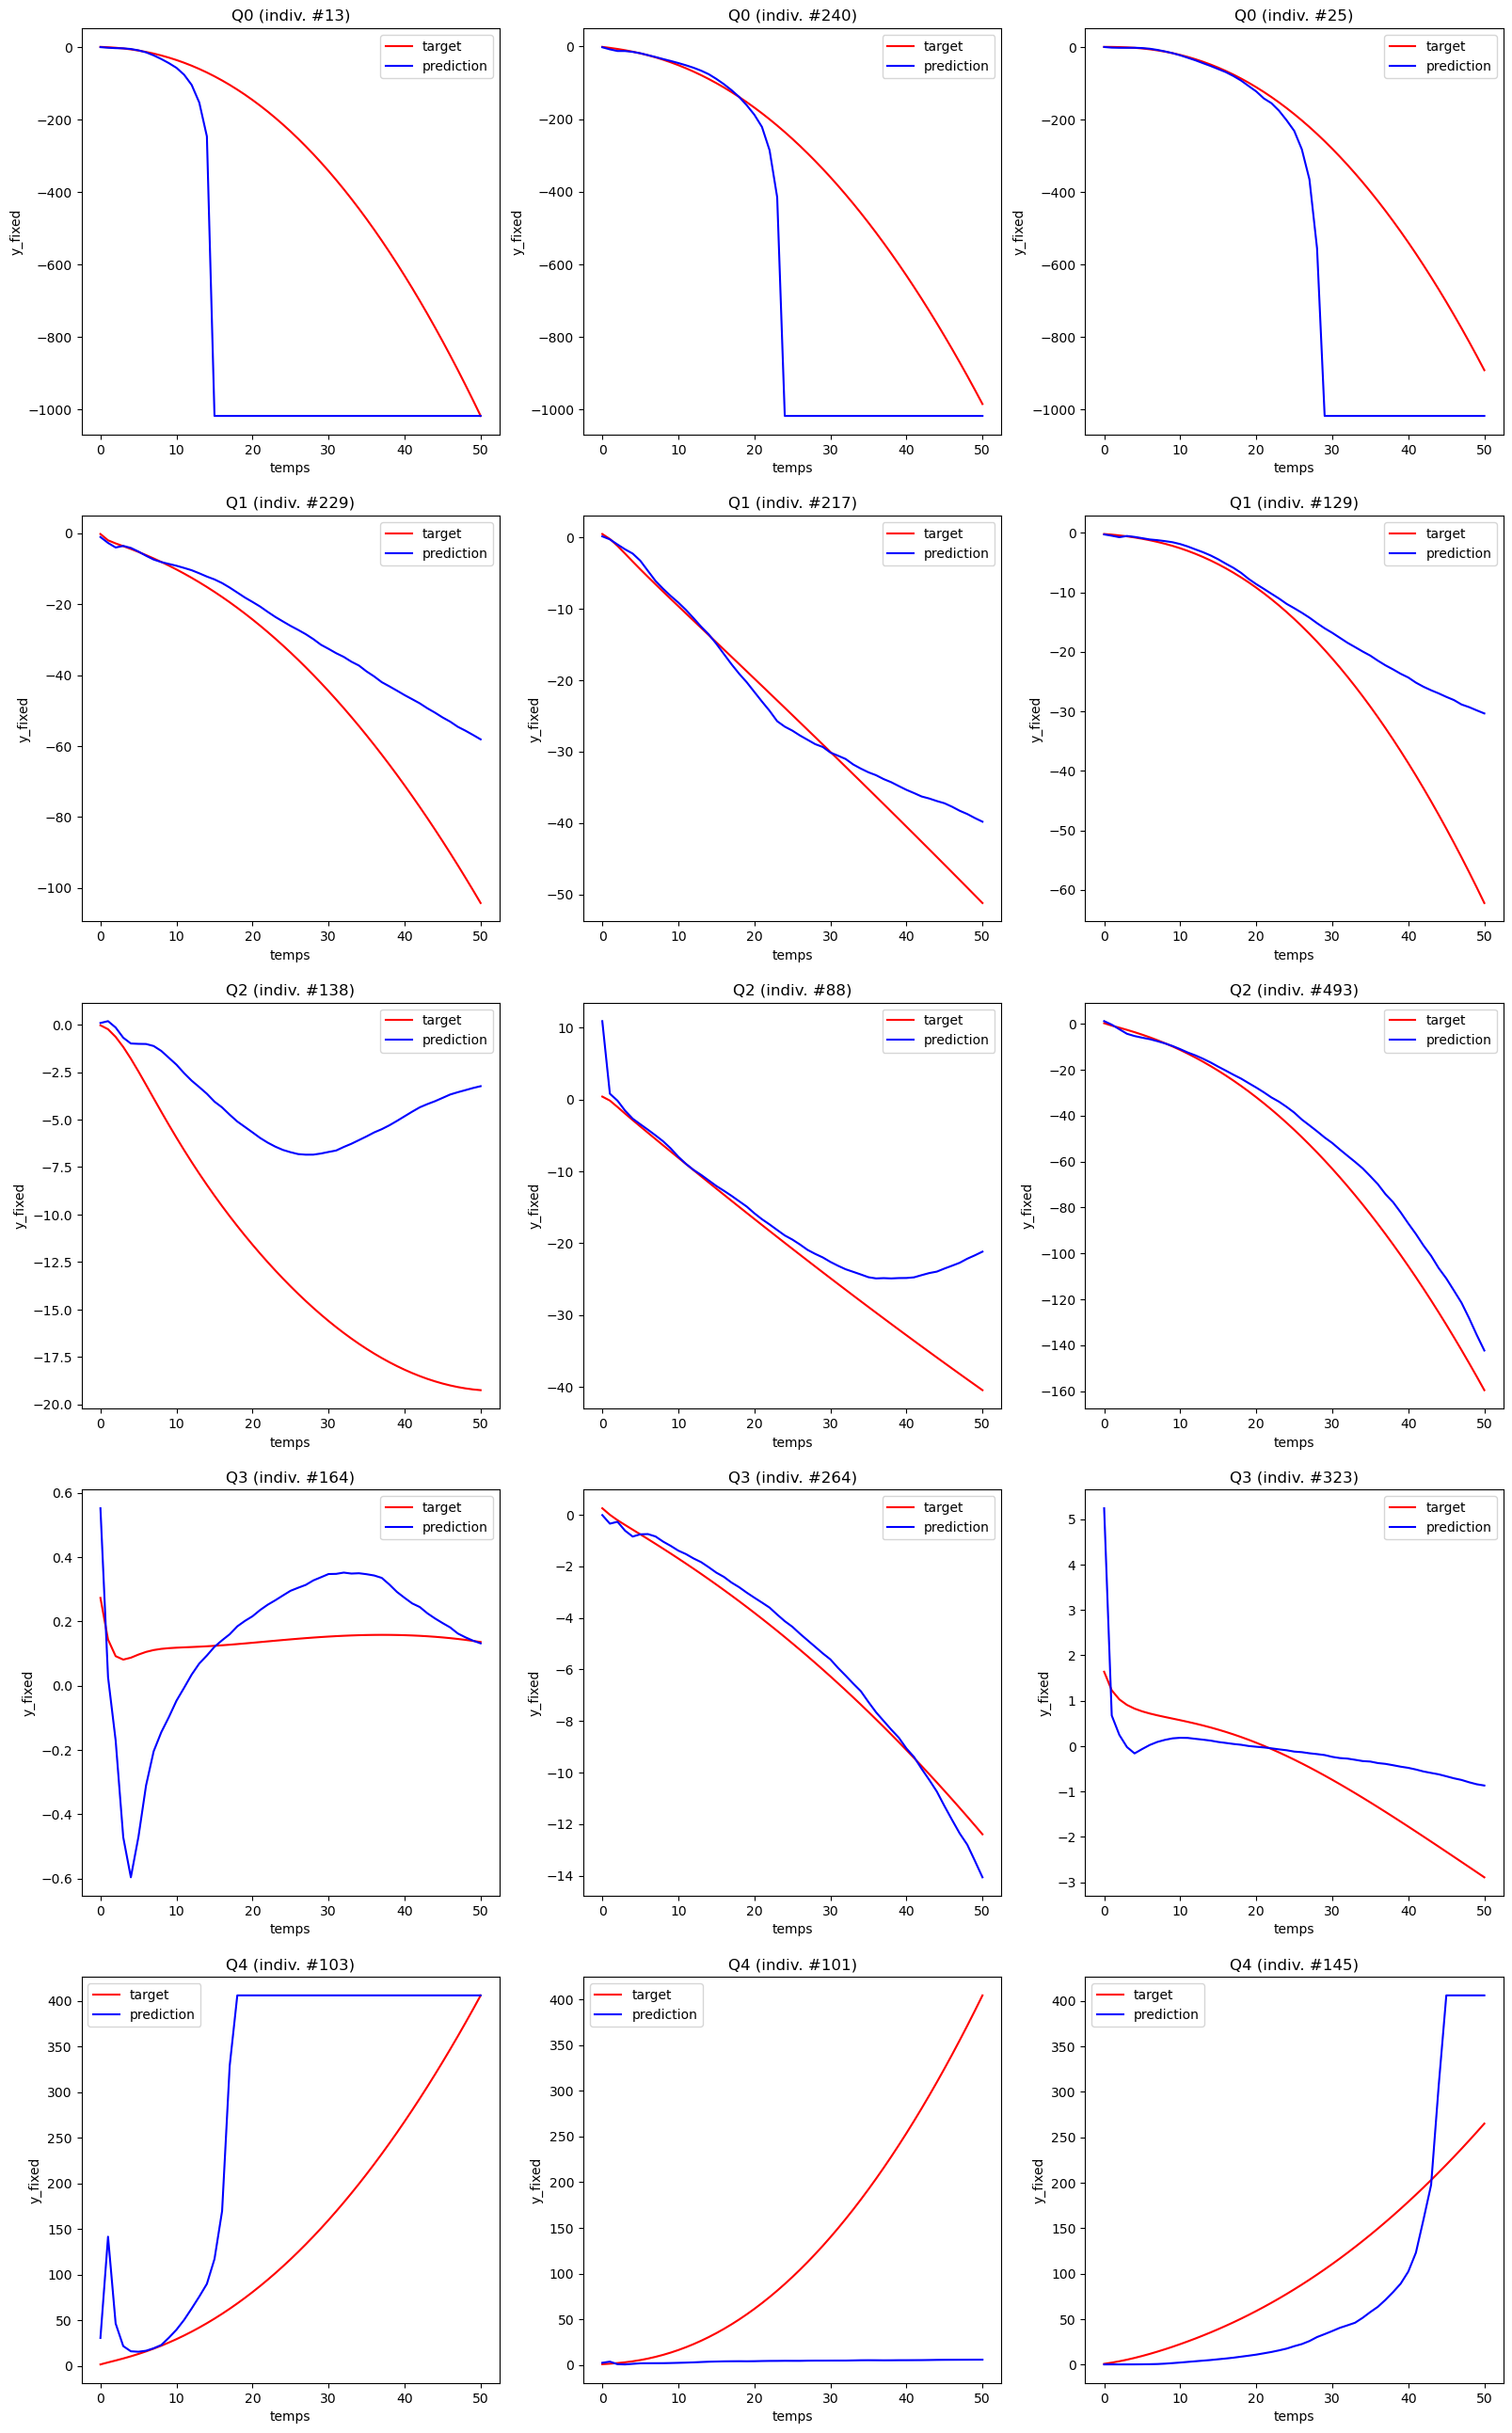

In [62]:
nrows = len(list_ind_quantile)
ncols = len(list_ind_quantile[0])


f, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6.5 * ncols, 6.5 * nrows),
)

for i_quantile, quantile_ind in enumerate(list_ind_quantile):
    for i_ind, ind in enumerate(quantile_ind):

        data_plot = data_train[data_train[SERIE_COLUMN_NAME] == ind]
        ax_ = ax[i_quantile, i_ind]

        sns.lineplot(
            x=data_plot[TIMESTEP_COLUMN_NAME],
            y=data_plot[y_true[0]],
            ax=ax_,
            color="red",
            label="target",
        )
        sns.lineplot(
            x=data_plot[TIMESTEP_COLUMN_NAME],
            y=data_plot["y_hat"],
            ax=ax_,
            color="blue",
            label="prediction",
        )

        ax_.set_title(f"Q{i_quantile} (indiv. #{ind})")
        ax_.legend()
        # ax_.set_ymax(ymax)